In [1]:
import os
from datetime import datetime
import pandas as pd
import numpy as np
from matplotlib import pylab as plt
from matplotlib import pyplot
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))
plt.style.use('ggplot')

In [3]:
DATE_FORMAT = "%Y-%m-%d %H:%M:%S"
ENERGY_FILE = "energy_model_dataset_anonymized.csv"

data = pd.read_csv(os.path.join(os.getcwd(), "data", ENERGY_FILE))
data["date"] = data["date"].apply(lambda dates: datetime.strptime(dates, DATE_FORMAT))
data.set_index("date", drop=True, inplace=True)
data.head()

ValueError: time data '2019-07-09 00:00:00' does not match format '%d/%m/%Y %H:%M'

In [4]:
# define which load to use for forecasting and other general constants
LOAD_TO_PREDICT = "C4"
FREQ = "1H" # frequency of the time series

c_data = pd.DataFrame()
c_data["energy"] = data[LOAD_TO_PREDICT].dropna()
c_data["temperature"] = data["temperature"].dropna()
c_data = c_data.asfreq(FREQ,"bfill")

In [5]:
class TargetTransformer:
    """
    Perform some transformation on the time series
    data in order to make the model more performant and
    avoid non-stationary effects.
    """
        
    def __init__(self, log=False, detrend=False, diff=False):
        
        self.trf_log = log
        self.trf_detrend = detrend
        self.trend = pd.Series(dtype=np.float64)
    
    def transform(self, index, values):
        """
        Perform log transformation to the target time series

        :param index: the index for the resulting series
        :param values: the values of the initial series

        Return:
            transformed pd.Series
        """
        res = pd.Series(index=index, data=values)

        if self.trf_detrend:
            self.trend = TargetTransformer.get_trend(res) - np.mean(res.values)
            res = res.subtract(self.trend)
            
        if self.trf_log:
            res = pd.Series(index=index, data=np.log(res.values))
        
        return res
    
    def inverse(self, index, values):
        """
        Go back to the original time series values

        :param index: the index for the resulting series
        :param values: the values of series to be transformed back

        Return:
            inverse transformed pd.Series
        """        
        res = pd.Series(index=index, data=values)
        
        if self.trf_log:
            res = pd.Series(index=index, data=np.exp(values))
        try:
            if self.trf_detrend:
                assert len(res.index) == len(self.trend.index)                
                res = res + self.trend
                
        except AssertionError:
            print("Use a different transformer for each target to transform")
            
        return res
    
    @staticmethod
    def get_trend(data):
        """
        Get the linear trend on the data which makes the time
        series not stationary
        """
        n = len(data.index)
        X = np.reshape(np.arange(0, n), (n, 1))
        y = np.array(data)
        model = LinearRegression()
        model.fit(X, y)
        trend = model.predict(X)
        return pd.Series(index=data.index, data=trend)

In [6]:
c_data.head(10)

,energy,temperature
date,,
2019-07-09 00:00:00,27.389202,33.683514
2019-07-09 01:00:00,27.763283,33.374493
2019-07-09 02:00:00,26.543455,36.155697
2019-07-09 03:00:00,25.177246,37.700813
2019-07-09 04:00:00,33.585926,38.530296
2019-07-09 05:00:00,39.587482,37.619490
2019-07-09 06:00:00,43.962597,38.107426
2019-07-09 07:00:00,48.272655,37.180355
2019-07-09 08:00:00,60.796223,35.342480


In [7]:
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression

In [8]:
def ts_analysis_plots(data, n_lags=100):

    def plot_cf(ax, fn, data, n_lags):
        """
        Plot autocorrelation functions for the loads
        """
        fn(data, ax=ax, lags=n_lags, color="#0504aa")
        for i in range(1, 5):
            ax.axvline(x=24*i, ymin=0.0, ymax=1.0, color='grey', ls="--")    

    # AD Fuller test and linear trend of the time series
    trend = TargetTransformer.get_trend(data)
    adf = adfuller(data)
            
    fig, axs = plt.subplots(2, 2, figsize=(25, 12))
    axs = axs.flat
    
    # original time series
    axs[0].plot(data, color='#0504aa')
    axs[0].plot(trend, color="red")
    axs[0].set(xlabel="Date", ylabel="KWh", 
               title=f"Energy consumption over time (ADF p-value: {round(adf[1], 6)})")
        
    # histogram of value distribution
    axs[1].hist(data, bins=20, width = 3, color='#0504aa',alpha=0.7)
    axs[1].set(xlabel="KWh", ylabel="# data points", title="Energy values distribution")
    
    # autocorrelation function
    plot_cf(axs[2], plot_acf, data, n_lags)
    axs[2].set(xlabel="lag", ylabel="ACF value")
    
    # partial autocorrelation function
    plot_cf(axs[3], plot_pacf, data, n_lags)
    axs[3].set(xlabel="lag", ylabel="PACF value")
    
    plt.show()

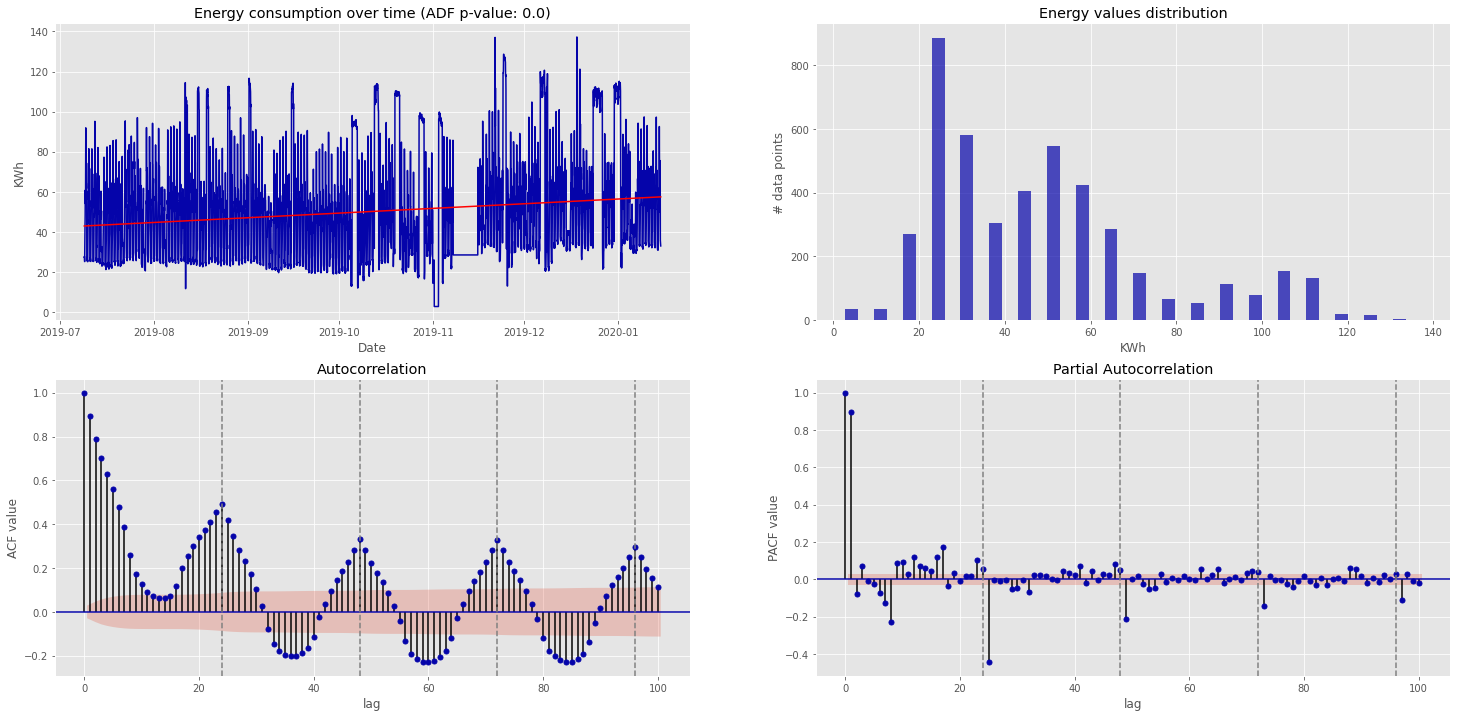

In [9]:
ts_analysis_plots(c_data["energy"])

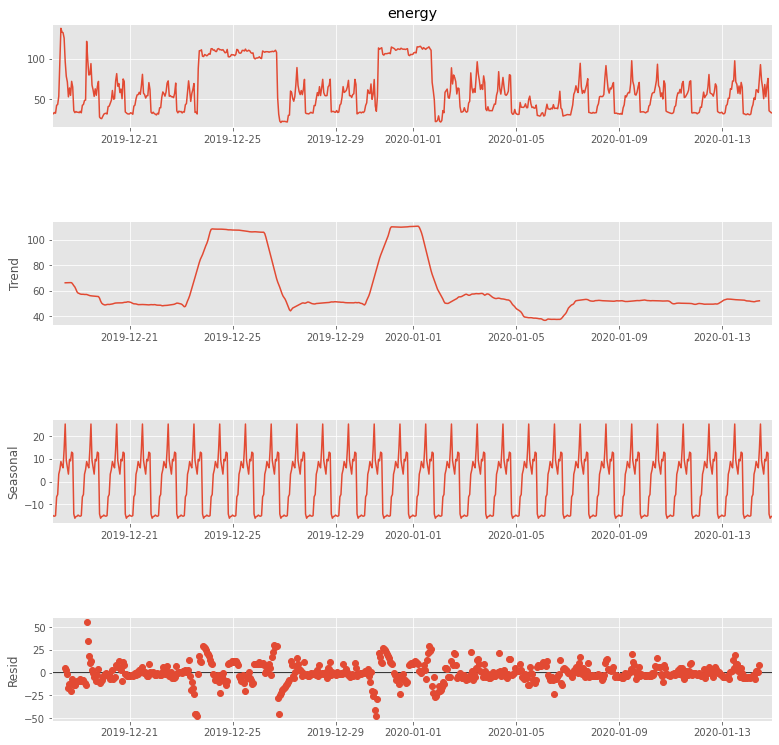

In [10]:
energy_data = c_data["energy"]
date = energy_data.index[-1] - pd.Timedelta(weeks=4)
energy_data = energy_data[energy_data.index > date]
res = seasonal_decompose(energy_data, model='additive')
fig = res.plot()
fig.set_size_inches((12, 12))

In [81]:
from sklearn.metrics import make_scorer

# MAPE computation
def mape(y, yhat, perc=True):
    n = len(yhat.index) if type(yhat) == pd.Series else len(yhat)    
    mape = []
    for a, f in zip(y, yhat):
        # avoid division by 0
        if f > 1e-9:
            mape.append(np.abs((a - f)/f))
    mape = np.mean(np.array(mape))
    return mape * 100. if perc else mape

mape_scorer = make_scorer(mape, greater_is_better=False)

In [62]:
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation as prophet_cv

# dictionary to keep track of all results
forecasting_results = {
    "prophet" : {},
    "ses": {},
    "des": {},
    "holt": {},
    "xgb": {}
}

# 1 day forecast
FCAST_STEPS = 48

# seasonal period inferred from the autocorrelation function
SEASONAL_PERIOD = 24

# the complete time series
c_target = c_data["energy"]

# data used for training
date = c_target.index[-1] - pd.Timedelta(hours=FCAST_STEPS)
t_target = c_target[c_target.index <= date]

# data used for forecasting
f_target = c_target[c_target.index > date]
fcast_initial_date = f_target.index[0]
fcast_range = pd.date_range(fcast_initial_date, periods=FCAST_STEPS, freq="H")

print(f"Full available time range: from {c_target.index[0]} to {c_target.index[-1]}")
print(f"Training time range: from {t_target.index[0]} to {t_target.index[-1]}")
print(f"Short forecasting time range: from {fcast_range[0]} to {fcast_range[-1]}")

Full available time range: from 2019-07-09 00:00:00 to 2020-01-14 23:00:00
Training time range: from 2019-07-09 00:00:00 to 2020-01-12 23:00:00
Short forecasting time range: from 2020-01-13 00:00:00 to 2020-01-14 23:00:00


In [63]:
start_date = t_target.index[-1] - pd.Timedelta(hours=FCAST_STEPS)

y_train_trf = TargetTransformer()
y_train = t_target[t_target.index <= start_date]
y_train_trf.transform(y_train.index, y_train.values)

y_test_trf = TargetTransformer()
y_test = t_target[t_target.index > start_date]
y_test = y_test_trf.transform(y_test.index, y_test.values)

In [64]:
# Facebook Prophet

def fit_prophet_model(data):
    
    prophet_data = pd.DataFrame()
    prophet_data = data.copy().reset_index()
    prophet_data.columns = ["ds", "y"]

    # create Prophet model
    prophet_m = Prophet(daily_seasonality=False,
                        weekly_seasonality=False,
                        yearly_seasonality=False,
                        seasonality_mode="additive",
                        seasonality_prior_scale=25,
                        growth="linear")

    prophet_m.add_seasonality(
        name="daily", 
        period=1, 
        fourier_order=30)

    prophet_m.fit(prophet_data)

    # cross-validation score
    horizon = 480
    res = None
    res = prophet_cv(prophet_m, horizon=f"{horizon} hours")
#     cv_score = mean_squared_error(res["yhat"], res["y"], squared=False)
    cv_score = mape(res["y"], res["yhat"])
    return prophet_m, cv_score

model, cv_score = fit_prophet_model(y_train)
future = model.make_future_dataframe(periods=FCAST_STEPS, freq="1H")

# RMSE on test set
test_fcast = model.predict(future)
test_fcast = np.array(test_fcast["yhat"])[-FCAST_STEPS:]
test_score = mape(y_test.values, test_fcast)
print(f"Prophet model cross-validation/test RMSE: {round(cv_score,4)}/{round(test_score, 4)}")

# retrain the model on the whole dataset
model, _ = fit_prophet_model(t_target)

INFO:fbprophet:Making 11 forecasts with cutoffs between 2019-09-12 23:00:00 and 2019-12-21 23:00:00


Prophet model cross-validation/test RMSE: 54.5438/21.6652


INFO:fbprophet:Making 11 forecasts with cutoffs between 2019-09-14 23:00:00 and 2019-12-23 23:00:00


In [65]:
future = model.make_future_dataframe(periods=FCAST_STEPS, freq="1H")
prophet_fcast = model.predict(future)
prophet_fcast = pd.Series(index=prophet_fcast["ds"], data=np.array(prophet_fcast["yhat"]))

In [66]:
fcast_score = mape(c_target.loc[fcast_range].values, prophet_fcast.loc[fcast_range].values)
print(f"Prophet model forecasting RMSE: {fcast_score}")

Prophet model forecasting RMSE: 16.55328287825951


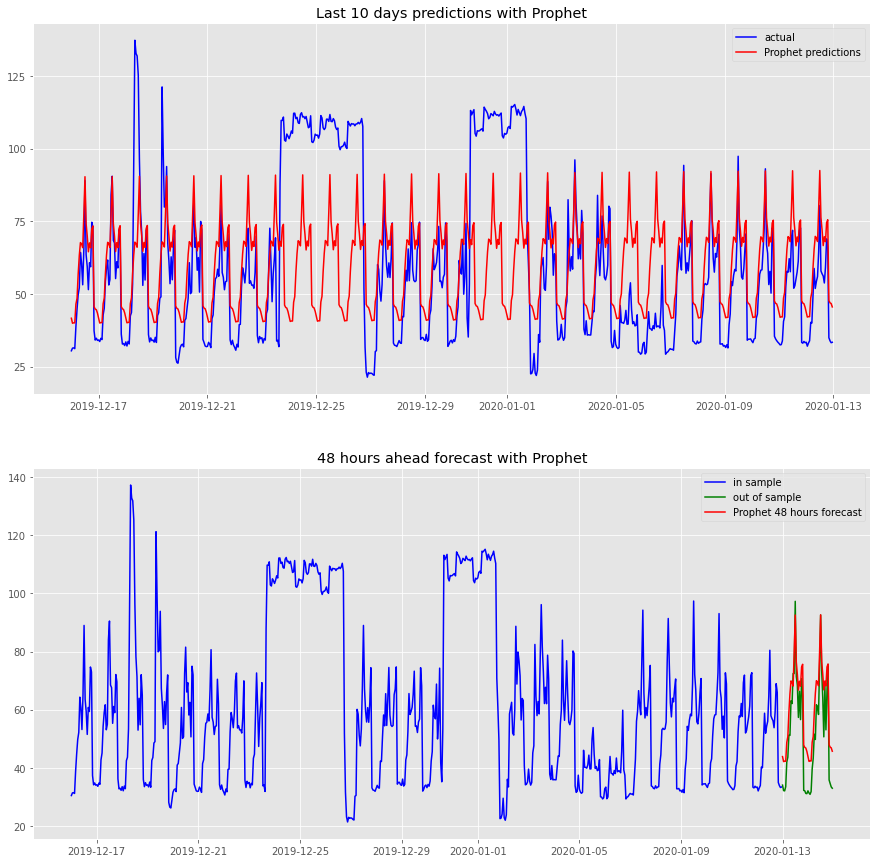

In [67]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 15))

start_date = t_target.index[-1] - pd.Timedelta(weeks=4)
ax1.locator_params(nbins=6)
ax1.plot(t_target[t_target.index > start_date], color="blue", label="actual")
ax1.plot(prophet_fcast[(prophet_fcast.index > start_date) & (prophet_fcast.index <= t_target.index[-1])], 
         color="red", label="Prophet predictions")
ax1.set_title("Last 10 days predictions with Prophet")

start_date = t_target.index[-1] - pd.Timedelta(weeks=4)
ax2.plot(t_target[t_target.index > start_date], color="blue", label="in sample")
ax2.plot(f_target, color="green", label="out of sample")
ax2.plot(prophet_fcast[prophet_fcast.index >= f_target.index[0]], 
         color="red", 
         label=f"Prophet {FCAST_STEPS} hours forecast")
ax2.set_title(f"{FCAST_STEPS} hours ahead forecast with Prophet")

ax1.legend()
ax2.legend()
plt.show()

# save results for later comparison
forecasting_results["prophet"] = {
    "fcast": prophet_fcast,
    "model": model,
    "cv_score": cv_score,
    "test_score": test_score,
    "fcast_score": fcast_score
}

In [69]:
# fit the classical models

def fit_classical_model(data, model, params=None):
    tscv = TimeSeriesSplit(n_splits=5)
    
    # train the model before-hand with automatic 
    # parameter optimization
    fit = model.fit(optimized=True)
    values = data.values
    params = fit.model.params
    
    # compute the total average error
    err = []
    for _, test in tscv.split(values):        
        predicted = model.predict(params, 
                                  start=test[0], end=test[-1])
        actual = values[test]
#         err.append(mean_squared_error(predicted, actual, squared=False))
        err.append(mape(actual, predicted))
    
    return model, fit, np.mean(np.array(err))

model = SimpleExpSmoothing(t_target)
res = fit_classical_model(t_target, model)
forecasting_results["ses"]["model"] = res[1]
forecasting_results["ses"]["cv_score"] = res[2]

model = Holt(t_target)
res = fit_classical_model(t_target, model)
forecasting_results["des"]["model"] = res[1]
forecasting_results["des"]["cv_score"] = res[2]

model = ExponentialSmoothing(t_target, 
                             trend=None, 
                             seasonal="add",
                             damped=False,
                             seasonal_periods=SEASONAL_PERIOD)
res = fit_classical_model(t_target, model)
forecasting_results["holt"]["model"] = res[1]
forecasting_results["holt"]["cv_score"] = res[2]
print(f"Holt-Winters cross-validation RMSE score: {forecasting_results['holt']['cv_score']}")

holt_pred = forecasting_results["holt"]["model"].predict(start=t_target.index[0], end=t_target.index[-1])
holt_fcast = forecasting_results["holt"]["model"].forecast(FCAST_STEPS)

Holt-Winters cross-validation RMSE score: 14.730415544589992


/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [70]:
fcast_score = mape(c_target.loc[fcast_range].values, holt_fcast.values)
print(f"Holt-Winters model forecasting RMSE: {fcast_score}")
# save results for later comparison
forecasting_results["holt"] = {
    "fcast": holt_fcast,
    "fcast_score": fcast_score
}

Holt-Winters model forecasting RMSE: 24.75844446157728


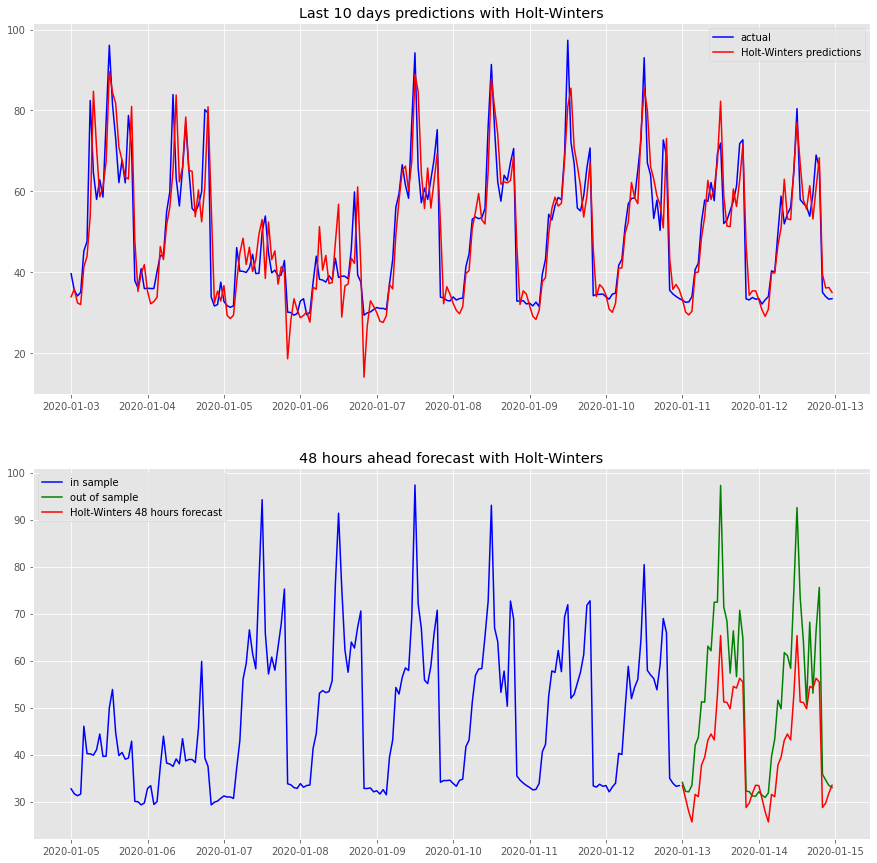

In [71]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 15))

start_date = t_target.index[-1] - pd.Timedelta(days=10)
ax1.plot(t_target[t_target.index > start_date], color="blue", label="actual")
ax1.plot(holt_pred[(holt_pred.index > start_date) & (holt_pred.index <= t_target.index[-1])], 
         color="red", label="Holt-Winters predictions")
ax1.set_title("Last 10 days predictions with Holt-Winters")

start_date = t_target.index[-1] - pd.Timedelta(days=8)
ax2.plot(t_target[t_target.index > start_date], color="blue", label="in sample")
ax2.plot(f_target, color="green", label="out of sample")
ax2.plot(holt_fcast, color="red", 
         label=f"Holt-Winters {FCAST_STEPS} hours forecast")
ax2.set_title(f"{FCAST_STEPS} hours ahead forecast with Holt-Winters")

ax1.legend()
ax2.legend()
plt.show()

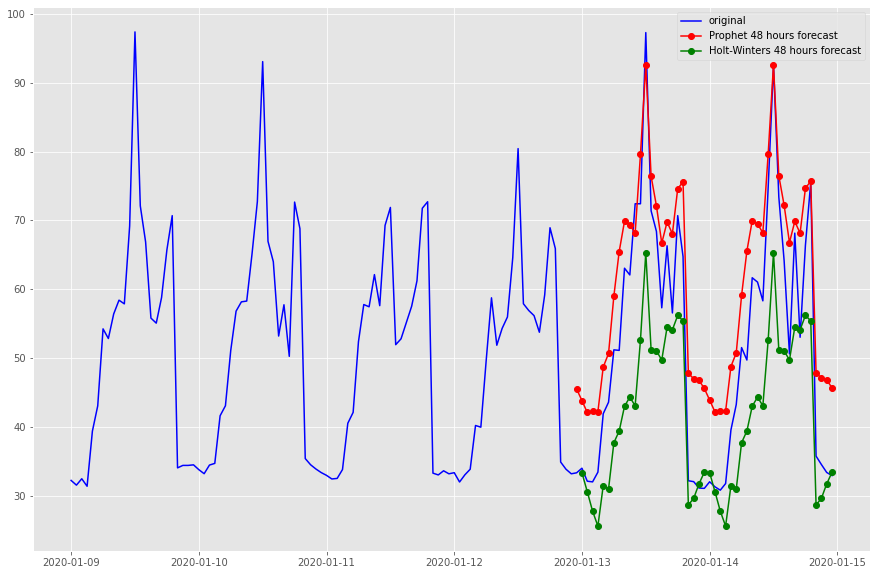

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

start_date = t_target.index[-1] - pd.Timedelta(days=4)

ax.plot(c_target[c_target.index > start_date], color="blue", label="original")

ax.plot(prophet_fcast[prophet_fcast.index >= t_target.index[-1]], 
        color="red", 
        label=f"Prophet {FCAST_STEPS} hours forecast",
        marker="o")

ax.plot(holt_fcast[holt_fcast.index >= t_target.index[-1]], 
        color="green", 
        label=f"Holt-Winters {FCAST_STEPS} hours forecast",
        marker="o")

ax.legend()
plt.show()

In [73]:
from pyramid.arima import auto_arima


/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/si

### Predicting with machine learning: XGBoost model

We are going now to apply standard machine learning technique for forecasting future values of the energy consumption measurements. We choose the XGBoost algorithm which solves multiple decision tree problems using the Gradient Boosting technique. Look here[] for a good introduction. XGBoost is fast and accurate compared to other tree-based methods for time series problems, as shown in several previous applications of this method available online [ref]. XGBoost might not perform as good as deep learning based approaches such as Long-Short Term Memory models, but these are outside the scope of this blogpost and will be discussed in a later article.

In [82]:
from functools import partial
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (TimeSeriesSplit, train_test_split, 
                                     cross_val_score)
from sklearn.preprocessing import StandardScaler, scale
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, STATUS_FAIL
import xgboost as xgb
from statsmodels.tsa.stattools import pacf, acf

##### Feature Engineering and Trasformation

In order to transform a time series forecasting task into a supervised machine learning problem we need to create a feature set. The actual time series values are instead used as labels for the ML model. 
The kinds of features we can consider are divided into 3 categories:

* **lag features**: use the original time series itself as feature with a certain shift usually called lag. The lags are chosen based on the aforementioned partial autocorrelation functions. We choose to consider lag features only when PACF is greater than 0.2 (5% relevance) to build the features.
* **standard time series features**: standard time series features such as hour, weekend, season and so on. Using some basic domain knowledge on the data we can also build a feature indicating the current worjer shift at every timestamp.
* **endogoneous features**: endogenous features, i.e. features which are themselves a time series and are external, i.e. not dependent on the one that has to be predicted. In our case the external temperature is an endogenous variable, but in this post it is not considered.

The code used to create lag and time series features is given below.

In [83]:
def create_lag_features(target, lags=None, thres=0.2):
    
    scaler = StandardScaler()
    features = pd.DataFrame()
                
    if lags is None:
        partial = pd.Series(data=pacf(target, nlags=48))
        lags = list(partial[np.abs(partial) >= thres].index)

    df = pd.DataFrame()
    if 0 in lags:
        lags.remove(0) # do not consider itself as lag feature
    for l in lags:
        df[f"lag_{l}"] = target.shift(l)
        
    features = pd.DataFrame(scaler.fit_transform(df[df.columns]), 
                            columns=df.columns)

    features = df
    features.index = target.index
    
    return features

def create_ts_features(data):
    
    def get_shift(row):
        """
        Factory working shift: 3 shifts per day of 8 hours
        """
        if 6 <= row.hour <= 14:
            return 2
        elif 15 <= row.hour <= 22:
            return 3
        else:
            return 1
    
    features = pd.DataFrame()
    
    features["hour"] = data.index.hour
    features["weekday"] = data.index.weekday
    features["dayofyear"] = data.index.dayofyear
    features["is_weekend"] = data.index.weekday.isin([5, 6]).astype(np.int32)
    features["weekofyear"] = data.index.weekofyear
    features["month"] = data.index.month
    features["season"] = (data.index.month%12 + 3)//3
    features["shift"] = pd.Series(data.index.map(get_shift))
    
    features.index = data.index
        
    return features

def create_endog_features(data, extracted=None):
    
    scaler = StandardScaler()
    features = pd.DataFrame()
    
    if extracted is None:
        return features

    # energy consuption of the turbine
    if "turbine" in extracted:
        features["turbine"] = np.where(data["turbine"] > 500, 1, 0)
        extracted.remove("turbine")   

    # all the rest of the features
    for f in extracted:
        features[f] = scale(data[f].values)

    features.index = data.index
    
    return features
lags = create_lag_features(t_target, thres=0.2)
ts = create_ts_features(t_target)
features = ts.join(lags, how="outer").dropna()
target = t_target[t_target.index >= features.index[0]]
features.head()

,hour,weekday,dayofyear,is_weekend,weekofyear,month,season,shift,lag_1,lag_8,lag_25
date,,,,,,,,,,,
2019-07-10 01:00:00,1,2,191,0,28,7,3,1,26.283224,61.625706,27.389202
2019-07-10 02:00:00,2,2,191,0,28,7,3,1,25.567593,74.311910,27.763283
2019-07-10 03:00:00,3,2,191,0,28,7,3,1,25.746500,63.675020,26.543455
2019-07-10 04:00:00,4,2,191,0,28,7,3,1,25.095926,26.950064,25.177246
2019-07-10 05:00:00,5,2,191,0,28,7,3,1,32.691387,26.201904,33.585926


In order to make the time series easier to digest to the ML model we also apply some standard transformation techniques on the target used for the supervised learning problem. In particular we apply:

* **differencing**: take the different with 24 hours lagged time series values. This contributes to remove most of the seasonal component in the time series.

* **log transformation**: take the logarithm of the time series to allievate any residual seasonal effect.

* **detrending**: remove linear trend from the time series

The following class applies these transformations to a generic time series given as input and also implements inverse transformation to go back to the original data after forecasting. Beware that the inverse transformation must always be applied in reverse order.

In [84]:
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    target, 
                                                    test_size=0.3,
                                                    shuffle=False) 

y_train_trf = TargetTransformer(log=False, detrend=False)
y_train = y_train_trf.transform(y_train.index, y_train.values)

y_test_trf = TargetTransformer(log=False, detrend=False)
y_test = y_test_trf.transform(y_test.index, y_test.values)


Linear Regression RMSE cross-validation/test: 20.956/12.4604


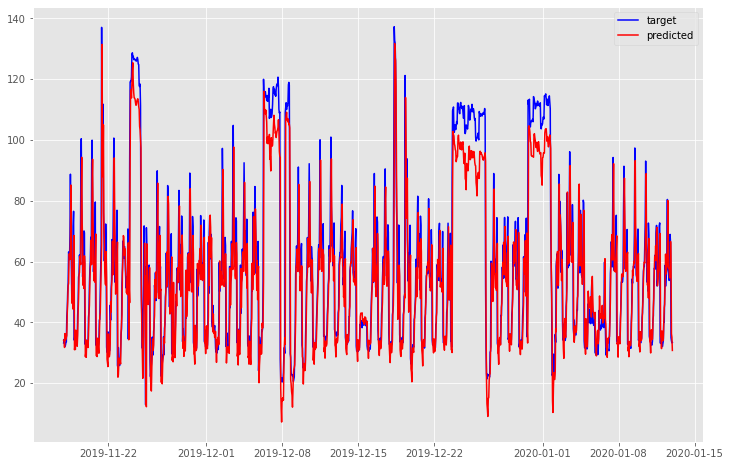

In [86]:
# testing of simple linear regression model for time series analysis
from sklearn.linear_model import Ridge

# machine learning in two lines
lr_model = Ridge(alpha=5)
lr_model.fit(X_train, y_train)

# cross validate using the right iterator for time series
cv_space = TimeSeriesSplit(n_splits=4)
cv_score = cross_val_score(lr_model, 
                           X_train, y_train, 
                           cv=cv_space, 
                           scoring=mape_scorer)

cv_score = np.mean(np.abs(cv_score))
# evaluate the model on the test set
predictions = lr_model.predict(X_test.values)
test_score = mean_squared_error(y_test.values, predictions, squared=False)
print(f"Linear Regression RMSE cross-validation/test: {round(cv_score, 4)}/{round(test_score, 4)}")

# plot
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# print feature importance
# coeffs = pd.DataFrame(model.coef_, columns=X_train.columns).apply(np.abs)
# coeffs.plot(ax=ax1, kind="bar")
# ax1.grid(True, axis="y")
# ax1.get_legend().remove()

y = y_test_trf.inverse(y_test.index, y_test.values)
p = y_test_trf.inverse(y_test.index, predictions)

ax.plot(y, label="target", color="blue")
ax.plot(p, label="predicted", color="red")
ax.legend()
plt.show()

# save results for later comparison
forecasting_results["linear"] = {
    "predicted": predictions,
    "cv_score": cv_score,
    "test_score": test_score
}

##### Training and testing
We use a standard pipeline for training and testing the XGBoost model. We split the dataset in 80% training and 20% testing set. The hyperparameters are optimized using Bayesan optimization technique as implemented by the `hyperopt` library. Cross-validation with rolling time window is used as metric for the optimization procedure. The optimized model is used to predict the values on the test set. The final, optimized model yields a RMSE of 7.30 from cross validation and 6.92 when evaluating on the test set. The predicted outcome is shown in the figure below.

In [88]:
# run XGBoost algorithm with hyperparameters optimization
# this model outperforms the linear regression

def train_xgb(params, X_train, y_train):
    """
    Train XGBoost regressor using the parameters given as input. The model
    is validated using standard cross validation technique adapted for time series
    data. This function returns a friendly output for the hyperopt parameter optimization
    module.
    
    Parameters
    ----------
    params: dict with the parameters of the XGBoost regressor. For complete list see: 
            https://xgboost.readthedocs.io/en/latest/parameter.html
    X_train: pd.DataFrame with the training set features
    y_train: pd.Series with the training set targets    
    
    Returns
    -------
    dict with keys 'model' for the trained model, 'status' containing the hyperopt
    status string and 'loss' with the RMSE obtained from cross-validation
    """
    
    n_estimators = int(params["n_estimators"])
    max_depth= int(params["max_depth"])

    try:
        model = xgb.XGBRegressor(n_estimators=n_estimators, 
                                 max_depth=max_depth, 
                                 learning_rate=params["learning_rate"],
                                 subsample=params["subsample"])

        result = model.fit(X_train, 
                           y_train.values.ravel(),
                           eval_set=[(X_train, y_train.values.ravel())],
                           early_stopping_rounds=50,
                           verbose=False)
        
        # cross validate using the right iterator for time series
        cv_space = TimeSeriesSplit(n_splits=5)
        cv_score = cross_val_score(model, 
                                   X_train, y_train.values.ravel(), 
                                   cv=cv_space, 
                                   scoring=mape_scorer)

        rmse = np.abs(np.mean(np.array(cv_score)))
        return {
            "loss": rmse,
            "status": STATUS_OK,
            "model": model
        }
        
    except ValueError as ex:
        return {
            "error": ex,
            "status": STATUS_FAIL
        }
    
def optimize_xgb(X_train, y_train, max_evals=10):
    """
    Run Bayesan optimization to find the optimal XGBoost algorithm
    hyperparameters.
    
    Parameters
    ----------
    X_train: pd.DataFrame with the training set features
    y_train: pd.Series with the training set targets
    max_evals: the maximum number of iterations in the Bayesian optimization method
    
    Returns
    -------
    best: dict with the best parameters obtained
    trials: a list of hyperopt Trials objects with the history of the optimization
    """
    
    space = {
        "n_estimators": hp.quniform("n_estimators", 100, 1000, 10),
        "max_depth": hp.quniform("max_depth", 1, 8, 1),
        "learning_rate": hp.loguniform("learning_rate", -5, 1),
        "subsample": hp.uniform("subsample", 0.8, 1),
        "gamma": hp.quniform("gamma", 0, 100, 1)
    }

    objective_fn = partial(train_xgb, 
                           X_train=X_train, 
                           y_train=y_train)
    
    trials = Trials()
    best = fmin(fn=objective_fn,
                space=space,
                algo=tpe.suggest,
                max_evals=max_evals,
                trials=trials)

    # evaluate the best model on the test set
    print(f"""
    Best parameters:
        learning_rate: {best["learning_rate"]} 
        n_estimators: {best["n_estimators"]}
        max_depth: {best["max_depth"]}
        sub_sample: {best["subsample"]}
        gamma: {best["gamma"]}
    """)
    return best, trials

best, trials = optimize_xgb(X_train, y_train, max_evals=50)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001943 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  2%|▏         | 1/50 [00:01<01:01,  1.26s/trial, best loss: 14.594119504870173]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001608 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 14.594120


  4%|▍         | 2/50 [00:04<01:28,  1.85s/trial, best loss: 14.594119504870173]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001659 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 14.594120


  6%|▌         | 3/50 [00:05<01:13,  1.56s/trial, best loss: 14.594119504870173]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001610 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 14.594120


  8%|▊         | 4/50 [00:07<01:23,  1.81s/trial, best loss: 14.594119504870173]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001724 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 14.594120


 10%|█         | 5/50 [00:08<01:10,  1.56s/trial, best loss: 14.594119504870173]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001735 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 14.594120


 12%|█▏        | 6/50 [00:10<01:05,  1.48s/trial, best loss: 14.594119504870173]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001688 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 14.594120


 14%|█▍        | 7/50 [00:11<01:05,  1.53s/trial, best loss: 14.594119504870173]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001594 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 14.594120


 16%|█▌        | 8/50 [00:12<01:00,  1.44s/trial, best loss: 14.594119504870173]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001623 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 14.594120


 18%|█▊        | 9/50 [00:16<01:28,  2.15s/trial, best loss: 14.594119504870173]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001856 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 14.594120


 20%|██        | 10/50 [00:18<01:22,  2.06s/trial, best loss: 14.594119504870173]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001618 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss 14.594120


 22%|██▏       | 11/50 [00:22<01:39,  2.55s/trial, best loss: 14.594119504870173]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001736 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss 14.594120


 24%|██▍       | 12/50 [00:25<01:44,  2.76s/trial, best loss: 14.594119504870173]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001645 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss 14.594120


 26%|██▌       | 13/50 [00:26<01:23,  2.27s/trial, best loss: 14.594119504870173]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001621 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss 14.594120


 28%|██▊       | 14/50 [00:28<01:22,  2.29s/trial, best loss: 14.594119504870173]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001625 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss 14.594120


 30%|███       | 15/50 [00:29<01:05,  1.88s/trial, best loss: 14.594119504870173]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002777 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss 14.594120


 32%|███▏      | 16/50 [00:31<00:58,  1.71s/trial, best loss: 14.594119504870173]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001621 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss 14.594120


 34%|███▍      | 17/50 [00:36<01:30,  2.74s/trial, best loss: 14.594119504870173]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001674 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss 14.594120


 36%|███▌      | 18/50 [00:36<01:07,  2.10s/trial, best loss: 14.594119504870173]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001638 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss 14.594120


 38%|███▊      | 19/50 [00:40<01:22,  2.66s/trial, best loss: 14.594119504870173]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001661 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss 14.594120


 40%|████      | 20/50 [00:45<01:36,  3.20s/trial, best loss: 14.594119504870173]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.011147 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss 14.594120


 42%|████▏     | 21/50 [00:45<01:09,  2.40s/trial, best loss: 14.594119504870173]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001704 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss 14.594120


 44%|████▍     | 22/50 [00:46<00:50,  1.81s/trial, best loss: 14.594119504870173]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001620 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss 14.594120


 46%|████▌     | 23/50 [00:46<00:38,  1.43s/trial, best loss: 14.594119504870173]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001633 seconds
INFO:hyperopt.tpe:TPE using 22/23 trials with best loss 14.594120


 48%|████▊     | 24/50 [00:47<00:31,  1.21s/trial, best loss: 14.594119504870173]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001631 seconds
INFO:hyperopt.tpe:TPE using 23/24 trials with best loss 14.594120


 50%|█████     | 25/50 [00:49<00:34,  1.36s/trial, best loss: 14.594119504870173]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001699 seconds
INFO:hyperopt.tpe:TPE using 24/25 trials with best loss 14.594120


 52%|█████▏    | 26/50 [00:52<00:44,  1.86s/trial, best loss: 14.594119504870173]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001650 seconds
INFO:hyperopt.tpe:TPE using 25/26 trials with best loss 14.594120


 54%|█████▍    | 27/50 [00:53<00:35,  1.54s/trial, best loss: 14.410411508713057]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001613 seconds
INFO:hyperopt.tpe:TPE using 26/27 trials with best loss 14.410412


 56%|█████▌    | 28/50 [00:56<00:44,  2.01s/trial, best loss: 14.410411508713057]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001630 seconds
INFO:hyperopt.tpe:TPE using 27/28 trials with best loss 14.410412


 58%|█████▊    | 29/50 [00:57<00:34,  1.64s/trial, best loss: 14.357926514968]   

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001884 seconds
INFO:hyperopt.tpe:TPE using 28/29 trials with best loss 14.357927


 60%|██████    | 30/50 [00:57<00:25,  1.30s/trial, best loss: 14.357926514968]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001683 seconds
INFO:hyperopt.tpe:TPE using 29/30 trials with best loss 14.357927


 62%|██████▏   | 31/50 [00:58<00:24,  1.30s/trial, best loss: 14.302682969535706]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001705 seconds
INFO:hyperopt.tpe:TPE using 30/31 trials with best loss 14.302683


 64%|██████▍   | 32/50 [00:59<00:22,  1.25s/trial, best loss: 14.302682969535706]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001681 seconds
INFO:hyperopt.tpe:TPE using 31/32 trials with best loss 14.302683


 66%|██████▌   | 33/50 [01:01<00:21,  1.26s/trial, best loss: 14.302682969535706]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001711 seconds
INFO:hyperopt.tpe:TPE using 32/33 trials with best loss 14.302683


 68%|██████▊   | 34/50 [01:02<00:18,  1.14s/trial, best loss: 14.302682969535706]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001686 seconds
INFO:hyperopt.tpe:TPE using 33/34 trials with best loss 14.302683


 70%|███████   | 35/50 [01:03<00:17,  1.19s/trial, best loss: 14.302682969535706]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010069 seconds
INFO:hyperopt.tpe:TPE using 34/35 trials with best loss 14.302683


 72%|███████▏  | 36/50 [01:06<00:23,  1.67s/trial, best loss: 14.302682969535706]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001666 seconds
INFO:hyperopt.tpe:TPE using 35/36 trials with best loss 14.302683


 74%|███████▍  | 37/50 [01:07<00:21,  1.64s/trial, best loss: 14.302682969535706]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001621 seconds
INFO:hyperopt.tpe:TPE using 36/37 trials with best loss 14.302683


 76%|███████▌  | 38/50 [01:08<00:16,  1.37s/trial, best loss: 14.302682969535706]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001703 seconds
INFO:hyperopt.tpe:TPE using 36/38 trials with best loss 14.302683


 78%|███████▊  | 39/50 [01:10<00:17,  1.57s/trial, best loss: 14.302682969535706]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002938 seconds
INFO:hyperopt.tpe:TPE using 37/39 trials with best loss 14.302683


 80%|████████  | 40/50 [01:11<00:13,  1.31s/trial, best loss: 14.302682969535706]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001665 seconds
INFO:hyperopt.tpe:TPE using 37/40 trials with best loss 14.302683


 82%|████████▏ | 41/50 [01:11<00:09,  1.09s/trial, best loss: 14.302682969535706]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001645 seconds
INFO:hyperopt.tpe:TPE using 38/41 trials with best loss 14.302683


 84%|████████▍ | 42/50 [01:15<00:13,  1.73s/trial, best loss: 14.302682969535706]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002988 seconds
INFO:hyperopt.tpe:TPE using 39/42 trials with best loss 14.302683


 86%|████████▌ | 43/50 [01:16<00:10,  1.55s/trial, best loss: 14.302682969535706]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001632 seconds
INFO:hyperopt.tpe:TPE using 39/43 trials with best loss 14.302683


 88%|████████▊ | 44/50 [01:17<00:09,  1.56s/trial, best loss: 14.302682969535706]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001627 seconds
INFO:hyperopt.tpe:TPE using 40/44 trials with best loss 14.302683


 90%|█████████ | 45/50 [01:21<00:10,  2.16s/trial, best loss: 14.302682969535706]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003224 seconds
INFO:hyperopt.tpe:TPE using 41/45 trials with best loss 14.302683


 92%|█████████▏| 46/50 [01:22<00:07,  1.82s/trial, best loss: 14.302682969535706]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001618 seconds
INFO:hyperopt.tpe:TPE using 42/46 trials with best loss 14.302683


 94%|█████████▍| 47/50 [01:23<00:04,  1.50s/trial, best loss: 14.302682969535706]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001627 seconds
INFO:hyperopt.tpe:TPE using 43/47 trials with best loss 14.302683


 96%|█████████▌| 48/50 [01:25<00:03,  1.72s/trial, best loss: 14.302682969535706]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001636 seconds
INFO:hyperopt.tpe:TPE using 44/48 trials with best loss 14.302683


 98%|█████████▊| 49/50 [01:25<00:01,  1.39s/trial, best loss: 14.302682969535706]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001626 seconds
INFO:hyperopt.tpe:TPE using 45/49 trials with best loss 14.302683


100%|██████████| 50/50 [01:26<00:00,  1.73s/trial, best loss: 14.302682969535706]

    Best parameters:
        learning_rate: 0.010999830897635841 
        n_estimators: 540.0
        max_depth: 3.0
        sub_sample: 0.9744769397090398
        gamma: 63.0
    


In [90]:
# evaluate the best model on the test set
res = train_xgb(best, X_test, y_test)
xgb_model = res["model"]
predictions = xgb_model.predict(X_test)
cv_score = min([f["loss"] for f in trials.results if f["status"] == STATUS_OK])
test_score = mape(y_test.values, predictions)

print(f"Root mean square error cross-validation/test: {cv_score:.4f} / {test_score:.4f}")

Root mean square error cross-validation/test: 14.3027 / 8.3784


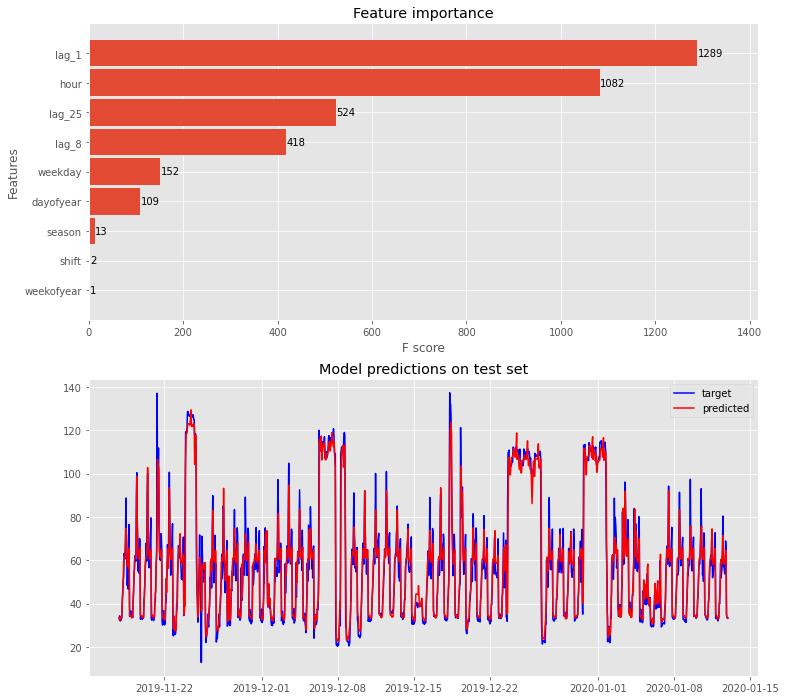

In [91]:
# inverse transform
actual = y_test
predictions = pd.Series(data=predictions, index=y_test.index)
# predictions = transformer.inverse(y_test.index, predictions)
# actual = transformer.inverse(y_test.index, y_test.values)

# plot predictions on the test set
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
_ = xgb.plot_importance(xgb_model, height=0.9, ax=ax1)
ax2.plot(actual, label="target", color="blue")
ax2.plot(predictions, label="predicted", color="red")
ax2.set_title("Model predictions on test set")
ax2.legend()
plt.show()

# store the results
xgb_predictions = predictions.copy()

### Multi-step ahead forecasting with ML

Most of the available material on the Internet stops at this point. The ML model seems to perform well and everyone is happy. However, in time series forecasting problems getting satisfactory results from training and testing is not enough to obtain an actionable outcome. Similarly to standard supervised ML problems, one wants to use the model on unknown data points. In the case of time series problems, the unknown data points are the **future time periods**. The number of time periods to forecast into the future is usually referred to as *forecasting horizon*.

At variance with standard ML where the model can be directly applied to new data, the temporal structure of time series problems makes forecasting, or predicting the several steps ahead in the future, more complicated. In particular, there are several strategies to achieve multi-step forecasting, a good and clear introduction to these methods can be found [here](https://dzone.com/articles/lessons-learnt-while-solving-time-series-forecasti-1). Here we compare two of the most widely used methods for multi-step ahead forecasting, presenting also an implementation for the ML model discussed above. We choose forecasting horizon of 48 time periods which correponds to a 2 days ahead forecasting.

##### Recursive strategy
The recursive forecasting strategy uses only a single model trained for one-step
ahead forecasting. This model is employed to forecast only one-step ahead each time and  the result value of the forecasting is then fed (similarly to a
recursion, hence the name) into the same model to predict the following step and so on and so forth until the desired forecasting horizon is reached.
The recursive strategy is the least expensive method for forecasting since it uses always the same pre-trained model.
However, it is not the best strategy for forecasting long time horizons since it 
accumulates forecasting error at each step ahead. This problem arises because previous forecasts are used to build the feature space for the current time period prediction.

The following code implements recursive strategy for a generic, pre-trained, machine learning model.

In [92]:
# lags used in building the features for the one-step ahead model
feature_lags = [int(f.split("_")[1]) for f in features if "lag" in f]

# target series used for forecasting
fcast_trf = TargetTransformer(log=False, detrend=False)
y = fcast_trf.transform(target.index, target.values)

In [94]:
def forecast_multi_recursive(y, model, lags, n_steps=FCAST_STEPS, step="1H"):
    
    """Multi-step recursive forecasting using the input time 
    series data and a pre-trained machine learning model
    
    Parameters
    ----------
    y: pd.Series holding the input time-series to forecast
    model: an already trained machine learning model implementing the scikit-learn interface
    lags: list of lags used for training the model
    n_steps: number of time periods in the forecasting horizon
    step: forecasting time period given as Pandas time series frequencies
    
    Returns
    -------
    fcast_values: pd.Series with forecasted values indexed by forecast horizon dates 
    """
    
    # get the dates to forecast
    last_date = y.index[-1] + pd.Timedelta(hours=1)
    fcast_range = pd.date_range(last_date, periods=n_steps, freq=step)

    fcasted_values = []
    target = y.copy()

    for date in fcast_range:

        new_point = fcasted_values[-1] if len(fcasted_values) > 0 else 0.0   
        target = target.append(pd.Series(index=[date], data=new_point))

        # forecast
        ts_features = create_ts_features(target)
        if len(lags) > 0:
            lags_features = create_lag_features(target, lags=lags)
            features = ts_features.join(lags_features, how="outer").dropna()
        else:
            features = ts_features
            
        predictions = model.predict(features)
        fcasted_values.append(predictions[-1])

    return pd.Series(index=fcast_range, data=fcasted_values)

rec_fcast = forecast_multi_recursive(y, xgb_model, feature_lags)

##### Direct strategy
The direct forecasting strategy uses a different ML model for each forecasting horizon. More specifically, each model is trained using as target the time series shifted of the desired number of time periods into the future. For example, in order to train a model to forecast 4 time periods ahead into the future, each point in the time series used as target must be 4 steps ahead with respect to the time series used to build the ML model feature set. Notice that the size of the training/cross-validation set decreases of one data point for each additional forecast to perform.
Direct method does not generate error accumulation at each forecast, but it has two main drawbacks:
* it has a high computational cost, especially when dealing with a large forecasting horizons. This issue can be partially cured by running each model in parallel.
* since every time period is predicted with a different model, each model being independent from the others, statistical relationships among predictions cannot be captured with this strategy.

The following code implements direct strategy for a generic machine learning model. The training/cross-validation pipeline for the model must be given as input.

In [95]:
def forecast_multi_direct(y, lags, n_steps=FCAST_STEPS, step="1H", pretrained_m=None, n_evals=25):
    
    """Multi-step direct forecasting using a XGBoost based machine learning model
    to forecast each time period ahead
    
    Parameters
    ----------
    y: pd.Series holding the input time-series to forecast
    lags: list of lags used for training the model
    n_steps: how many steps forecast into the future
    step: the period of forecasting
    pretrained_m: a pretrained one-step ahead model to be used for the first step
                  it must implement the scikit-learn model interface
    n_evals: the number of evaluation in model optimization at each step
    
    Returns
    -------
    fcast_values: pd.Series with forecasted values indexed by forecast horizon dates    
    """
    
    def one_step_features(date, step):

        # features must be obtained using data lagged 
        # by the desired number of steps (the for loop index)
        tmp = y[y.index <= date]       
        lags_features = create_lag_features(tmp, lags=lags)
        ts_features = create_ts_features(tmp)
        features = ts_features.join(lags_features, how="outer").dropna()
        
        # build target to be ahead of the features built 
        # by the desired number of steps (the for loop index)
        target = y[y.index >= features.index[0] + pd.Timedelta(hours=step)]
        assert len(features.index) == len(target.index)
        
        return features, target
        
    fcast_values = []
    fcast_range = pd.date_range(y.index[-1] + pd.Timedelta(hours=1), 
                                periods=n_steps, freq=step)
    fcast_features, _ = one_step_features(y.index[-1], 0)
            
    for s in range(1, n_steps+1):
        
        last_date = y.index[-1] - pd.Timedelta(hours=s)
        features, target = one_step_features(last_date, s)
        
        # train XGBoost model for the current forecasting step
        X_train, X_test, y_train, y_test = train_test_split(features, 
                                                            target, 
                                                            test_size=0.2,
                                                            shuffle=False) 

        y_train_trf = TargetTransformer(log=False, detrend=False)
        y_train = y_train_trf.transform(y_train.index, y_train.values)

        y_test_trf = TargetTransformer(log=False, detrend=False)
        y_test = y_test_trf.transform(y_test.index, y_test.values)        
        
        # use the pretrained model to save one model training
        if s == 1 and pretrained_m is not None:
            model = pretrained_m
        else:
            best, trials = optimize_xgb(X_train, y_train, max_evals=n_evals)
            res = train_xgb(best, X_test, y_test)
            model = res["model"]
                
        # use the model to predict s steps ahead
        predictions = model.predict(fcast_features)        
        fcast_values.append(predictions[-1])
                
    return pd.Series(index=fcast_range, data=fcast_values)
        
dir_fcast = forecast_multi_direct(y, feature_lags, n_evals=25)

  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001636 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  4%|▍         | 1/25 [00:00<00:13,  1.81trial/s, best loss: 21.794340967480178]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001628 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 21.794341


  8%|▊         | 2/25 [00:02<00:20,  1.13trial/s, best loss: 21.63835208267556] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002781 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 21.638352


 12%|█▏        | 3/25 [00:03<00:24,  1.12s/trial, best loss: 21.63835208267556]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001657 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 21.638352


 16%|█▌        | 4/25 [00:05<00:24,  1.17s/trial, best loss: 21.63835208267556]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001918 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 21.638352


 20%|██        | 5/25 [00:06<00:22,  1.11s/trial, best loss: 21.63835208267556]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001645 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 21.638352


 24%|██▍       | 6/25 [00:07<00:19,  1.04s/trial, best loss: 21.63835208267556]

/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001780 seconds
INFO:hyperopt.tpe:TPE using 5/6 trials with best loss 21.638352


 28%|██▊       | 7/25 [00:09<00:25,  1.40s/trial, best loss: 21.63835208267556]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010641 seconds
INFO:hyperopt.tpe:TPE using 6/7 trials with best loss 21.638352


 32%|███▏      | 8/25 [00:10<00:25,  1.49s/trial, best loss: 20.763196677137653]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001852 seconds
INFO:hyperopt.tpe:TPE using 7/8 trials with best loss 20.763197


 36%|███▌      | 9/25 [00:11<00:19,  1.22s/trial, best loss: 20.763196677137653]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001640 seconds
INFO:hyperopt.tpe:TPE using 7/9 trials with best loss 20.763197


 40%|████      | 10/25 [00:12<00:19,  1.28s/trial, best loss: 20.763196677137653]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001786 seconds
INFO:hyperopt.tpe:TPE using 8/10 trials with best loss 20.763197


 44%|████▍     | 11/25 [00:13<00:15,  1.13s/trial, best loss: 20.763196677137653]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001806 seconds
INFO:hyperopt.tpe:TPE using 9/11 trials with best loss 20.763197


 48%|████▊     | 12/25 [00:15<00:17,  1.37s/trial, best loss: 20.763196677137653]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001725 seconds
INFO:hyperopt.tpe:TPE using 10/12 trials with best loss 20.763197


 52%|█████▏    | 13/25 [00:17<00:18,  1.56s/trial, best loss: 20.763196677137653]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009793 seconds
INFO:hyperopt.tpe:TPE using 11/13 trials with best loss 20.763197


 56%|█████▌    | 14/25 [00:18<00:15,  1.38s/trial, best loss: 20.763196677137653]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001637 seconds
INFO:hyperopt.tpe:TPE using 12/14 trials with best loss 20.763197


 60%|██████    | 15/25 [00:19<00:11,  1.14s/trial, best loss: 20.763196677137653]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010468 seconds
INFO:hyperopt.tpe:TPE using 13/15 trials with best loss 20.763197


 64%|██████▍   | 16/25 [00:22<00:16,  1.85s/trial, best loss: 20.763196677137653]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001660 seconds
INFO:hyperopt.tpe:TPE using 14/16 trials with best loss 20.763197


 68%|██████▊   | 17/25 [00:23<00:11,  1.42s/trial, best loss: 20.763196677137653]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001692 seconds
INFO:hyperopt.tpe:TPE using 15/17 trials with best loss 20.763197


 72%|███████▏  | 18/25 [00:26<00:14,  2.12s/trial, best loss: 20.763196677137653]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001644 seconds
INFO:hyperopt.tpe:TPE using 16/18 trials with best loss 20.763197


 76%|███████▌  | 19/25 [00:30<00:15,  2.64s/trial, best loss: 20.763196677137653]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001655 seconds
INFO:hyperopt.tpe:TPE using 17/19 trials with best loss 20.763197


 80%|████████  | 20/25 [00:33<00:13,  2.77s/trial, best loss: 20.763196677137653]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001849 seconds
INFO:hyperopt.tpe:TPE using 18/20 trials with best loss 20.763197


 84%|████████▍ | 21/25 [00:34<00:08,  2.22s/trial, best loss: 20.763196677137653]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001663 seconds
INFO:hyperopt.tpe:TPE using 19/21 trials with best loss 20.763197


 88%|████████▊ | 22/25 [00:36<00:06,  2.05s/trial, best loss: 20.763196677137653]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001795 seconds
INFO:hyperopt.tpe:TPE using 20/22 trials with best loss 20.763197


 92%|█████████▏| 23/25 [00:37<00:03,  1.85s/trial, best loss: 20.763196677137653]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001678 seconds
INFO:hyperopt.tpe:TPE using 21/23 trials with best loss 20.763197


 96%|█████████▌| 24/25 [00:39<00:01,  1.72s/trial, best loss: 20.763196677137653]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001864 seconds
INFO:hyperopt.tpe:TPE using 22/24 trials with best loss 20.763197


100%|██████████| 25/25 [00:41<00:00,  1.64s/trial, best loss: 20.763196677137653]

    Best parameters:
        learning_rate: 0.00803072962639621 
        n_estimators: 890.0
        max_depth: 2.0
        sub_sample: 0.8969191556104035
        gamma: 3.0
    
  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002007 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  4%|▍         | 1/25 [00:02<01:07,  2.82s/trial, best loss: 26.59920670570215]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001625 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 26.599207


  8%|▊         | 2/25 [00:03<00:50,  2.20s/trial, best loss: 25.45802210105345]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001616 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 25.458022


 12%|█▏        | 3/25 [00:05<00:48,  2.22s/trial, best loss: 25.45802210105345]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001623 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 25.458022


 16%|█▌        | 4/25 [00:06<00:35,  1.71s/trial, best loss: 25.319947066388202]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001829 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 25.319947


 20%|██        | 5/25 [00:06<00:27,  1.38s/trial, best loss: 25.319947066388202]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001645 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 25.319947


 24%|██▍       | 6/25 [00:09<00:35,  1.85s/trial, best loss: 25.319947066388202]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.012137 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 25.319947
/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



 28%|██▊       | 7/25 [00:10<00:26,  1.48s/trial, best loss: 25.319947066388202]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001660 seconds
INFO:hyperopt.tpe:TPE using 6/7 trials with best loss 25.319947


 32%|███▏      | 8/25 [00:12<00:30,  1.77s/trial, best loss: 25.319947066388202]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001643 seconds
INFO:hyperopt.tpe:TPE using 7/8 trials with best loss 25.319947


 36%|███▌      | 9/25 [00:14<00:26,  1.66s/trial, best loss: 25.319947066388202]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001709 seconds
INFO:hyperopt.tpe:TPE using 8/9 trials with best loss 25.319947


 40%|████      | 10/25 [00:15<00:23,  1.59s/trial, best loss: 25.319947066388202]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001632 seconds
INFO:hyperopt.tpe:TPE using 9/10 trials with best loss 25.319947


 44%|████▍     | 11/25 [00:19<00:33,  2.36s/trial, best loss: 25.319947066388202]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001645 seconds
INFO:hyperopt.tpe:TPE using 10/11 trials with best loss 25.319947


 48%|████▊     | 12/25 [00:20<00:22,  1.77s/trial, best loss: 23.914090826220157]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001641 seconds
INFO:hyperopt.tpe:TPE using 11/12 trials with best loss 23.914091


 52%|█████▏    | 13/25 [00:20<00:15,  1.33s/trial, best loss: 23.914090826220157]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001641 seconds
INFO:hyperopt.tpe:TPE using 11/13 trials with best loss 23.914091


 56%|█████▌    | 14/25 [00:22<00:16,  1.53s/trial, best loss: 23.914090826220157]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001645 seconds
INFO:hyperopt.tpe:TPE using 12/14 trials with best loss 23.914091


 60%|██████    | 15/25 [00:23<00:13,  1.35s/trial, best loss: 23.914090826220157]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001636 seconds
INFO:hyperopt.tpe:TPE using 13/15 trials with best loss 23.914091


 64%|██████▍   | 16/25 [00:28<00:21,  2.36s/trial, best loss: 23.914090826220157]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001734 seconds
INFO:hyperopt.tpe:TPE using 14/16 trials with best loss 23.914091


 68%|██████▊   | 17/25 [00:30<00:18,  2.28s/trial, best loss: 23.914090826220157]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008269 seconds
INFO:hyperopt.tpe:TPE using 15/17 trials with best loss 23.914091


 72%|███████▏  | 18/25 [00:31<00:13,  1.88s/trial, best loss: 23.656906414206475]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001635 seconds
INFO:hyperopt.tpe:TPE using 16/18 trials with best loss 23.656906


 76%|███████▌  | 19/25 [00:32<00:09,  1.61s/trial, best loss: 23.656906414206475]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001634 seconds
INFO:hyperopt.tpe:TPE using 17/19 trials with best loss 23.656906


 80%|████████  | 20/25 [00:32<00:06,  1.28s/trial, best loss: 23.656906414206475]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001640 seconds
INFO:hyperopt.tpe:TPE using 17/20 trials with best loss 23.656906


 84%|████████▍ | 21/25 [00:34<00:05,  1.32s/trial, best loss: 23.656906414206475]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001629 seconds
INFO:hyperopt.tpe:TPE using 18/21 trials with best loss 23.656906


 88%|████████▊ | 22/25 [00:37<00:05,  1.93s/trial, best loss: 23.656906414206475]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001653 seconds
INFO:hyperopt.tpe:TPE using 19/22 trials with best loss 23.656906


 92%|█████████▏| 23/25 [00:40<00:04,  2.20s/trial, best loss: 23.656906414206475]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001648 seconds
INFO:hyperopt.tpe:TPE using 20/23 trials with best loss 23.656906


 96%|█████████▌| 24/25 [00:42<00:02,  2.25s/trial, best loss: 23.656906414206475]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001619 seconds
INFO:hyperopt.tpe:TPE using 21/24 trials with best loss 23.656906


100%|██████████| 25/25 [00:43<00:00,  1.74s/trial, best loss: 23.656906414206475]

    Best parameters:
        learning_rate: 0.012627129058122468 
        n_estimators: 330.0
        max_depth: 3.0
        sub_sample: 0.8016807336914236
        gamma: 78.0
    
  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002162 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  4%|▍         | 1/25 [00:05<02:07,  5.30s/trial, best loss: 26.569972139417576]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.049126 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 26.569972


  8%|▊         | 2/25 [00:06<01:36,  4.18s/trial, best loss: 26.569972139417576]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001650 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 26.569972


 12%|█▏        | 3/25 [00:07<01:09,  3.15s/trial, best loss: 26.569972139417576]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001637 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 26.569972
/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



 16%|█▌        | 4/25 [00:08<00:53,  2.53s/trial, best loss: 26.569972139417576]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001617 seconds
INFO:hyperopt.tpe:TPE using 3/4 trials with best loss 26.569972


 20%|██        | 5/25 [00:10<00:43,  2.17s/trial, best loss: 26.569972139417576]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001635 seconds
INFO:hyperopt.tpe:TPE using 4/5 trials with best loss 26.569972


 24%|██▍       | 6/25 [00:11<00:34,  1.83s/trial, best loss: 26.569972139417576]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001657 seconds
INFO:hyperopt.tpe:TPE using 4/6 trials with best loss 26.569972


 28%|██▊       | 7/25 [00:13<00:33,  1.88s/trial, best loss: 25.065148419503554]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001613 seconds
INFO:hyperopt.tpe:TPE using 5/7 trials with best loss 25.065148


 32%|███▏      | 8/25 [00:15<00:35,  2.06s/trial, best loss: 25.065148419503554]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002045 seconds
INFO:hyperopt.tpe:TPE using 6/8 trials with best loss 25.065148


 36%|███▌      | 9/25 [00:17<00:31,  1.98s/trial, best loss: 25.065148419503554]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001614 seconds
INFO:hyperopt.tpe:TPE using 7/9 trials with best loss 25.065148


 40%|████      | 10/25 [00:20<00:35,  2.34s/trial, best loss: 25.065148419503554]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001625 seconds
INFO:hyperopt.tpe:TPE using 8/10 trials with best loss 25.065148


 44%|████▍     | 11/25 [00:21<00:26,  1.88s/trial, best loss: 25.065148419503554]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001623 seconds
INFO:hyperopt.tpe:TPE using 9/11 trials with best loss 25.065148


 48%|████▊     | 12/25 [00:22<00:22,  1.71s/trial, best loss: 25.065148419503554]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001615 seconds
INFO:hyperopt.tpe:TPE using 10/12 trials with best loss 25.065148


 52%|█████▏    | 13/25 [00:26<00:28,  2.35s/trial, best loss: 25.065148419503554]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001729 seconds
INFO:hyperopt.tpe:TPE using 11/13 trials with best loss 25.065148


 56%|█████▌    | 14/25 [00:28<00:25,  2.31s/trial, best loss: 25.065148419503554]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001634 seconds
INFO:hyperopt.tpe:TPE using 12/14 trials with best loss 25.065148


 60%|██████    | 15/25 [00:30<00:20,  2.02s/trial, best loss: 25.065148419503554]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001632 seconds
INFO:hyperopt.tpe:TPE using 13/15 trials with best loss 25.065148


 64%|██████▍   | 16/25 [00:33<00:21,  2.44s/trial, best loss: 25.065148419503554]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001635 seconds
INFO:hyperopt.tpe:TPE using 14/16 trials with best loss 25.065148


 68%|██████▊   | 17/25 [00:35<00:18,  2.31s/trial, best loss: 25.065148419503554]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001649 seconds
INFO:hyperopt.tpe:TPE using 15/17 trials with best loss 25.065148


 72%|███████▏  | 18/25 [00:36<00:14,  2.00s/trial, best loss: 25.065148419503554]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001619 seconds
INFO:hyperopt.tpe:TPE using 16/18 trials with best loss 25.065148


 76%|███████▌  | 19/25 [00:37<00:09,  1.56s/trial, best loss: 25.065148419503554]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001632 seconds
INFO:hyperopt.tpe:TPE using 17/19 trials with best loss 25.065148


 80%|████████  | 20/25 [00:38<00:07,  1.54s/trial, best loss: 24.509217534894773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002090 seconds
INFO:hyperopt.tpe:TPE using 18/20 trials with best loss 24.509218


 84%|████████▍ | 21/25 [00:42<00:08,  2.07s/trial, best loss: 24.509217534894773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001638 seconds
INFO:hyperopt.tpe:TPE using 19/21 trials with best loss 24.509218


 88%|████████▊ | 22/25 [00:45<00:07,  2.51s/trial, best loss: 24.509217534894773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001658 seconds
INFO:hyperopt.tpe:TPE using 20/22 trials with best loss 24.509218


 92%|█████████▏| 23/25 [00:46<00:04,  2.13s/trial, best loss: 24.509217534894773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001641 seconds
INFO:hyperopt.tpe:TPE using 21/23 trials with best loss 24.509218


 96%|█████████▌| 24/25 [00:47<00:01,  1.81s/trial, best loss: 24.509217534894773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001629 seconds
INFO:hyperopt.tpe:TPE using 22/24 trials with best loss 24.509218


100%|██████████| 25/25 [00:48<00:00,  1.95s/trial, best loss: 24.509217534894773]

    Best parameters:
        learning_rate: 0.01573865246516346 
        n_estimators: 590.0
        max_depth: 3.0
        sub_sample: 0.9170100027346971
        gamma: 93.0
    
  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001520 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  4%|▍         | 1/25 [00:00<00:23,  1.02trial/s, best loss: 27.892029440582245]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001642 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 27.892029


  8%|▊         | 2/25 [00:03<00:31,  1.36s/trial, best loss: 26.959495056864817]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001643 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 26.959495


 12%|█▏        | 3/25 [00:04<00:29,  1.33s/trial, best loss: 26.959495056864817]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001655 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 26.959495


 16%|█▌        | 4/25 [00:08<00:42,  2.01s/trial, best loss: 26.959495056864817]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001629 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 26.959495


 20%|██        | 5/25 [00:10<00:39,  1.99s/trial, best loss: 26.959495056864817]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001636 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 26.959495


 24%|██▍       | 6/25 [00:12<00:41,  2.20s/trial, best loss: 26.712783344448816]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.011560 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 26.712783


 28%|██▊       | 7/25 [00:14<00:37,  2.09s/trial, best loss: 26.712783344448816]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001623 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 26.712783


 32%|███▏      | 8/25 [00:16<00:34,  2.06s/trial, best loss: 26.712783344448816]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001632 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 26.712783


 36%|███▌      | 9/25 [00:18<00:32,  2.05s/trial, best loss: 26.712783344448816]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001859 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 26.712783


 40%|████      | 10/25 [00:19<00:25,  1.73s/trial, best loss: 26.712783344448816]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001631 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss 26.712783


 44%|████▍     | 11/25 [00:21<00:23,  1.68s/trial, best loss: 26.712783344448816]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.011200 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss 26.712783


 48%|████▊     | 12/25 [00:24<00:28,  2.17s/trial, best loss: 26.712783344448816]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001619 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss 26.712783


 52%|█████▏    | 13/25 [00:24<00:19,  1.65s/trial, best loss: 25.485046264456642]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001629 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss 25.485046


 56%|█████▌    | 14/25 [00:26<00:18,  1.71s/trial, best loss: 25.485046264456642]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001973 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss 25.485046


 60%|██████    | 15/25 [00:32<00:30,  3.05s/trial, best loss: 25.485046264456642]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001789 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss 25.485046


 64%|██████▍   | 16/25 [00:38<00:34,  3.87s/trial, best loss: 25.485046264456642]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001659 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss 25.485046


 68%|██████▊   | 17/25 [00:39<00:24,  3.06s/trial, best loss: 25.485046264456642]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001633 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss 25.485046


 72%|███████▏  | 18/25 [00:40<00:16,  2.31s/trial, best loss: 25.485046264456642]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001694 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss 25.485046


 76%|███████▌  | 19/25 [00:41<00:11,  1.93s/trial, best loss: 25.485046264456642]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003803 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss 25.485046


 80%|████████  | 20/25 [00:45<00:13,  2.62s/trial, best loss: 25.485046264456642]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001635 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss 25.485046
/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



 84%|████████▍ | 21/25 [00:45<00:07,  1.90s/trial, best loss: 25.485046264456642]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001690 seconds
INFO:hyperopt.tpe:TPE using 20/21 trials with best loss 25.485046


 88%|████████▊ | 22/25 [00:46<00:04,  1.40s/trial, best loss: 25.485046264456642]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001611 seconds
INFO:hyperopt.tpe:TPE using 21/22 trials with best loss 25.485046


 92%|█████████▏| 23/25 [00:46<00:02,  1.20s/trial, best loss: 25.485046264456642]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001683 seconds
INFO:hyperopt.tpe:TPE using 22/23 trials with best loss 25.485046


 96%|█████████▌| 24/25 [00:50<00:01,  1.83s/trial, best loss: 25.485046264456642]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001824 seconds
INFO:hyperopt.tpe:TPE using 23/24 trials with best loss 25.485046


100%|██████████| 25/25 [00:50<00:00,  2.02s/trial, best loss: 25.485046264456642]

    Best parameters:
        learning_rate: 0.040731240943845386 
        n_estimators: 100.0
        max_depth: 3.0
        sub_sample: 0.9098103449939333
        gamma: 70.0
    
  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001596 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  4%|▍         | 1/25 [00:01<00:31,  1.32s/trial, best loss: 27.254229947631607]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001632 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 27.254230


  8%|▊         | 2/25 [00:04<00:40,  1.78s/trial, best loss: 27.254229947631607]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001793 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 27.254230


 12%|█▏        | 3/25 [00:06<00:44,  2.04s/trial, best loss: 27.254229947631607]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001656 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 27.254230


 16%|█▌        | 4/25 [00:07<00:35,  1.70s/trial, best loss: 27.254229947631607]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001625 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 27.254230


 20%|██        | 5/25 [00:10<00:38,  1.93s/trial, best loss: 26.996774657239406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001954 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 26.996775


 24%|██▍       | 6/25 [00:11<00:32,  1.70s/trial, best loss: 26.996774657239406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001676 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 26.996775


 28%|██▊       | 7/25 [00:16<00:46,  2.59s/trial, best loss: 26.996774657239406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001665 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 26.996775


 32%|███▏      | 8/25 [00:17<00:35,  2.12s/trial, best loss: 26.996774657239406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001657 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 26.996775


 36%|███▌      | 9/25 [00:20<00:38,  2.39s/trial, best loss: 26.996774657239406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001671 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 26.996775
/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



 40%|████      | 10/25 [00:20<00:27,  1.85s/trial, best loss: 26.996774657239406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001649 seconds
INFO:hyperopt.tpe:TPE using 9/10 trials with best loss 26.996775


 44%|████▍     | 11/25 [00:24<00:33,  2.37s/trial, best loss: 26.996774657239406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001649 seconds
INFO:hyperopt.tpe:TPE using 10/11 trials with best loss 26.996775


 48%|████▊     | 12/25 [00:25<00:28,  2.16s/trial, best loss: 26.996774657239406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001725 seconds
INFO:hyperopt.tpe:TPE using 11/12 trials with best loss 26.996775


 52%|█████▏    | 13/25 [00:30<00:32,  2.74s/trial, best loss: 26.996774657239406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001666 seconds
INFO:hyperopt.tpe:TPE using 12/13 trials with best loss 26.996775


 56%|█████▌    | 14/25 [00:32<00:30,  2.81s/trial, best loss: 26.996774657239406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001678 seconds
INFO:hyperopt.tpe:TPE using 13/14 trials with best loss 26.996775


 60%|██████    | 15/25 [00:35<00:28,  2.82s/trial, best loss: 26.996774657239406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001637 seconds
INFO:hyperopt.tpe:TPE using 14/15 trials with best loss 26.996775


 64%|██████▍   | 16/25 [00:39<00:27,  3.03s/trial, best loss: 26.996774657239406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001638 seconds
INFO:hyperopt.tpe:TPE using 15/16 trials with best loss 26.996775


 68%|██████▊   | 17/25 [00:40<00:20,  2.54s/trial, best loss: 26.996774657239406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001710 seconds
INFO:hyperopt.tpe:TPE using 16/17 trials with best loss 26.996775


 72%|███████▏  | 18/25 [00:42<00:15,  2.23s/trial, best loss: 26.996774657239406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001695 seconds
INFO:hyperopt.tpe:TPE using 17/18 trials with best loss 26.996775


 76%|███████▌  | 19/25 [00:42<00:10,  1.74s/trial, best loss: 26.1260284013427]  

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001682 seconds
INFO:hyperopt.tpe:TPE using 18/19 trials with best loss 26.126028


 80%|████████  | 20/25 [00:44<00:07,  1.58s/trial, best loss: 26.1260284013427]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001692 seconds
INFO:hyperopt.tpe:TPE using 19/20 trials with best loss 26.126028


 84%|████████▍ | 21/25 [00:45<00:06,  1.61s/trial, best loss: 26.1260284013427]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001701 seconds
INFO:hyperopt.tpe:TPE using 20/21 trials with best loss 26.126028


 88%|████████▊ | 22/25 [00:46<00:03,  1.22s/trial, best loss: 26.1260284013427]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001652 seconds
INFO:hyperopt.tpe:TPE using 21/22 trials with best loss 26.126028


 92%|█████████▏| 23/25 [00:46<00:01,  1.05trial/s, best loss: 26.1260284013427]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001655 seconds
INFO:hyperopt.tpe:TPE using 22/23 trials with best loss 26.126028


 96%|█████████▌| 24/25 [00:46<00:00,  1.32trial/s, best loss: 26.1260284013427]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001643 seconds
INFO:hyperopt.tpe:TPE using 23/24 trials with best loss 26.126028


100%|██████████| 25/25 [00:47<00:00,  1.88s/trial, best loss: 26.1260284013427]

    Best parameters:
        learning_rate: 0.01932775164350279 
        n_estimators: 280.0
        max_depth: 2.0
        sub_sample: 0.9629112973378876
        gamma: 48.0
    
  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001803 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  4%|▍         | 1/25 [00:01<00:41,  1.72s/trial, best loss: 93.36154063313205]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001850 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 93.361541


  8%|▊         | 2/25 [00:03<00:39,  1.74s/trial, best loss: 30.903012759177436]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001835 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 30.903013


 12%|█▏        | 3/25 [00:04<00:35,  1.61s/trial, best loss: 30.903012759177436]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001626 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 30.903013
/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



 16%|█▌        | 4/25 [00:05<00:27,  1.30s/trial, best loss: 30.903012759177436]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.011155 seconds
INFO:hyperopt.tpe:TPE using 3/4 trials with best loss 30.903013


 20%|██        | 5/25 [00:06<00:22,  1.14s/trial, best loss: 30.903012759177436]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001667 seconds
INFO:hyperopt.tpe:TPE using 4/5 trials with best loss 30.903013


 24%|██▍       | 6/25 [00:08<00:30,  1.62s/trial, best loss: 30.903012759177436]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001848 seconds
INFO:hyperopt.tpe:TPE using 5/6 trials with best loss 30.903013


 28%|██▊       | 7/25 [00:10<00:30,  1.68s/trial, best loss: 30.903012759177436]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001625 seconds
INFO:hyperopt.tpe:TPE using 6/7 trials with best loss 30.903013


 32%|███▏      | 8/25 [00:13<00:34,  2.01s/trial, best loss: 30.903012759177436]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001717 seconds
INFO:hyperopt.tpe:TPE using 7/8 trials with best loss 30.903013


 36%|███▌      | 9/25 [00:15<00:33,  2.11s/trial, best loss: 30.903012759177436]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001710 seconds
INFO:hyperopt.tpe:TPE using 8/9 trials with best loss 30.903013


 40%|████      | 10/25 [00:17<00:28,  1.87s/trial, best loss: 30.903012759177436]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001630 seconds
INFO:hyperopt.tpe:TPE using 9/10 trials with best loss 30.903013


 44%|████▍     | 11/25 [00:20<00:34,  2.45s/trial, best loss: 30.903012759177436]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001685 seconds
INFO:hyperopt.tpe:TPE using 10/11 trials with best loss 30.903013


 48%|████▊     | 12/25 [00:21<00:24,  1.86s/trial, best loss: 30.380519623054802]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001623 seconds
INFO:hyperopt.tpe:TPE using 11/12 trials with best loss 30.380520


 52%|█████▏    | 13/25 [00:22<00:18,  1.55s/trial, best loss: 30.380519623054802]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001702 seconds
INFO:hyperopt.tpe:TPE using 12/13 trials with best loss 30.380520


 56%|█████▌    | 14/25 [00:25<00:21,  1.95s/trial, best loss: 30.380519623054802]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001642 seconds
INFO:hyperopt.tpe:TPE using 13/14 trials with best loss 30.380520


 60%|██████    | 15/25 [00:26<00:19,  1.90s/trial, best loss: 30.380519623054802]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001620 seconds
INFO:hyperopt.tpe:TPE using 14/15 trials with best loss 30.380520


 64%|██████▍   | 16/25 [00:30<00:22,  2.49s/trial, best loss: 30.380519623054802]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002009 seconds
INFO:hyperopt.tpe:TPE using 15/16 trials with best loss 30.380520


 68%|██████▊   | 17/25 [00:33<00:19,  2.44s/trial, best loss: 30.380519623054802]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001686 seconds
INFO:hyperopt.tpe:TPE using 16/17 trials with best loss 30.380520


 72%|███████▏  | 18/25 [00:35<00:17,  2.49s/trial, best loss: 30.380519623054802]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001661 seconds
INFO:hyperopt.tpe:TPE using 17/18 trials with best loss 30.380520


 76%|███████▌  | 19/25 [00:38<00:15,  2.62s/trial, best loss: 30.380519623054802]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001649 seconds
INFO:hyperopt.tpe:TPE using 18/19 trials with best loss 30.380520


 80%|████████  | 20/25 [00:41<00:13,  2.62s/trial, best loss: 30.380519623054802]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001773 seconds
INFO:hyperopt.tpe:TPE using 19/20 trials with best loss 30.380520


 84%|████████▍ | 21/25 [00:44<00:11,  2.83s/trial, best loss: 30.380519623054802]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002942 seconds
INFO:hyperopt.tpe:TPE using 20/21 trials with best loss 30.380520


 88%|████████▊ | 22/25 [00:44<00:06,  2.04s/trial, best loss: 30.380519623054802]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001648 seconds
INFO:hyperopt.tpe:TPE using 20/22 trials with best loss 30.380520


 92%|█████████▏| 23/25 [00:45<00:03,  1.50s/trial, best loss: 30.380519623054802]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.013563 seconds
INFO:hyperopt.tpe:TPE using 20/23 trials with best loss 30.380520


 96%|█████████▌| 24/25 [00:46<00:01,  1.36s/trial, best loss: 30.380519623054802]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002956 seconds
INFO:hyperopt.tpe:TPE using 21/24 trials with best loss 30.380520


100%|██████████| 25/25 [00:46<00:00,  1.85s/trial, best loss: 30.380519623054802]

    Best parameters:
        learning_rate: 0.05902658941957538 
        n_estimators: 220.0
        max_depth: 2.0
        sub_sample: 0.9704177558724267
        gamma: 17.0
    
  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001685 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  4%|▍         | 1/25 [00:00<00:18,  1.30trial/s, best loss: 31.823328431261366]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001689 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 31.823328


  8%|▊         | 2/25 [00:01<00:18,  1.27trial/s, best loss: 30.004367734932117]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001727 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 30.004368


 12%|█▏        | 3/25 [00:03<00:23,  1.05s/trial, best loss: 30.004367734932117]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001744 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 30.004368


 16%|█▌        | 4/25 [00:04<00:22,  1.06s/trial, best loss: 30.004367734932117]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001729 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 30.004368
/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



 20%|██        | 5/25 [00:05<00:20,  1.05s/trial, best loss: 30.004367734932117]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001633 seconds
INFO:hyperopt.tpe:TPE using 4/5 trials with best loss 30.004368


 24%|██▍       | 6/25 [00:08<00:29,  1.54s/trial, best loss: 30.004367734932117]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001653 seconds
INFO:hyperopt.tpe:TPE using 5/6 trials with best loss 30.004368


 28%|██▊       | 7/25 [00:09<00:28,  1.56s/trial, best loss: 30.004367734932117]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001638 seconds
INFO:hyperopt.tpe:TPE using 6/7 trials with best loss 30.004368


 32%|███▏      | 8/25 [00:10<00:22,  1.34s/trial, best loss: 30.004367734932117]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001642 seconds
INFO:hyperopt.tpe:TPE using 7/8 trials with best loss 30.004368


 36%|███▌      | 9/25 [00:11<00:20,  1.28s/trial, best loss: 30.004367734932117]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001855 seconds
INFO:hyperopt.tpe:TPE using 8/9 trials with best loss 30.004368


 40%|████      | 10/25 [00:14<00:25,  1.69s/trial, best loss: 30.004367734932117]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001643 seconds
INFO:hyperopt.tpe:TPE using 9/10 trials with best loss 30.004368


 44%|████▍     | 11/25 [00:18<00:36,  2.59s/trial, best loss: 30.004367734932117]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001656 seconds
INFO:hyperopt.tpe:TPE using 10/11 trials with best loss 30.004368


 48%|████▊     | 12/25 [00:19<00:26,  2.05s/trial, best loss: 30.004367734932117]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002892 seconds
INFO:hyperopt.tpe:TPE using 11/12 trials with best loss 30.004368


 52%|█████▏    | 13/25 [00:22<00:28,  2.34s/trial, best loss: 30.004367734932117]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001645 seconds
INFO:hyperopt.tpe:TPE using 12/13 trials with best loss 30.004368


 56%|█████▌    | 14/25 [00:23<00:19,  1.75s/trial, best loss: 30.004367734932117]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001645 seconds
INFO:hyperopt.tpe:TPE using 13/14 trials with best loss 30.004368


 60%|██████    | 15/25 [00:23<00:13,  1.35s/trial, best loss: 30.004367734932117]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001649 seconds
INFO:hyperopt.tpe:TPE using 13/15 trials with best loss 30.004368


 64%|██████▍   | 16/25 [00:24<00:11,  1.29s/trial, best loss: 30.004367734932117]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001647 seconds
INFO:hyperopt.tpe:TPE using 14/16 trials with best loss 30.004368


 68%|██████▊   | 17/25 [00:25<00:08,  1.03s/trial, best loss: 30.004367734932117]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001680 seconds
INFO:hyperopt.tpe:TPE using 15/17 trials with best loss 30.004368


 72%|███████▏  | 18/25 [00:27<00:10,  1.54s/trial, best loss: 30.004367734932117]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001976 seconds
INFO:hyperopt.tpe:TPE using 16/18 trials with best loss 30.004368


 76%|███████▌  | 19/25 [00:32<00:14,  2.37s/trial, best loss: 30.004367734932117]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001773 seconds
INFO:hyperopt.tpe:TPE using 17/19 trials with best loss 30.004368


 80%|████████  | 20/25 [00:33<00:10,  2.04s/trial, best loss: 30.004367734932117]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001684 seconds
INFO:hyperopt.tpe:TPE using 18/20 trials with best loss 30.004368


 84%|████████▍ | 21/25 [00:33<00:06,  1.57s/trial, best loss: 30.004367734932117]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001776 seconds
INFO:hyperopt.tpe:TPE using 19/21 trials with best loss 30.004368


 88%|████████▊ | 22/25 [00:37<00:06,  2.25s/trial, best loss: 30.004367734932117]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001660 seconds
INFO:hyperopt.tpe:TPE using 20/22 trials with best loss 30.004368


 92%|█████████▏| 23/25 [00:38<00:03,  1.72s/trial, best loss: 30.004367734932117]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001647 seconds
INFO:hyperopt.tpe:TPE using 21/23 trials with best loss 30.004368


 96%|█████████▌| 24/25 [00:39<00:01,  1.51s/trial, best loss: 30.004367734932117]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001726 seconds
INFO:hyperopt.tpe:TPE using 22/24 trials with best loss 30.004368


100%|██████████| 25/25 [00:40<00:00,  1.61s/trial, best loss: 30.004367734932117]

    Best parameters:
        learning_rate: 0.009049441442865166 
        n_estimators: 440.0
        max_depth: 1.0
        sub_sample: 0.9441516279611026
        gamma: 33.0
    
  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001680 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  4%|▍         | 1/25 [00:05<02:03,  5.17s/trial, best loss: 33.71496807972066]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001638 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 33.714968


  8%|▊         | 2/25 [00:08<01:46,  4.63s/trial, best loss: 33.71496807972066]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001655 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 33.714968


 12%|█▏        | 3/25 [00:08<01:13,  3.36s/trial, best loss: 33.22587915960358]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.016211 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 33.225879


 16%|█▌        | 4/25 [00:10<01:02,  2.96s/trial, best loss: 33.10256201770177]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001643 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 33.102562


 20%|██        | 5/25 [00:16<01:11,  3.59s/trial, best loss: 33.10256201770177]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001963 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 33.102562


 24%|██▍       | 6/25 [00:18<01:03,  3.32s/trial, best loss: 33.10256201770177]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001626 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 33.102562


 28%|██▊       | 7/25 [00:20<00:53,  2.96s/trial, best loss: 33.10256201770177]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001686 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 33.102562


 32%|███▏      | 8/25 [00:22<00:44,  2.63s/trial, best loss: 32.49100326052378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001656 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 32.491003


 36%|███▌      | 9/25 [00:24<00:38,  2.38s/trial, best loss: 32.49100326052378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001719 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 32.491003


 40%|████      | 10/25 [00:25<00:27,  1.82s/trial, best loss: 32.49100326052378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001633 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss 32.491003


 44%|████▍     | 11/25 [00:26<00:24,  1.72s/trial, best loss: 32.49100326052378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.011159 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss 32.491003


 48%|████▊     | 12/25 [00:30<00:29,  2.30s/trial, best loss: 32.49100326052378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001660 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss 32.491003


 52%|█████▏    | 13/25 [00:30<00:20,  1.73s/trial, best loss: 32.49100326052378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001936 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss 32.491003


 56%|█████▌    | 14/25 [00:33<00:21,  1.95s/trial, best loss: 32.49100326052378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001659 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss 32.491003


 60%|██████    | 15/25 [00:33<00:15,  1.55s/trial, best loss: 32.49100326052378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001637 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss 32.491003


 64%|██████▍   | 16/25 [00:36<00:18,  2.03s/trial, best loss: 32.49100326052378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001641 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss 32.491003


 68%|██████▊   | 17/25 [00:37<00:13,  1.73s/trial, best loss: 32.49100326052378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001805 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss 32.491003


 72%|███████▏  | 18/25 [00:39<00:12,  1.82s/trial, best loss: 32.49100326052378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001631 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss 32.491003
/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



 76%|███████▌  | 19/25 [00:40<00:09,  1.57s/trial, best loss: 32.49100326052378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002017 seconds
INFO:hyperopt.tpe:TPE using 18/19 trials with best loss 32.491003


 80%|████████  | 20/25 [00:43<00:09,  1.86s/trial, best loss: 32.49100326052378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001654 seconds
INFO:hyperopt.tpe:TPE using 19/20 trials with best loss 32.491003


 84%|████████▍ | 21/25 [00:44<00:06,  1.66s/trial, best loss: 32.49100326052378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001621 seconds
INFO:hyperopt.tpe:TPE using 20/21 trials with best loss 32.491003


 88%|████████▊ | 22/25 [00:45<00:04,  1.39s/trial, best loss: 32.49100326052378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001658 seconds
INFO:hyperopt.tpe:TPE using 21/22 trials with best loss 32.491003


 92%|█████████▏| 23/25 [00:47<00:03,  1.57s/trial, best loss: 32.49100326052378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001650 seconds
INFO:hyperopt.tpe:TPE using 22/23 trials with best loss 32.491003


 96%|█████████▌| 24/25 [00:49<00:01,  1.66s/trial, best loss: 31.94793990385536]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001627 seconds
INFO:hyperopt.tpe:TPE using 23/24 trials with best loss 31.947940


100%|██████████| 25/25 [00:50<00:00,  2.02s/trial, best loss: 31.94793990385536]

    Best parameters:
        learning_rate: 0.007240777900934106 
        n_estimators: 540.0
        max_depth: 3.0
        sub_sample: 0.8166722561026004
        gamma: 97.0
    
  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001980 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  4%|▍         | 1/25 [00:04<01:39,  4.13s/trial, best loss: 35.139093311939384]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002086 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 35.139093


  8%|▊         | 2/25 [00:07<01:30,  3.92s/trial, best loss: 35.07824235295245] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001666 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 35.078242


 12%|█▏        | 3/25 [00:10<01:21,  3.72s/trial, best loss: 35.07824235295245]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001623 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 35.078242


 16%|█▌        | 4/25 [00:11<01:01,  2.94s/trial, best loss: 31.67196609501401]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001634 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 31.671966
/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



 20%|██        | 5/25 [00:13<00:50,  2.52s/trial, best loss: 31.67196609501401]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001650 seconds
INFO:hyperopt.tpe:TPE using 4/5 trials with best loss 31.671966


 24%|██▍       | 6/25 [00:16<00:48,  2.57s/trial, best loss: 31.67196609501401]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002476 seconds
INFO:hyperopt.tpe:TPE using 5/6 trials with best loss 31.671966


 28%|██▊       | 7/25 [00:18<00:45,  2.55s/trial, best loss: 31.405853074364426]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001665 seconds
INFO:hyperopt.tpe:TPE using 6/7 trials with best loss 31.405853


 32%|███▏      | 8/25 [00:21<00:44,  2.64s/trial, best loss: 31.405853074364426]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001654 seconds
INFO:hyperopt.tpe:TPE using 7/8 trials with best loss 31.405853


 36%|███▌      | 9/25 [00:24<00:42,  2.68s/trial, best loss: 31.405853074364426]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001652 seconds
INFO:hyperopt.tpe:TPE using 8/9 trials with best loss 31.405853


 40%|████      | 10/25 [00:27<00:42,  2.82s/trial, best loss: 31.405853074364426]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010127 seconds
INFO:hyperopt.tpe:TPE using 9/10 trials with best loss 31.405853


 44%|████▍     | 11/25 [00:28<00:33,  2.40s/trial, best loss: 31.405853074364426]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001631 seconds
INFO:hyperopt.tpe:TPE using 10/11 trials with best loss 31.405853


 48%|████▊     | 12/25 [00:30<00:27,  2.13s/trial, best loss: 31.405853074364426]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.015521 seconds
INFO:hyperopt.tpe:TPE using 11/12 trials with best loss 31.405853


 52%|█████▏    | 13/25 [00:30<00:19,  1.64s/trial, best loss: 31.405853074364426]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001751 seconds
INFO:hyperopt.tpe:TPE using 12/13 trials with best loss 31.405853


 56%|█████▌    | 14/25 [00:31<00:14,  1.29s/trial, best loss: 31.405853074364426]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001633 seconds
INFO:hyperopt.tpe:TPE using 13/14 trials with best loss 31.405853


 60%|██████    | 15/25 [00:32<00:13,  1.36s/trial, best loss: 31.405853074364426]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001652 seconds
INFO:hyperopt.tpe:TPE using 14/15 trials with best loss 31.405853


 64%|██████▍   | 16/25 [00:33<00:10,  1.22s/trial, best loss: 31.405853074364426]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001633 seconds
INFO:hyperopt.tpe:TPE using 15/16 trials with best loss 31.405853


 68%|██████▊   | 17/25 [00:34<00:08,  1.05s/trial, best loss: 31.403557256930952]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001629 seconds
INFO:hyperopt.tpe:TPE using 16/17 trials with best loss 31.403557


 72%|███████▏  | 18/25 [00:35<00:07,  1.07s/trial, best loss: 31.403557256930952]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001634 seconds
INFO:hyperopt.tpe:TPE using 17/18 trials with best loss 31.403557


 76%|███████▌  | 19/25 [00:37<00:08,  1.34s/trial, best loss: 31.403557256930952]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001642 seconds
INFO:hyperopt.tpe:TPE using 18/19 trials with best loss 31.403557


 80%|████████  | 20/25 [00:40<00:08,  1.78s/trial, best loss: 31.403557256930952]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001661 seconds
INFO:hyperopt.tpe:TPE using 19/20 trials with best loss 31.403557


 84%|████████▍ | 21/25 [00:42<00:07,  1.76s/trial, best loss: 31.403557256930952]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001642 seconds
INFO:hyperopt.tpe:TPE using 20/21 trials with best loss 31.403557


 88%|████████▊ | 22/25 [00:44<00:05,  1.95s/trial, best loss: 31.403557256930952]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001654 seconds
INFO:hyperopt.tpe:TPE using 21/22 trials with best loss 31.403557


 92%|█████████▏| 23/25 [00:45<00:03,  1.57s/trial, best loss: 31.403557256930952]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001650 seconds
INFO:hyperopt.tpe:TPE using 22/23 trials with best loss 31.403557


 96%|█████████▌| 24/25 [00:47<00:01,  1.71s/trial, best loss: 31.403557256930952]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001647 seconds
INFO:hyperopt.tpe:TPE using 23/24 trials with best loss 31.403557


100%|██████████| 25/25 [00:47<00:00,  1.92s/trial, best loss: 31.403557256930952]

    Best parameters:
        learning_rate: 0.009985018786459014 
        n_estimators: 330.0
        max_depth: 2.0
        sub_sample: 0.9385149168171214
        gamma: 6.0
    
  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001521 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  4%|▍         | 1/25 [00:00<00:15,  1.54trial/s, best loss: 38.886687755320985]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001649 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 38.886688


  8%|▊         | 2/25 [00:02<00:24,  1.08s/trial, best loss: 36.71106056754872] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001655 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 36.711061


 12%|█▏        | 3/25 [00:05<00:35,  1.62s/trial, best loss: 29.606222286900664]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001649 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 29.606222


 16%|█▌        | 4/25 [00:07<00:38,  1.82s/trial, best loss: 29.606222286900664]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010894 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 29.606222


 20%|██        | 5/25 [00:10<00:42,  2.13s/trial, best loss: 29.606222286900664]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001662 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 29.606222
/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



 24%|██▍       | 6/25 [00:11<00:34,  1.83s/trial, best loss: 29.606222286900664]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001696 seconds
INFO:hyperopt.tpe:TPE using 5/6 trials with best loss 29.606222


 28%|██▊       | 7/25 [00:12<00:25,  1.43s/trial, best loss: 29.606222286900664]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009889 seconds
INFO:hyperopt.tpe:TPE using 6/7 trials with best loss 29.606222


 32%|███▏      | 8/25 [00:13<00:21,  1.24s/trial, best loss: 29.606222286900664]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001636 seconds
INFO:hyperopt.tpe:TPE using 6/8 trials with best loss 29.606222


 36%|███▌      | 9/25 [00:13<00:17,  1.08s/trial, best loss: 29.606222286900664]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002147 seconds
INFO:hyperopt.tpe:TPE using 7/9 trials with best loss 29.606222


 40%|████      | 10/25 [00:14<00:14,  1.03trial/s, best loss: 29.606222286900664]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001631 seconds
INFO:hyperopt.tpe:TPE using 8/10 trials with best loss 29.606222


 44%|████▍     | 11/25 [00:15<00:12,  1.10trial/s, best loss: 29.606222286900664]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001613 seconds
INFO:hyperopt.tpe:TPE using 9/11 trials with best loss 29.606222


 48%|████▊     | 12/25 [00:18<00:20,  1.55s/trial, best loss: 29.606222286900664]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001654 seconds
INFO:hyperopt.tpe:TPE using 10/12 trials with best loss 29.606222


 52%|█████▏    | 13/25 [00:22<00:26,  2.25s/trial, best loss: 29.606222286900664]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001672 seconds
INFO:hyperopt.tpe:TPE using 11/13 trials with best loss 29.606222


 56%|█████▌    | 14/25 [00:23<00:21,  1.92s/trial, best loss: 29.606222286900664]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001627 seconds
INFO:hyperopt.tpe:TPE using 12/14 trials with best loss 29.606222


 60%|██████    | 15/25 [00:27<00:26,  2.66s/trial, best loss: 29.606222286900664]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002167 seconds
INFO:hyperopt.tpe:TPE using 13/15 trials with best loss 29.606222


 64%|██████▍   | 16/25 [00:32<00:30,  3.38s/trial, best loss: 29.606222286900664]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010986 seconds
INFO:hyperopt.tpe:TPE using 14/16 trials with best loss 29.606222


 68%|██████▊   | 17/25 [00:36<00:27,  3.49s/trial, best loss: 29.606222286900664]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001648 seconds
INFO:hyperopt.tpe:TPE using 15/17 trials with best loss 29.606222


 72%|███████▏  | 18/25 [00:41<00:26,  3.83s/trial, best loss: 29.606222286900664]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001637 seconds
INFO:hyperopt.tpe:TPE using 16/18 trials with best loss 29.606222


 76%|███████▌  | 19/25 [00:44<00:22,  3.79s/trial, best loss: 29.606222286900664]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001641 seconds
INFO:hyperopt.tpe:TPE using 17/19 trials with best loss 29.606222


 80%|████████  | 20/25 [00:47<00:17,  3.40s/trial, best loss: 29.606222286900664]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001717 seconds
INFO:hyperopt.tpe:TPE using 18/20 trials with best loss 29.606222


 84%|████████▍ | 21/25 [00:49<00:12,  3.02s/trial, best loss: 29.606222286900664]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010798 seconds
INFO:hyperopt.tpe:TPE using 19/21 trials with best loss 29.606222


 88%|████████▊ | 22/25 [00:52<00:08,  3.00s/trial, best loss: 29.606222286900664]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001652 seconds
INFO:hyperopt.tpe:TPE using 20/22 trials with best loss 29.606222


 92%|█████████▏| 23/25 [00:55<00:06,  3.13s/trial, best loss: 29.606222286900664]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001640 seconds
INFO:hyperopt.tpe:TPE using 21/23 trials with best loss 29.606222


 96%|█████████▌| 24/25 [00:58<00:02,  2.97s/trial, best loss: 29.26268827818212] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001646 seconds
INFO:hyperopt.tpe:TPE using 22/24 trials with best loss 29.262688


100%|██████████| 25/25 [01:00<00:00,  2.43s/trial, best loss: 29.26268827818212]

    Best parameters:
        learning_rate: 0.06851062124210011 
        n_estimators: 340.0
        max_depth: 8.0
        sub_sample: 0.8858805642668073
        gamma: 90.0
    
  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001568 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  4%|▍         | 1/25 [00:02<01:06,  2.79s/trial, best loss: 30.167153206937087]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001671 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 30.167153


  8%|▊         | 2/25 [00:03<00:50,  2.18s/trial, best loss: 30.167153206937087]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001657 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 30.167153


 12%|█▏        | 3/25 [00:05<00:44,  2.02s/trial, best loss: 30.167153206937087]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001731 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 30.167153


 16%|█▌        | 4/25 [00:07<00:46,  2.20s/trial, best loss: 30.167153206937087]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001627 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 30.167153


 20%|██        | 5/25 [00:12<00:57,  2.89s/trial, best loss: 30.167153206937087]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010442 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 30.167153


 24%|██▍       | 6/25 [00:14<00:49,  2.59s/trial, best loss: 30.167153206937087]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.011102 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 30.167153


 28%|██▊       | 7/25 [00:15<00:39,  2.22s/trial, best loss: 30.167153206937087]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001631 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 30.167153


 32%|███▏      | 8/25 [00:17<00:37,  2.23s/trial, best loss: 30.167153206937087]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001638 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 30.167153


 36%|███▌      | 9/25 [00:21<00:41,  2.58s/trial, best loss: 30.167153206937087]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001671 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 30.167153


 40%|████      | 10/25 [00:26<00:50,  3.39s/trial, best loss: 29.57009894774746]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001634 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss 29.570099


 44%|████▍     | 11/25 [00:30<00:51,  3.69s/trial, best loss: 29.57009894774746]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001654 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss 29.570099


 48%|████▊     | 12/25 [00:32<00:40,  3.11s/trial, best loss: 29.57009894774746]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001633 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss 29.570099


 52%|█████▏    | 13/25 [00:35<00:36,  3.02s/trial, best loss: 29.57009894774746]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001672 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss 29.570099


 56%|█████▌    | 14/25 [00:37<00:29,  2.71s/trial, best loss: 29.57009894774746]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001643 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss 29.570099
/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



 60%|██████    | 15/25 [00:37<00:20,  2.05s/trial, best loss: 29.57009894774746]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001642 seconds
INFO:hyperopt.tpe:TPE using 14/15 trials with best loss 29.570099


 64%|██████▍   | 16/25 [00:41<00:23,  2.56s/trial, best loss: 29.57009894774746]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001664 seconds
INFO:hyperopt.tpe:TPE using 15/16 trials with best loss 29.570099


 68%|██████▊   | 17/25 [00:43<00:18,  2.28s/trial, best loss: 29.57009894774746]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001757 seconds
INFO:hyperopt.tpe:TPE using 16/17 trials with best loss 29.570099


 72%|███████▏  | 18/25 [00:44<00:14,  2.01s/trial, best loss: 29.57009894774746]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002125 seconds
INFO:hyperopt.tpe:TPE using 17/18 trials with best loss 29.570099


 76%|███████▌  | 19/25 [00:46<00:12,  2.01s/trial, best loss: 29.57009894774746]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004081 seconds
INFO:hyperopt.tpe:TPE using 18/19 trials with best loss 29.570099


 80%|████████  | 20/25 [00:47<00:08,  1.78s/trial, best loss: 29.57009894774746]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001625 seconds
INFO:hyperopt.tpe:TPE using 19/20 trials with best loss 29.570099


 84%|████████▍ | 21/25 [00:49<00:06,  1.74s/trial, best loss: 29.57009894774746]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.013545 seconds
INFO:hyperopt.tpe:TPE using 20/21 trials with best loss 29.570099


 88%|████████▊ | 22/25 [00:50<00:04,  1.46s/trial, best loss: 29.57009894774746]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001636 seconds
INFO:hyperopt.tpe:TPE using 21/22 trials with best loss 29.570099


 92%|█████████▏| 23/25 [00:54<00:04,  2.25s/trial, best loss: 29.57009894774746]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001626 seconds
INFO:hyperopt.tpe:TPE using 22/23 trials with best loss 29.570099


 96%|█████████▌| 24/25 [00:58<00:02,  2.73s/trial, best loss: 29.57009894774746]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001662 seconds
INFO:hyperopt.tpe:TPE using 23/24 trials with best loss 29.570099


100%|██████████| 25/25 [01:01<00:00,  2.47s/trial, best loss: 29.57009894774746]

    Best parameters:
        learning_rate: 0.015132827291100718 
        n_estimators: 690.0
        max_depth: 8.0
        sub_sample: 0.9320053724601228
        gamma: 51.0
    
  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001928 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  4%|▍         | 1/25 [00:03<01:27,  3.65s/trial, best loss: 52.94923082447]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001896 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 52.949231


  8%|▊         | 2/25 [00:06<01:17,  3.38s/trial, best loss: 31.231235129036968]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001643 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 31.231235
/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



 12%|█▏        | 3/25 [00:07<00:57,  2.60s/trial, best loss: 31.231235129036968]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001750 seconds
INFO:hyperopt.tpe:TPE using 2/3 trials with best loss 31.231235


 16%|█▌        | 4/25 [00:12<01:09,  3.32s/trial, best loss: 31.231235129036968]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010504 seconds
INFO:hyperopt.tpe:TPE using 3/4 trials with best loss 31.231235


 20%|██        | 5/25 [00:15<01:04,  3.20s/trial, best loss: 31.231235129036968]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001682 seconds
INFO:hyperopt.tpe:TPE using 4/5 trials with best loss 31.231235


 24%|██▍       | 6/25 [00:17<00:54,  2.85s/trial, best loss: 31.231235129036968]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001681 seconds
INFO:hyperopt.tpe:TPE using 5/6 trials with best loss 31.231235


 28%|██▊       | 7/25 [00:20<00:52,  2.89s/trial, best loss: 31.231235129036968]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001652 seconds
INFO:hyperopt.tpe:TPE using 6/7 trials with best loss 31.231235


 32%|███▏      | 8/25 [00:22<00:45,  2.70s/trial, best loss: 31.231235129036968]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010942 seconds
INFO:hyperopt.tpe:TPE using 7/8 trials with best loss 31.231235


 36%|███▌      | 9/25 [00:22<00:31,  1.99s/trial, best loss: 31.231235129036968]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001627 seconds
INFO:hyperopt.tpe:TPE using 8/9 trials with best loss 31.231235


 40%|████      | 10/25 [00:24<00:29,  1.96s/trial, best loss: 31.231235129036968]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001660 seconds
INFO:hyperopt.tpe:TPE using 9/10 trials with best loss 31.231235


 44%|████▍     | 11/25 [00:26<00:26,  1.86s/trial, best loss: 31.231235129036968]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001924 seconds
INFO:hyperopt.tpe:TPE using 10/11 trials with best loss 31.231235


 48%|████▊     | 12/25 [00:28<00:27,  2.10s/trial, best loss: 31.231235129036968]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.011780 seconds
INFO:hyperopt.tpe:TPE using 11/12 trials with best loss 31.231235


 52%|█████▏    | 13/25 [00:30<00:22,  1.87s/trial, best loss: 31.231235129036968]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001712 seconds
INFO:hyperopt.tpe:TPE using 12/13 trials with best loss 31.231235


 56%|█████▌    | 14/25 [00:30<00:16,  1.50s/trial, best loss: 31.231235129036968]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001623 seconds
INFO:hyperopt.tpe:TPE using 13/14 trials with best loss 31.231235


 60%|██████    | 15/25 [00:31<00:12,  1.28s/trial, best loss: 31.231235129036968]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001674 seconds
INFO:hyperopt.tpe:TPE using 14/15 trials with best loss 31.231235


 64%|██████▍   | 16/25 [00:32<00:10,  1.15s/trial, best loss: 31.231235129036968]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001625 seconds
INFO:hyperopt.tpe:TPE using 15/16 trials with best loss 31.231235


 68%|██████▊   | 17/25 [00:38<00:20,  2.60s/trial, best loss: 31.231235129036968]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002199 seconds
INFO:hyperopt.tpe:TPE using 16/17 trials with best loss 31.231235


 72%|███████▏  | 18/25 [00:45<00:26,  3.79s/trial, best loss: 31.231235129036968]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001642 seconds
INFO:hyperopt.tpe:TPE using 17/18 trials with best loss 31.231235


 76%|███████▌  | 19/25 [00:45<00:16,  2.74s/trial, best loss: 31.231235129036968]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001651 seconds
INFO:hyperopt.tpe:TPE using 18/19 trials with best loss 31.231235


 80%|████████  | 20/25 [00:51<00:18,  3.62s/trial, best loss: 31.231235129036968]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001889 seconds
INFO:hyperopt.tpe:TPE using 19/20 trials with best loss 31.231235


 84%|████████▍ | 21/25 [00:53<00:12,  3.21s/trial, best loss: 31.231235129036968]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001672 seconds
INFO:hyperopt.tpe:TPE using 20/21 trials with best loss 31.231235


 88%|████████▊ | 22/25 [00:56<00:09,  3.24s/trial, best loss: 31.231235129036968]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001759 seconds
INFO:hyperopt.tpe:TPE using 21/22 trials with best loss 31.231235


 92%|█████████▏| 23/25 [00:58<00:05,  2.75s/trial, best loss: 31.231235129036968]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010760 seconds
INFO:hyperopt.tpe:TPE using 22/23 trials with best loss 31.231235


 96%|█████████▌| 24/25 [01:01<00:02,  2.99s/trial, best loss: 31.231235129036968]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005736 seconds
INFO:hyperopt.tpe:TPE using 23/24 trials with best loss 31.231235


100%|██████████| 25/25 [01:05<00:00,  2.64s/trial, best loss: 31.219108692057706]

    Best parameters:
        learning_rate: 0.010776725809043583 
        n_estimators: 600.0
        max_depth: 7.0
        sub_sample: 0.8682743072268702
        gamma: 4.0
    
  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001632 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  4%|▍         | 1/25 [00:01<00:40,  1.67s/trial, best loss: 116.32005122918477]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001826 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 116.320051


  8%|▊         | 2/25 [00:02<00:30,  1.33s/trial, best loss: 35.859327660479664]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001645 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 35.859328


 12%|█▏        | 3/25 [00:02<00:25,  1.14s/trial, best loss: 35.859327660479664]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001640 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 35.859328


 16%|█▌        | 4/25 [00:04<00:29,  1.39s/trial, best loss: 35.859327660479664]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001678 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 35.859328


 20%|██        | 5/25 [00:08<00:42,  2.14s/trial, best loss: 32.40134821894444] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001641 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 32.401348


 24%|██▍       | 6/25 [00:11<00:44,  2.32s/trial, best loss: 32.40134821894444]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001731 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 32.401348


 28%|██▊       | 7/25 [00:12<00:36,  2.02s/trial, best loss: 30.34411316668856]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001642 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 30.344113


 32%|███▏      | 8/25 [00:17<00:48,  2.87s/trial, best loss: 30.34411316668856]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003932 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 30.344113


 36%|███▌      | 9/25 [00:20<00:44,  2.80s/trial, best loss: 30.34411316668856]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002070 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 30.344113


 40%|████      | 10/25 [00:22<00:37,  2.48s/trial, best loss: 30.34411316668856]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.050314 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss 30.344113


 44%|████▍     | 11/25 [00:22<00:27,  1.95s/trial, best loss: 30.34411316668856]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001630 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss 30.344113
/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



 48%|████▊     | 12/25 [00:23<00:21,  1.65s/trial, best loss: 30.34411316668856]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002023 seconds
INFO:hyperopt.tpe:TPE using 11/12 trials with best loss 30.344113


 52%|█████▏    | 13/25 [00:25<00:19,  1.66s/trial, best loss: 30.34411316668856]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001699 seconds
INFO:hyperopt.tpe:TPE using 12/13 trials with best loss 30.344113


 56%|█████▌    | 14/25 [00:26<00:17,  1.57s/trial, best loss: 30.34411316668856]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010015 seconds
INFO:hyperopt.tpe:TPE using 13/14 trials with best loss 30.344113


 60%|██████    | 15/25 [00:27<00:13,  1.33s/trial, best loss: 30.34411316668856]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001645 seconds
INFO:hyperopt.tpe:TPE using 13/15 trials with best loss 30.344113


 64%|██████▍   | 16/25 [00:31<00:17,  1.99s/trial, best loss: 30.34411316668856]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001637 seconds
INFO:hyperopt.tpe:TPE using 14/16 trials with best loss 30.344113


 68%|██████▊   | 17/25 [00:33<00:16,  2.10s/trial, best loss: 30.34411316668856]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001766 seconds
INFO:hyperopt.tpe:TPE using 15/17 trials with best loss 30.344113


 72%|███████▏  | 18/25 [00:36<00:16,  2.40s/trial, best loss: 30.34411316668856]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001645 seconds
INFO:hyperopt.tpe:TPE using 16/18 trials with best loss 30.344113


 76%|███████▌  | 19/25 [00:38<00:14,  2.42s/trial, best loss: 30.34411316668856]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001683 seconds
INFO:hyperopt.tpe:TPE using 17/19 trials with best loss 30.344113


 80%|████████  | 20/25 [00:39<00:09,  1.88s/trial, best loss: 30.34411316668856]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001622 seconds
INFO:hyperopt.tpe:TPE using 18/20 trials with best loss 30.344113


 84%|████████▍ | 21/25 [00:45<00:11,  2.96s/trial, best loss: 30.34411316668856]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010973 seconds
INFO:hyperopt.tpe:TPE using 19/21 trials with best loss 30.344113


 88%|████████▊ | 22/25 [00:46<00:07,  2.58s/trial, best loss: 30.34411316668856]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001714 seconds
INFO:hyperopt.tpe:TPE using 20/22 trials with best loss 30.344113


 92%|█████████▏| 23/25 [00:49<00:05,  2.56s/trial, best loss: 30.34411316668856]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001774 seconds
INFO:hyperopt.tpe:TPE using 21/23 trials with best loss 30.344113


 96%|█████████▌| 24/25 [00:55<00:03,  3.59s/trial, best loss: 30.34411316668856]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001656 seconds
INFO:hyperopt.tpe:TPE using 22/24 trials with best loss 30.344113


100%|██████████| 25/25 [00:58<00:00,  2.33s/trial, best loss: 30.34411316668856]

    Best parameters:
        learning_rate: 0.02137070887172319 
        n_estimators: 260.0
        max_depth: 5.0
        sub_sample: 0.9766329778068191
        gamma: 31.0
    
  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001832 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  4%|▍         | 1/25 [00:05<02:10,  5.42s/trial, best loss: 32.61256801208809]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003246 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 32.612568


  8%|▊         | 2/25 [00:09<01:52,  4.88s/trial, best loss: 31.98570612396906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002916 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 31.985706


 12%|█▏        | 3/25 [00:12<01:36,  4.37s/trial, best loss: 31.98570612396906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010291 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 31.985706


 16%|█▌        | 4/25 [00:16<01:32,  4.42s/trial, best loss: 31.98570612396906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001717 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 31.985706


 20%|██        | 5/25 [00:18<01:10,  3.54s/trial, best loss: 31.98570612396906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001658 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 31.985706


 24%|██▍       | 6/25 [00:22<01:11,  3.78s/trial, best loss: 31.98570612396906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001906 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 31.985706


 28%|██▊       | 7/25 [00:24<00:57,  3.18s/trial, best loss: 31.98570612396906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001640 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 31.985706


 32%|███▏      | 8/25 [00:26<00:48,  2.83s/trial, best loss: 31.98570612396906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001617 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 31.985706


 36%|███▌      | 9/25 [00:29<00:47,  2.99s/trial, best loss: 31.98570612396906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001627 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 31.985706


 40%|████      | 10/25 [00:33<00:47,  3.14s/trial, best loss: 31.98570612396906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001876 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss 31.985706


 44%|████▍     | 11/25 [00:33<00:33,  2.38s/trial, best loss: 31.98570612396906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001725 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss 31.985706


 48%|████▊     | 12/25 [00:36<00:30,  2.34s/trial, best loss: 31.98570612396906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001917 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss 31.985706


 52%|█████▏    | 13/25 [00:36<00:21,  1.82s/trial, best loss: 31.61182412960752]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002058 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss 31.611824


 56%|█████▌    | 14/25 [00:38<00:19,  1.73s/trial, best loss: 31.61182412960752]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001648 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss 31.611824


 60%|██████    | 15/25 [00:39<00:16,  1.62s/trial, best loss: 31.61182412960752]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001624 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss 31.611824


 64%|██████▍   | 16/25 [00:41<00:16,  1.78s/trial, best loss: 31.61182412960752]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002459 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss 31.611824


 68%|██████▊   | 17/25 [00:43<00:15,  1.90s/trial, best loss: 31.61182412960752]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001655 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss 31.611824


 72%|███████▏  | 18/25 [00:45<00:12,  1.75s/trial, best loss: 31.61182412960752]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001728 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss 31.611824


 76%|███████▌  | 19/25 [00:47<00:10,  1.79s/trial, best loss: 31.61182412960752]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001641 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss 31.611824
/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



 80%|████████  | 20/25 [00:48<00:08,  1.64s/trial, best loss: 31.61182412960752]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.013685 seconds
INFO:hyperopt.tpe:TPE using 19/20 trials with best loss 31.611824


 84%|████████▍ | 21/25 [00:50<00:06,  1.62s/trial, best loss: 31.61182412960752]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001849 seconds
INFO:hyperopt.tpe:TPE using 20/21 trials with best loss 31.611824


 88%|████████▊ | 22/25 [00:54<00:07,  2.43s/trial, best loss: 31.61182412960752]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001976 seconds
INFO:hyperopt.tpe:TPE using 21/22 trials with best loss 31.611824


 92%|█████████▏| 23/25 [00:58<00:05,  2.83s/trial, best loss: 31.61182412960752]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002380 seconds
INFO:hyperopt.tpe:TPE using 22/23 trials with best loss 31.611824


 96%|█████████▌| 24/25 [00:58<00:02,  2.17s/trial, best loss: 31.61182412960752]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001767 seconds
INFO:hyperopt.tpe:TPE using 23/24 trials with best loss 31.611824


100%|██████████| 25/25 [01:01<00:00,  2.47s/trial, best loss: 31.61182412960752]

    Best parameters:
        learning_rate: 0.04804471549852649 
        n_estimators: 110.0
        max_depth: 4.0
        sub_sample: 0.8805814794546335
        gamma: 66.0
    
  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002406 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  4%|▍         | 1/25 [00:03<01:28,  3.67s/trial, best loss: 52.88383197253277]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001789 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 52.883832
/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



  8%|▊         | 2/25 [00:04<01:03,  2.77s/trial, best loss: 52.88383197253277]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001938 seconds
INFO:hyperopt.tpe:TPE using 1/2 trials with best loss 52.883832


 12%|█▏        | 3/25 [00:07<01:03,  2.88s/trial, best loss: 52.88383197253277]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001655 seconds
INFO:hyperopt.tpe:TPE using 2/3 trials with best loss 52.883832


 16%|█▌        | 4/25 [00:08<00:47,  2.24s/trial, best loss: 52.88383197253277]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001648 seconds
INFO:hyperopt.tpe:TPE using 3/4 trials with best loss 52.883832


 20%|██        | 5/25 [00:12<00:58,  2.90s/trial, best loss: 40.758551409929154]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001716 seconds
INFO:hyperopt.tpe:TPE using 4/5 trials with best loss 40.758551


 24%|██▍       | 6/25 [00:16<01:00,  3.20s/trial, best loss: 34.65524965972067] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001658 seconds
INFO:hyperopt.tpe:TPE using 5/6 trials with best loss 34.655250


 28%|██▊       | 7/25 [00:17<00:43,  2.41s/trial, best loss: 34.65524965972067]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001635 seconds
INFO:hyperopt.tpe:TPE using 6/7 trials with best loss 34.655250


 32%|███▏      | 8/25 [00:17<00:31,  1.84s/trial, best loss: 33.0135773770406] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001653 seconds
INFO:hyperopt.tpe:TPE using 7/8 trials with best loss 33.013577


 36%|███▌      | 9/25 [00:20<00:34,  2.16s/trial, best loss: 33.0135773770406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001667 seconds
INFO:hyperopt.tpe:TPE using 8/9 trials with best loss 33.013577


 40%|████      | 10/25 [00:23<00:34,  2.31s/trial, best loss: 33.0135773770406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001797 seconds
INFO:hyperopt.tpe:TPE using 9/10 trials with best loss 33.013577


 44%|████▍     | 11/25 [00:24<00:26,  1.87s/trial, best loss: 31.57242826148131]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001642 seconds
INFO:hyperopt.tpe:TPE using 10/11 trials with best loss 31.572428


 48%|████▊     | 12/25 [00:24<00:19,  1.50s/trial, best loss: 31.57242826148131]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001668 seconds
INFO:hyperopt.tpe:TPE using 11/12 trials with best loss 31.572428


 52%|█████▏    | 13/25 [00:26<00:20,  1.72s/trial, best loss: 31.57242826148131]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001623 seconds
INFO:hyperopt.tpe:TPE using 12/13 trials with best loss 31.572428


 56%|█████▌    | 14/25 [00:31<00:27,  2.54s/trial, best loss: 31.57242826148131]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001723 seconds
INFO:hyperopt.tpe:TPE using 13/14 trials with best loss 31.572428


 60%|██████    | 15/25 [00:32<00:22,  2.22s/trial, best loss: 31.57242826148131]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001644 seconds
INFO:hyperopt.tpe:TPE using 14/15 trials with best loss 31.572428


 64%|██████▍   | 16/25 [00:34<00:19,  2.18s/trial, best loss: 31.57242826148131]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001635 seconds
INFO:hyperopt.tpe:TPE using 15/16 trials with best loss 31.572428


 68%|██████▊   | 17/25 [00:35<00:14,  1.78s/trial, best loss: 31.57242826148131]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001736 seconds
INFO:hyperopt.tpe:TPE using 16/17 trials with best loss 31.572428


 72%|███████▏  | 18/25 [00:38<00:13,  1.94s/trial, best loss: 31.57242826148131]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001644 seconds
INFO:hyperopt.tpe:TPE using 17/18 trials with best loss 31.572428


 76%|███████▌  | 19/25 [00:40<00:12,  2.09s/trial, best loss: 31.57242826148131]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001659 seconds
INFO:hyperopt.tpe:TPE using 18/19 trials with best loss 31.572428


 80%|████████  | 20/25 [00:42<00:10,  2.01s/trial, best loss: 31.57242826148131]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.011075 seconds
INFO:hyperopt.tpe:TPE using 19/20 trials with best loss 31.572428


 84%|████████▍ | 21/25 [00:47<00:11,  2.93s/trial, best loss: 31.57242826148131]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001670 seconds
INFO:hyperopt.tpe:TPE using 20/21 trials with best loss 31.572428


 88%|████████▊ | 22/25 [00:49<00:07,  2.66s/trial, best loss: 31.57242826148131]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001634 seconds
INFO:hyperopt.tpe:TPE using 21/22 trials with best loss 31.572428


 92%|█████████▏| 23/25 [00:50<00:04,  2.29s/trial, best loss: 31.57242826148131]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002196 seconds
INFO:hyperopt.tpe:TPE using 22/23 trials with best loss 31.572428


 96%|█████████▌| 24/25 [00:54<00:02,  2.66s/trial, best loss: 31.57242826148131]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001657 seconds
INFO:hyperopt.tpe:TPE using 23/24 trials with best loss 31.572428


100%|██████████| 25/25 [00:56<00:00,  2.25s/trial, best loss: 31.57242826148131]

    Best parameters:
        learning_rate: 0.008291148853575618 
        n_estimators: 390.0
        max_depth: 2.0
        sub_sample: 0.9708093184602862
        gamma: 17.0
    
  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001544 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  4%|▍         | 1/25 [00:01<00:31,  1.33s/trial, best loss: 34.10815527776711]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001637 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 34.108155


  8%|▊         | 2/25 [00:03<00:36,  1.60s/trial, best loss: 34.10815527776711]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001639 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 34.108155


 12%|█▏        | 3/25 [00:04<00:29,  1.33s/trial, best loss: 34.10815527776711]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001632 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 34.108155


 16%|█▌        | 4/25 [00:06<00:34,  1.66s/trial, best loss: 33.36382340927332]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001620 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 33.363823


 20%|██        | 5/25 [00:07<00:29,  1.47s/trial, best loss: 33.36382340927332]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001653 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 33.363823


 24%|██▍       | 6/25 [00:08<00:26,  1.39s/trial, best loss: 33.36382340927332]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001622 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 33.363823


 28%|██▊       | 7/25 [00:10<00:27,  1.53s/trial, best loss: 33.36382340927332]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001939 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 33.363823


 32%|███▏      | 8/25 [00:11<00:22,  1.34s/trial, best loss: 33.36382340927332]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001628 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 33.363823


 36%|███▌      | 9/25 [00:14<00:26,  1.64s/trial, best loss: 33.36382340927332]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001676 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 33.363823


 40%|████      | 10/25 [00:16<00:28,  1.88s/trial, best loss: 33.36382340927332]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001750 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss 33.363823


 44%|████▍     | 11/25 [00:18<00:26,  1.89s/trial, best loss: 33.36382340927332]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001626 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss 33.363823


 48%|████▊     | 12/25 [00:21<00:29,  2.30s/trial, best loss: 33.36382340927332]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001630 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss 33.363823


 52%|█████▏    | 13/25 [00:22<00:21,  1.80s/trial, best loss: 33.36382340927332]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001635 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss 33.363823


 56%|█████▌    | 14/25 [00:23<00:19,  1.76s/trial, best loss: 33.36382340927332]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001930 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss 33.363823


 60%|██████    | 15/25 [00:28<00:25,  2.53s/trial, best loss: 30.59963953123105]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001798 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss 30.599640


 64%|██████▍   | 16/25 [00:29<00:19,  2.21s/trial, best loss: 30.59963953123105]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001710 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss 30.599640


 68%|██████▊   | 17/25 [00:30<00:14,  1.77s/trial, best loss: 30.59963953123105]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002097 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss 30.599640


 72%|███████▏  | 18/25 [00:31<00:10,  1.56s/trial, best loss: 30.59963953123105]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002794 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss 30.599640


 76%|███████▌  | 19/25 [00:32<00:08,  1.44s/trial, best loss: 30.59963953123105]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.014508 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss 30.599640


 80%|████████  | 20/25 [00:34<00:08,  1.62s/trial, best loss: 30.59963953123105]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001710 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss 30.599640


 84%|████████▍ | 21/25 [00:38<00:08,  2.14s/trial, best loss: 30.59963953123105]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001631 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss 30.599640


 88%|████████▊ | 22/25 [00:41<00:07,  2.46s/trial, best loss: 30.59963953123105]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001701 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss 30.599640


 92%|█████████▏| 23/25 [00:44<00:05,  2.84s/trial, best loss: 30.452890400018084]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001627 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss 30.452890


 96%|█████████▌| 24/25 [00:50<00:03,  3.53s/trial, best loss: 29.992990371297605]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001642 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss 29.992990


100%|██████████| 25/25 [00:54<00:00,  2.19s/trial, best loss: 29.992990371297605]

    Best parameters:
        learning_rate: 0.007053983730419405 
        n_estimators: 930.0
        max_depth: 6.0
        sub_sample: 0.8024427332431355
        gamma: 76.0
    
  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001470 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  4%|▍         | 1/25 [00:01<00:37,  1.57s/trial, best loss: 194.87236230119183]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001615 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 194.872362


  8%|▊         | 2/25 [00:03<00:35,  1.55s/trial, best loss: 151.66849433017583]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001640 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 151.668494


 12%|█▏        | 3/25 [00:04<00:31,  1.42s/trial, best loss: 151.66849433017583]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001623 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 151.668494


 16%|█▌        | 4/25 [00:05<00:28,  1.34s/trial, best loss: 76.59363759445674] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001630 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 76.593638


 20%|██        | 5/25 [00:06<00:24,  1.22s/trial, best loss: 39.616210703063345]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001624 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 39.616211


 24%|██▍       | 6/25 [00:07<00:20,  1.08s/trial, best loss: 39.616210703063345]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002020 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 39.616211


 28%|██▊       | 7/25 [00:08<00:20,  1.15s/trial, best loss: 37.655502042032026]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001640 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 37.655502


 32%|███▏      | 8/25 [00:09<00:20,  1.18s/trial, best loss: 32.22166730383682] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001627 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 32.221667


 36%|███▌      | 9/25 [00:10<00:15,  1.04trial/s, best loss: 32.22166730383682]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001604 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 32.221667


 40%|████      | 10/25 [00:11<00:16,  1.09s/trial, best loss: 32.22166730383682]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010433 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss 32.221667


 44%|████▍     | 11/25 [00:12<00:13,  1.07trial/s, best loss: 32.22166730383682]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001709 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss 32.221667


 48%|████▊     | 12/25 [00:15<00:21,  1.67s/trial, best loss: 31.441830595442998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001620 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss 31.441831


 52%|█████▏    | 13/25 [00:18<00:24,  2.08s/trial, best loss: 31.441830595442998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001629 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss 31.441831


 56%|█████▌    | 14/25 [00:21<00:25,  2.30s/trial, best loss: 31.441830595442998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001827 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss 31.441831
/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



 60%|██████    | 15/25 [00:23<00:21,  2.18s/trial, best loss: 31.441830595442998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001801 seconds
INFO:hyperopt.tpe:TPE using 14/15 trials with best loss 31.441831


 64%|██████▍   | 16/25 [00:25<00:21,  2.34s/trial, best loss: 31.441830595442998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001703 seconds
INFO:hyperopt.tpe:TPE using 15/16 trials with best loss 31.441831


 68%|██████▊   | 17/25 [00:26<00:14,  1.87s/trial, best loss: 31.441830595442998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001618 seconds
INFO:hyperopt.tpe:TPE using 16/17 trials with best loss 31.441831


 72%|███████▏  | 18/25 [00:28<00:13,  1.87s/trial, best loss: 31.441830595442998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001686 seconds
INFO:hyperopt.tpe:TPE using 17/18 trials with best loss 31.441831


 76%|███████▌  | 19/25 [00:31<00:12,  2.06s/trial, best loss: 31.441830595442998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001623 seconds
INFO:hyperopt.tpe:TPE using 18/19 trials with best loss 31.441831


 80%|████████  | 20/25 [00:33<00:11,  2.26s/trial, best loss: 31.441830595442998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001607 seconds
INFO:hyperopt.tpe:TPE using 19/20 trials with best loss 31.441831


 84%|████████▍ | 21/25 [00:37<00:10,  2.57s/trial, best loss: 31.441830595442998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001653 seconds
INFO:hyperopt.tpe:TPE using 20/21 trials with best loss 31.441831


 88%|████████▊ | 22/25 [00:41<00:09,  3.04s/trial, best loss: 31.441830595442998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001650 seconds
INFO:hyperopt.tpe:TPE using 21/22 trials with best loss 31.441831


 92%|█████████▏| 23/25 [00:46<00:07,  3.60s/trial, best loss: 31.441830595442998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001648 seconds
INFO:hyperopt.tpe:TPE using 22/23 trials with best loss 31.441831


 96%|█████████▌| 24/25 [00:50<00:03,  3.94s/trial, best loss: 31.441830595442998]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001679 seconds
INFO:hyperopt.tpe:TPE using 23/24 trials with best loss 31.441831


100%|██████████| 25/25 [00:54<00:00,  2.20s/trial, best loss: 31.088908141299964]

    Best parameters:
        learning_rate: 0.021993072687463474 
        n_estimators: 760.0
        max_depth: 6.0
        sub_sample: 0.882583104234381
        gamma: 32.0
    
  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001688 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  4%|▍         | 1/25 [00:01<00:42,  1.78s/trial, best loss: 86.57856481387341]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002957 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 86.578565


  8%|▊         | 2/25 [00:03<00:38,  1.68s/trial, best loss: 65.30053033103286]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001896 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 65.300530


 12%|█▏        | 3/25 [00:06<00:47,  2.16s/trial, best loss: 33.6756292910613] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001630 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 33.675629


 16%|█▌        | 4/25 [00:08<00:42,  2.01s/trial, best loss: 33.6756292910613]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.011007 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 33.675629


 20%|██        | 5/25 [00:09<00:35,  1.78s/trial, best loss: 33.6756292910613]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001660 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 33.675629


 24%|██▍       | 6/25 [00:11<00:33,  1.75s/trial, best loss: 33.6756292910613]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001626 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 33.675629


 28%|██▊       | 7/25 [00:13<00:35,  1.98s/trial, best loss: 33.6756292910613]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001653 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 33.675629


 32%|███▏      | 8/25 [00:14<00:26,  1.59s/trial, best loss: 33.587637739534706]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001649 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 33.587638


 36%|███▌      | 9/25 [00:18<00:35,  2.25s/trial, best loss: 32.5479113650451]  

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001647 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 32.547911


 40%|████      | 10/25 [00:20<00:34,  2.29s/trial, best loss: 32.5479113650451]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001695 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss 32.547911


 44%|████▍     | 11/25 [00:22<00:30,  2.15s/trial, best loss: 32.5479113650451]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001639 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss 32.547911


 48%|████▊     | 12/25 [00:26<00:36,  2.83s/trial, best loss: 32.5479113650451]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001652 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss 32.547911


 52%|█████▏    | 13/25 [00:28<00:31,  2.63s/trial, best loss: 32.5479113650451]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001648 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss 32.547911


 56%|█████▌    | 14/25 [00:29<00:21,  1.91s/trial, best loss: 32.5479113650451]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001736 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss 32.547911


 60%|██████    | 15/25 [00:30<00:16,  1.70s/trial, best loss: 32.5479113650451]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001631 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss 32.547911


 64%|██████▍   | 16/25 [00:32<00:15,  1.72s/trial, best loss: 32.5479113650451]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001632 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss 32.547911


 68%|██████▊   | 17/25 [00:34<00:15,  1.90s/trial, best loss: 32.5479113650451]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001648 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss 32.547911
/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



 72%|███████▏  | 18/25 [00:35<00:11,  1.62s/trial, best loss: 32.5479113650451]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001647 seconds
INFO:hyperopt.tpe:TPE using 17/18 trials with best loss 32.547911


 76%|███████▌  | 19/25 [00:37<00:10,  1.69s/trial, best loss: 32.5479113650451]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001653 seconds
INFO:hyperopt.tpe:TPE using 18/19 trials with best loss 32.547911


 80%|████████  | 20/25 [00:38<00:07,  1.42s/trial, best loss: 32.5479113650451]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001654 seconds
INFO:hyperopt.tpe:TPE using 19/20 trials with best loss 32.547911


 84%|████████▍ | 21/25 [00:39<00:05,  1.35s/trial, best loss: 32.5479113650451]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.011502 seconds
INFO:hyperopt.tpe:TPE using 20/21 trials with best loss 32.547911


 88%|████████▊ | 22/25 [00:42<00:06,  2.07s/trial, best loss: 32.32113013369813]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001638 seconds
INFO:hyperopt.tpe:TPE using 21/22 trials with best loss 32.321130


 92%|█████████▏| 23/25 [00:46<00:05,  2.54s/trial, best loss: 32.32113013369813]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001647 seconds
INFO:hyperopt.tpe:TPE using 22/23 trials with best loss 32.321130


 96%|█████████▌| 24/25 [00:50<00:02,  2.90s/trial, best loss: 31.353396852126593]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001667 seconds
INFO:hyperopt.tpe:TPE using 23/24 trials with best loss 31.353397


100%|██████████| 25/25 [00:54<00:00,  2.17s/trial, best loss: 31.353396852126593]

    Best parameters:
        learning_rate: 0.027192183973843844 
        n_estimators: 640.0
        max_depth: 7.0
        sub_sample: 0.8057748771621218
        gamma: 64.0
    
  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001502 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  4%|▍         | 1/25 [00:01<00:42,  1.75s/trial, best loss: 34.370454178299156]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001655 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 34.370454


  8%|▊         | 2/25 [00:05<00:54,  2.39s/trial, best loss: 34.370454178299156]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001676 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 34.370454


 12%|█▏        | 3/25 [00:07<00:48,  2.20s/trial, best loss: 34.370454178299156]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001631 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 34.370454


 16%|█▌        | 4/25 [00:07<00:35,  1.71s/trial, best loss: 34.370454178299156]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001634 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 34.370454


 20%|██        | 5/25 [00:09<00:35,  1.77s/trial, best loss: 34.360602106657794]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001631 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 34.360602


 24%|██▍       | 6/25 [00:12<00:38,  2.00s/trial, best loss: 34.360602106657794]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001678 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 34.360602


 28%|██▊       | 7/25 [00:15<00:39,  2.21s/trial, best loss: 34.360602106657794]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001646 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 34.360602


 32%|███▏      | 8/25 [00:20<00:52,  3.11s/trial, best loss: 34.360602106657794]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001678 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 34.360602
/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



 36%|███▌      | 9/25 [00:20<00:38,  2.38s/trial, best loss: 34.360602106657794]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001742 seconds
INFO:hyperopt.tpe:TPE using 8/9 trials with best loss 34.360602


 40%|████      | 10/25 [00:25<00:43,  2.91s/trial, best loss: 34.360602106657794]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001757 seconds
INFO:hyperopt.tpe:TPE using 9/10 trials with best loss 34.360602


 44%|████▍     | 11/25 [00:29<00:47,  3.38s/trial, best loss: 34.360602106657794]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001644 seconds
INFO:hyperopt.tpe:TPE using 10/11 trials with best loss 34.360602


 48%|████▊     | 12/25 [00:31<00:37,  2.91s/trial, best loss: 34.360602106657794]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001641 seconds
INFO:hyperopt.tpe:TPE using 11/12 trials with best loss 34.360602


 52%|█████▏    | 13/25 [00:33<00:30,  2.56s/trial, best loss: 34.360602106657794]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001631 seconds
INFO:hyperopt.tpe:TPE using 12/13 trials with best loss 34.360602


 56%|█████▌    | 14/25 [00:36<00:30,  2.76s/trial, best loss: 34.360602106657794]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001759 seconds
INFO:hyperopt.tpe:TPE using 13/14 trials with best loss 34.360602


 60%|██████    | 15/25 [00:37<00:24,  2.42s/trial, best loss: 34.360602106657794]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001697 seconds
INFO:hyperopt.tpe:TPE using 14/15 trials with best loss 34.360602


 64%|██████▍   | 16/25 [00:39<00:18,  2.00s/trial, best loss: 34.360602106657794]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001658 seconds
INFO:hyperopt.tpe:TPE using 15/16 trials with best loss 34.360602


 68%|██████▊   | 17/25 [00:43<00:21,  2.67s/trial, best loss: 34.360602106657794]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001674 seconds
INFO:hyperopt.tpe:TPE using 16/17 trials with best loss 34.360602


 72%|███████▏  | 18/25 [00:49<00:25,  3.71s/trial, best loss: 34.360602106657794]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002935 seconds
INFO:hyperopt.tpe:TPE using 17/18 trials with best loss 34.360602


 76%|███████▌  | 19/25 [00:52<00:21,  3.66s/trial, best loss: 34.360602106657794]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001628 seconds
INFO:hyperopt.tpe:TPE using 18/19 trials with best loss 34.360602


 80%|████████  | 20/25 [00:54<00:15,  3.10s/trial, best loss: 34.360602106657794]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001621 seconds
INFO:hyperopt.tpe:TPE using 19/20 trials with best loss 34.360602


 84%|████████▍ | 21/25 [00:59<00:14,  3.60s/trial, best loss: 34.360602106657794]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009921 seconds
INFO:hyperopt.tpe:TPE using 20/21 trials with best loss 34.360602


 88%|████████▊ | 22/25 [01:00<00:08,  2.77s/trial, best loss: 34.360602106657794]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.013501 seconds
INFO:hyperopt.tpe:TPE using 20/22 trials with best loss 34.360602


 92%|█████████▏| 23/25 [01:01<00:04,  2.22s/trial, best loss: 34.360602106657794]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001646 seconds
INFO:hyperopt.tpe:TPE using 21/23 trials with best loss 34.360602


 96%|█████████▌| 24/25 [01:01<00:01,  1.72s/trial, best loss: 34.360602106657794]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001660 seconds
INFO:hyperopt.tpe:TPE using 22/24 trials with best loss 34.360602


100%|██████████| 25/25 [01:02<00:00,  2.50s/trial, best loss: 32.37247391249524] 

    Best parameters:
        learning_rate: 0.010676699009208077 
        n_estimators: 340.0
        max_depth: 1.0
        sub_sample: 0.8592844614267059
        gamma: 87.0
    
  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001522 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  4%|▍         | 1/25 [00:00<00:11,  2.16trial/s, best loss: 33.67919111995779]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001835 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 33.679191


  8%|▊         | 2/25 [00:05<00:40,  1.78s/trial, best loss: 33.67130632147678]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001739 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 33.671306


 12%|█▏        | 3/25 [00:09<00:52,  2.37s/trial, best loss: 33.67130632147678]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002104 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 33.671306
/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



 16%|█▌        | 4/25 [00:10<00:45,  2.17s/trial, best loss: 33.67130632147678]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.013152 seconds
INFO:hyperopt.tpe:TPE using 3/4 trials with best loss 33.671306


 20%|██        | 5/25 [00:12<00:38,  1.91s/trial, best loss: 33.67130632147678]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002881 seconds
INFO:hyperopt.tpe:TPE using 4/5 trials with best loss 33.671306


 24%|██▍       | 6/25 [00:14<00:41,  2.17s/trial, best loss: 33.67130632147678]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001929 seconds
INFO:hyperopt.tpe:TPE using 5/6 trials with best loss 33.671306


 28%|██▊       | 7/25 [00:18<00:46,  2.61s/trial, best loss: 33.67130632147678]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001732 seconds
INFO:hyperopt.tpe:TPE using 6/7 trials with best loss 33.671306


 32%|███▏      | 8/25 [00:21<00:45,  2.67s/trial, best loss: 33.67130632147678]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001718 seconds
INFO:hyperopt.tpe:TPE using 7/8 trials with best loss 33.671306


 36%|███▌      | 9/25 [00:23<00:42,  2.64s/trial, best loss: 33.67130632147678]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010738 seconds
INFO:hyperopt.tpe:TPE using 8/9 trials with best loss 33.671306


 40%|████      | 10/25 [00:25<00:35,  2.35s/trial, best loss: 33.67130632147678]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001623 seconds
INFO:hyperopt.tpe:TPE using 9/10 trials with best loss 33.671306


 44%|████▍     | 11/25 [00:26<00:25,  1.80s/trial, best loss: 33.67130632147678]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001621 seconds
INFO:hyperopt.tpe:TPE using 10/11 trials with best loss 33.671306


 48%|████▊     | 12/25 [00:27<00:23,  1.80s/trial, best loss: 33.67130632147678]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001615 seconds
INFO:hyperopt.tpe:TPE using 11/12 trials with best loss 33.671306


 52%|█████▏    | 13/25 [00:30<00:25,  2.14s/trial, best loss: 33.67130632147678]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001639 seconds
INFO:hyperopt.tpe:TPE using 12/13 trials with best loss 33.671306


 56%|█████▌    | 14/25 [00:31<00:17,  1.61s/trial, best loss: 33.67130632147678]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001623 seconds
INFO:hyperopt.tpe:TPE using 13/14 trials with best loss 33.671306


 60%|██████    | 15/25 [00:31<00:12,  1.28s/trial, best loss: 32.22328475002718]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001633 seconds
INFO:hyperopt.tpe:TPE using 14/15 trials with best loss 32.223285


 64%|██████▍   | 16/25 [00:32<00:10,  1.20s/trial, best loss: 32.22328475002718]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001617 seconds
INFO:hyperopt.tpe:TPE using 15/16 trials with best loss 32.223285


 68%|██████▊   | 17/25 [00:33<00:09,  1.23s/trial, best loss: 32.22328475002718]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001618 seconds
INFO:hyperopt.tpe:TPE using 16/17 trials with best loss 32.223285


 72%|███████▏  | 18/25 [00:36<00:11,  1.66s/trial, best loss: 32.22328475002718]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001694 seconds
INFO:hyperopt.tpe:TPE using 17/18 trials with best loss 32.223285


 76%|███████▌  | 19/25 [00:37<00:09,  1.52s/trial, best loss: 32.22328475002718]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001612 seconds
INFO:hyperopt.tpe:TPE using 18/19 trials with best loss 32.223285


 80%|████████  | 20/25 [00:39<00:07,  1.58s/trial, best loss: 32.22328475002718]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001649 seconds
INFO:hyperopt.tpe:TPE using 19/20 trials with best loss 32.223285


 84%|████████▍ | 21/25 [00:43<00:09,  2.26s/trial, best loss: 32.22328475002718]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009474 seconds
INFO:hyperopt.tpe:TPE using 20/21 trials with best loss 32.223285


 88%|████████▊ | 22/25 [00:44<00:05,  1.96s/trial, best loss: 32.22328475002718]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002916 seconds
INFO:hyperopt.tpe:TPE using 21/22 trials with best loss 32.223285


 92%|█████████▏| 23/25 [00:47<00:04,  2.19s/trial, best loss: 32.22328475002718]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001925 seconds
INFO:hyperopt.tpe:TPE using 22/23 trials with best loss 32.223285


 96%|█████████▌| 24/25 [00:47<00:01,  1.71s/trial, best loss: 32.22328475002718]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001633 seconds
INFO:hyperopt.tpe:TPE using 23/24 trials with best loss 32.223285


100%|██████████| 25/25 [00:49<00:00,  1.96s/trial, best loss: 32.22328475002718]

    Best parameters:
        learning_rate: 0.011050866678972012 
        n_estimators: 320.0
        max_depth: 1.0
        sub_sample: 0.9705883651573942
        gamma: 36.0
    
  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001542 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  4%|▍         | 1/25 [00:01<00:33,  1.38s/trial, best loss: 34.307987829071905]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001795 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 34.307988


  8%|▊         | 2/25 [00:03<00:34,  1.50s/trial, best loss: 34.307987829071905]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001870 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 34.307988


 12%|█▏        | 3/25 [00:05<00:39,  1.80s/trial, best loss: 34.307987829071905]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001830 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 34.307988


 16%|█▌        | 4/25 [00:07<00:40,  1.94s/trial, best loss: 34.307987829071905]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001648 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 34.307988


 20%|██        | 5/25 [00:09<00:38,  1.92s/trial, best loss: 34.307987829071905]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001677 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 34.307988


 24%|██▍       | 6/25 [00:10<00:29,  1.57s/trial, best loss: 34.307987829071905]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010634 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 34.307988


 28%|██▊       | 7/25 [00:13<00:36,  2.05s/trial, best loss: 34.307987829071905]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001683 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 34.307988


 32%|███▏      | 8/25 [00:16<00:36,  2.15s/trial, best loss: 34.307987829071905]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.012458 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 34.307988


 36%|███▌      | 9/25 [00:17<00:32,  2.05s/trial, best loss: 34.307987829071905]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001638 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 34.307988


 40%|████      | 10/25 [00:21<00:36,  2.45s/trial, best loss: 34.307987829071905]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001743 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss 34.307988


 44%|████▍     | 11/25 [00:25<00:40,  2.92s/trial, best loss: 34.307987829071905]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001680 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss 34.307988


 48%|████▊     | 12/25 [00:27<00:34,  2.66s/trial, best loss: 34.307987829071905]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001649 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss 34.307988


 52%|█████▏    | 13/25 [00:29<00:29,  2.48s/trial, best loss: 34.307987829071905]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001741 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss 34.307988


 56%|█████▌    | 14/25 [00:30<00:23,  2.14s/trial, best loss: 34.307987829071905]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001752 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss 34.307988


 60%|██████    | 15/25 [00:32<00:19,  1.93s/trial, best loss: 34.307987829071905]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001911 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss 34.307988


 64%|██████▍   | 16/25 [00:35<00:19,  2.21s/trial, best loss: 34.307987829071905]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.011911 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss 34.307988


 68%|██████▊   | 17/25 [00:37<00:18,  2.28s/trial, best loss: 34.307987829071905]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001651 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss 34.307988


 72%|███████▏  | 18/25 [00:42<00:21,  3.03s/trial, best loss: 34.307987829071905]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001660 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss 34.307988


 76%|███████▌  | 19/25 [00:44<00:17,  2.91s/trial, best loss: 34.307987829071905]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001846 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss 34.307988


 80%|████████  | 20/25 [00:45<00:11,  2.24s/trial, best loss: 34.307987829071905]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001642 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss 34.307988


 84%|████████▍ | 21/25 [00:46<00:07,  1.85s/trial, best loss: 34.307987829071905]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010176 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss 34.307988


 88%|████████▊ | 22/25 [00:47<00:04,  1.45s/trial, best loss: 34.307987829071905]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001630 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss 34.307988


 92%|█████████▏| 23/25 [00:49<00:03,  1.80s/trial, best loss: 34.1321506456415]  

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001641 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss 34.132151


 96%|█████████▌| 24/25 [00:54<00:02,  2.79s/trial, best loss: 34.1321506456415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001653 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss 34.132151


100%|██████████| 25/25 [00:57<00:00,  2.29s/trial, best loss: 34.1321506456415]

    Best parameters:
        learning_rate: 0.01193627609804571 
        n_estimators: 400.0
        max_depth: 7.0
        sub_sample: 0.9069833631082181
        gamma: 100.0
    
  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001781 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  4%|▍         | 1/25 [00:02<00:48,  2.03s/trial, best loss: 35.534112019168276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001647 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 35.534112


  8%|▊         | 2/25 [00:04<00:51,  2.23s/trial, best loss: 35.534112019168276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010777 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 35.534112


 12%|█▏        | 3/25 [00:06<00:45,  2.08s/trial, best loss: 35.534112019168276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001642 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 35.534112


 16%|█▌        | 4/25 [00:13<01:14,  3.56s/trial, best loss: 35.534112019168276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001651 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 35.534112


 20%|██        | 5/25 [00:16<01:05,  3.29s/trial, best loss: 35.534112019168276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001658 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 35.534112


 24%|██▍       | 6/25 [00:17<00:50,  2.68s/trial, best loss: 34.992394670716536]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001651 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 34.992395


 28%|██▊       | 7/25 [00:21<00:57,  3.20s/trial, best loss: 34.992394670716536]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001668 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 34.992395


 32%|███▏      | 8/25 [00:22<00:41,  2.47s/trial, best loss: 34.992394670716536]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001700 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 34.992395


 36%|███▌      | 9/25 [00:24<00:37,  2.32s/trial, best loss: 34.992394670716536]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001641 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 34.992395


 40%|████      | 10/25 [00:25<00:27,  1.86s/trial, best loss: 34.992394670716536]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001733 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss 34.992395


 44%|████▍     | 11/25 [00:32<00:47,  3.38s/trial, best loss: 34.992394670716536]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001736 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss 34.992395


 48%|████▊     | 12/25 [00:32<00:32,  2.51s/trial, best loss: 31.977176080298612]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001647 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss 31.977176


 52%|█████▏    | 13/25 [00:37<00:37,  3.14s/trial, best loss: 31.977176080298612]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001683 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss 31.977176


 56%|█████▌    | 14/25 [00:40<00:35,  3.19s/trial, best loss: 31.977176080298612]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002695 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss 31.977176


 60%|██████    | 15/25 [00:48<00:45,  4.50s/trial, best loss: 31.977176080298612]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001712 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss 31.977176


 64%|██████▍   | 16/25 [00:49<00:32,  3.63s/trial, best loss: 31.977176080298612]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010666 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss 31.977176


 68%|██████▊   | 17/25 [00:53<00:28,  3.54s/trial, best loss: 31.977176080298612]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001641 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss 31.977176


 72%|███████▏  | 18/25 [00:53<00:18,  2.68s/trial, best loss: 31.977176080298612]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001648 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss 31.977176


 76%|███████▌  | 19/25 [00:56<00:15,  2.60s/trial, best loss: 31.977176080298612]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.011165 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss 31.977176


 80%|████████  | 20/25 [00:58<00:11,  2.37s/trial, best loss: 31.977176080298612]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001635 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss 31.977176


 84%|████████▍ | 21/25 [00:58<00:07,  1.78s/trial, best loss: 31.977176080298612]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001625 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss 31.977176


 88%|████████▊ | 22/25 [00:59<00:04,  1.45s/trial, best loss: 31.977176080298612]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.011107 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss 31.977176


 92%|█████████▏| 23/25 [00:59<00:02,  1.17s/trial, best loss: 31.977176080298612]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001619 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss 31.977176


 96%|█████████▌| 24/25 [01:00<00:01,  1.04s/trial, best loss: 31.977176080298612]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001681 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss 31.977176


100%|██████████| 25/25 [01:01<00:00,  2.46s/trial, best loss: 31.977176080298612]

    Best parameters:
        learning_rate: 0.016437393215640052 
        n_estimators: 260.0
        max_depth: 1.0
        sub_sample: 0.8109853963086566
        gamma: 26.0
    
  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001580 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  4%|▍         | 1/25 [00:01<00:44,  1.87s/trial, best loss: 35.06614755718444]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002455 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 35.066148


  8%|▊         | 2/25 [00:10<01:31,  3.99s/trial, best loss: 35.06614755718444]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010515 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 35.066148


 12%|█▏        | 3/25 [00:14<01:28,  4.03s/trial, best loss: 35.06614755718444]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001645 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 35.066148


 16%|█▌        | 4/25 [00:17<01:13,  3.51s/trial, best loss: 35.06614755718444]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010863 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 35.066148


 20%|██        | 5/25 [00:25<01:41,  5.08s/trial, best loss: 33.18495419454842]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003107 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 33.184954


 24%|██▍       | 6/25 [00:28<01:19,  4.19s/trial, best loss: 33.18495419454842]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001918 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 33.184954


 28%|██▊       | 7/25 [00:30<01:07,  3.76s/trial, best loss: 33.18495419454842]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001616 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 33.184954


 32%|███▏      | 8/25 [00:32<00:54,  3.22s/trial, best loss: 32.59676539343608]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001758 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 32.596765


 36%|███▌      | 9/25 [00:35<00:47,  2.98s/trial, best loss: 32.59676539343608]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001646 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 32.596765


 40%|████      | 10/25 [00:37<00:40,  2.68s/trial, best loss: 32.59676539343608]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001612 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss 32.596765
/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



 44%|████▍     | 11/25 [00:38<00:29,  2.13s/trial, best loss: 32.59676539343608]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001637 seconds
INFO:hyperopt.tpe:TPE using 10/11 trials with best loss 32.596765


 48%|████▊     | 12/25 [00:40<00:27,  2.14s/trial, best loss: 32.59676539343608]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001633 seconds
INFO:hyperopt.tpe:TPE using 11/12 trials with best loss 32.596765


 52%|█████▏    | 13/25 [00:42<00:24,  2.05s/trial, best loss: 32.59676539343608]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001739 seconds
INFO:hyperopt.tpe:TPE using 12/13 trials with best loss 32.596765


 56%|█████▌    | 14/25 [00:44<00:24,  2.23s/trial, best loss: 32.59676539343608]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009780 seconds
INFO:hyperopt.tpe:TPE using 13/14 trials with best loss 32.596765


 60%|██████    | 15/25 [00:45<00:16,  1.68s/trial, best loss: 32.59676539343608]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001647 seconds
INFO:hyperopt.tpe:TPE using 14/15 trials with best loss 32.596765


 64%|██████▍   | 16/25 [00:47<00:17,  1.92s/trial, best loss: 32.59676539343608]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001763 seconds
INFO:hyperopt.tpe:TPE using 15/16 trials with best loss 32.596765


 68%|██████▊   | 17/25 [00:51<00:19,  2.42s/trial, best loss: 32.59676539343608]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001648 seconds
INFO:hyperopt.tpe:TPE using 16/17 trials with best loss 32.596765


 72%|███████▏  | 18/25 [00:53<00:16,  2.32s/trial, best loss: 32.59676539343608]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001985 seconds
INFO:hyperopt.tpe:TPE using 16/18 trials with best loss 32.596765


 76%|███████▌  | 19/25 [00:53<00:10,  1.77s/trial, best loss: 32.59676539343608]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001615 seconds
INFO:hyperopt.tpe:TPE using 17/19 trials with best loss 32.596765


 80%|████████  | 20/25 [00:55<00:08,  1.77s/trial, best loss: 32.59676539343608]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001629 seconds
INFO:hyperopt.tpe:TPE using 18/20 trials with best loss 32.596765


 84%|████████▍ | 21/25 [00:57<00:07,  1.96s/trial, best loss: 32.59676539343608]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001635 seconds
INFO:hyperopt.tpe:TPE using 19/21 trials with best loss 32.596765


 88%|████████▊ | 22/25 [00:59<00:05,  1.81s/trial, best loss: 32.59676539343608]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003398 seconds
INFO:hyperopt.tpe:TPE using 20/22 trials with best loss 32.596765


 92%|█████████▏| 23/25 [01:01<00:03,  1.77s/trial, best loss: 32.59676539343608]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010869 seconds
INFO:hyperopt.tpe:TPE using 21/23 trials with best loss 32.596765


 96%|█████████▌| 24/25 [01:01<00:01,  1.46s/trial, best loss: 32.59676539343608]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001682 seconds
INFO:hyperopt.tpe:TPE using 22/24 trials with best loss 32.596765


100%|██████████| 25/25 [01:03<00:00,  2.54s/trial, best loss: 32.59676539343608]

    Best parameters:
        learning_rate: 0.019315170519823004 
        n_estimators: 290.0
        max_depth: 7.0
        sub_sample: 0.807097123190733
        gamma: 56.0
    
  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001487 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  4%|▍         | 1/25 [00:02<00:48,  2.00s/trial, best loss: 184.52284260141892]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001638 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 184.522843


  8%|▊         | 2/25 [00:03<00:42,  1.87s/trial, best loss: 150.28641563488276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001854 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 150.286416


 12%|█▏        | 3/25 [00:04<00:32,  1.46s/trial, best loss: 65.47236244633433] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001639 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 65.472362


 16%|█▌        | 4/25 [00:04<00:24,  1.17s/trial, best loss: 55.38210709598552]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001687 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 55.382107


 20%|██        | 5/25 [00:07<00:32,  1.61s/trial, best loss: 55.38210709598552]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001740 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 55.382107


 24%|██▍       | 6/25 [00:08<00:29,  1.55s/trial, best loss: 44.514081474383715]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001634 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 44.514081


 28%|██▊       | 7/25 [00:10<00:28,  1.60s/trial, best loss: 31.756634381015395]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001616 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 31.756634


 32%|███▏      | 8/25 [00:12<00:31,  1.84s/trial, best loss: 31.756634381015395]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001629 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 31.756634


 36%|███▌      | 9/25 [00:15<00:32,  2.02s/trial, best loss: 31.756634381015395]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001636 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 31.756634


 40%|████      | 10/25 [00:17<00:30,  2.05s/trial, best loss: 31.756634381015395]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001901 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss 31.756634


 44%|████▍     | 11/25 [00:19<00:31,  2.22s/trial, best loss: 31.756634381015395]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001736 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss 31.756634


 48%|████▊     | 12/25 [00:20<00:21,  1.67s/trial, best loss: 31.756634381015395]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002961 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss 31.756634


 52%|█████▏    | 13/25 [00:24<00:30,  2.56s/trial, best loss: 31.756634381015395]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001638 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss 31.756634


 56%|█████▌    | 14/25 [00:25<00:22,  2.09s/trial, best loss: 31.756634381015395]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001735 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss 31.756634


 60%|██████    | 15/25 [00:32<00:34,  3.41s/trial, best loss: 31.756634381015395]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001653 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss 31.756634


 64%|██████▍   | 16/25 [00:33<00:23,  2.64s/trial, best loss: 31.756634381015395]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.011469 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss 31.756634


 68%|██████▊   | 17/25 [00:34<00:18,  2.35s/trial, best loss: 31.756634381015395]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001650 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss 31.756634


 72%|███████▏  | 18/25 [00:37<00:17,  2.46s/trial, best loss: 31.756634381015395]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001637 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss 31.756634


 76%|███████▌  | 19/25 [00:38<00:11,  2.00s/trial, best loss: 31.756634381015395]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002837 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss 31.756634


 80%|████████  | 20/25 [00:41<00:11,  2.23s/trial, best loss: 31.756634381015395]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009990 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss 31.756634


 84%|████████▍ | 21/25 [00:45<00:10,  2.71s/trial, best loss: 31.756634381015395]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001706 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss 31.756634


 88%|████████▊ | 22/25 [00:48<00:08,  2.93s/trial, best loss: 31.756634381015395]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001869 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss 31.756634


 92%|█████████▏| 23/25 [00:51<00:05,  2.99s/trial, best loss: 31.756634381015395]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010561 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss 31.756634


 96%|█████████▌| 24/25 [00:54<00:02,  2.94s/trial, best loss: 31.756634381015395]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001636 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss 31.756634


100%|██████████| 25/25 [00:57<00:00,  2.28s/trial, best loss: 31.756634381015395]

    Best parameters:
        learning_rate: 0.019057470452937497 
        n_estimators: 400.0
        max_depth: 5.0
        sub_sample: 0.9164375484338483
        gamma: 3.0
    
  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001666 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  4%|▍         | 1/25 [00:02<00:58,  2.44s/trial, best loss: 59.32132627683147]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001636 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 59.321326


  8%|▊         | 2/25 [00:02<00:41,  1.82s/trial, best loss: 45.12954831548292]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001966 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 45.129548


 12%|█▏        | 3/25 [00:06<00:55,  2.53s/trial, best loss: 33.73033690665622]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001639 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 33.730337


 16%|█▌        | 4/25 [00:08<00:46,  2.22s/trial, best loss: 33.73033690665622]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001736 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 33.730337


 20%|██        | 5/25 [00:10<00:44,  2.23s/trial, best loss: 33.73033690665622]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010923 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 33.730337


 24%|██▍       | 6/25 [00:12<00:41,  2.18s/trial, best loss: 32.85336895394465]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003112 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 32.853369


 28%|██▊       | 7/25 [00:14<00:36,  2.02s/trial, best loss: 32.85336895394465]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001777 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 32.853369


 32%|███▏      | 8/25 [00:16<00:35,  2.10s/trial, best loss: 32.85336895394465]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.011585 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 32.853369


 36%|███▌      | 9/25 [00:17<00:28,  1.78s/trial, best loss: 32.85336895394465]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001708 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 32.853369


 40%|████      | 10/25 [00:21<00:34,  2.29s/trial, best loss: 32.85336895394465]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.012331 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss 32.853369


 44%|████▍     | 11/25 [00:23<00:32,  2.33s/trial, best loss: 32.85336895394465]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001643 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss 32.853369


 48%|████▊     | 12/25 [00:24<00:25,  2.00s/trial, best loss: 32.85336895394465]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002813 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss 32.853369


 52%|█████▏    | 13/25 [00:25<00:20,  1.72s/trial, best loss: 32.85336895394465]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001640 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss 32.853369


 56%|█████▌    | 14/25 [00:31<00:32,  2.97s/trial, best loss: 32.85336895394465]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001647 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss 32.853369


 60%|██████    | 15/25 [00:34<00:27,  2.75s/trial, best loss: 32.85336895394465]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001663 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss 32.853369


 64%|██████▍   | 16/25 [00:34<00:18,  2.10s/trial, best loss: 32.85336895394465]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001621 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss 32.853369


 68%|██████▊   | 17/25 [00:37<00:18,  2.31s/trial, best loss: 32.85336895394465]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001636 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss 32.853369


 72%|███████▏  | 18/25 [00:40<00:16,  2.42s/trial, best loss: 32.814541069233464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001660 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss 32.814541


 76%|███████▌  | 19/25 [00:41<00:13,  2.21s/trial, best loss: 32.814541069233464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001645 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss 32.814541


 80%|████████  | 20/25 [00:43<00:10,  2.04s/trial, best loss: 32.814541069233464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001823 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss 32.814541


 84%|████████▍ | 21/25 [00:45<00:07,  1.98s/trial, best loss: 32.814541069233464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001637 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss 32.814541


 88%|████████▊ | 22/25 [00:46<00:05,  1.83s/trial, best loss: 32.814541069233464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001792 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss 32.814541


 92%|█████████▏| 23/25 [00:49<00:04,  2.00s/trial, best loss: 32.814541069233464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001646 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss 32.814541


 96%|█████████▌| 24/25 [00:52<00:02,  2.26s/trial, best loss: 32.814541069233464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.011240 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss 32.814541


100%|██████████| 25/25 [00:52<00:00,  2.11s/trial, best loss: 32.814541069233464]

    Best parameters:
        learning_rate: 0.01708941825762154 
        n_estimators: 370.0
        max_depth: 7.0
        sub_sample: 0.8531815785245029
        gamma: 35.0
    
  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001614 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  4%|▍         | 1/25 [00:02<00:53,  2.22s/trial, best loss: 53.39553753154187]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001642 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 53.395538


  8%|▊         | 2/25 [00:04<00:53,  2.31s/trial, best loss: 42.55246595312225]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.012472 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 42.552466


 12%|█▏        | 3/25 [00:05<00:43,  1.96s/trial, best loss: 42.55246595312225]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.012596 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 42.552466
/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



 16%|█▌        | 4/25 [00:07<00:37,  1.77s/trial, best loss: 42.55246595312225]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001618 seconds
INFO:hyperopt.tpe:TPE using 3/4 trials with best loss 42.552466


 20%|██        | 5/25 [00:09<00:38,  1.92s/trial, best loss: 42.55246595312225]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001726 seconds
INFO:hyperopt.tpe:TPE using 4/5 trials with best loss 42.552466


 24%|██▍       | 6/25 [00:12<00:41,  2.17s/trial, best loss: 42.55246595312225]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001950 seconds
INFO:hyperopt.tpe:TPE using 5/6 trials with best loss 42.552466


 28%|██▊       | 7/25 [00:14<00:37,  2.09s/trial, best loss: 42.55246595312225]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001816 seconds
INFO:hyperopt.tpe:TPE using 6/7 trials with best loss 42.552466


 32%|███▏      | 8/25 [00:17<00:44,  2.60s/trial, best loss: 33.30480389516024]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001682 seconds
INFO:hyperopt.tpe:TPE using 7/8 trials with best loss 33.304804


 36%|███▌      | 9/25 [00:21<00:44,  2.77s/trial, best loss: 33.30480389516024]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001653 seconds
INFO:hyperopt.tpe:TPE using 8/9 trials with best loss 33.304804


 40%|████      | 10/25 [00:24<00:42,  2.85s/trial, best loss: 33.30480389516024]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010863 seconds
INFO:hyperopt.tpe:TPE using 9/10 trials with best loss 33.304804


 44%|████▍     | 11/25 [00:25<00:33,  2.37s/trial, best loss: 33.30480389516024]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001647 seconds
INFO:hyperopt.tpe:TPE using 9/11 trials with best loss 33.304804


 48%|████▊     | 12/25 [00:26<00:27,  2.09s/trial, best loss: 33.30480389516024]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.011974 seconds
INFO:hyperopt.tpe:TPE using 10/12 trials with best loss 33.304804


 52%|█████▏    | 13/25 [00:31<00:34,  2.84s/trial, best loss: 33.30480389516024]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001623 seconds
INFO:hyperopt.tpe:TPE using 11/13 trials with best loss 33.304804


 56%|█████▌    | 14/25 [00:33<00:29,  2.70s/trial, best loss: 33.30480389516024]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001666 seconds
INFO:hyperopt.tpe:TPE using 12/14 trials with best loss 33.304804


 60%|██████    | 15/25 [00:35<00:24,  2.46s/trial, best loss: 33.30480389516024]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001639 seconds
INFO:hyperopt.tpe:TPE using 13/15 trials with best loss 33.304804


 64%|██████▍   | 16/25 [00:40<00:27,  3.04s/trial, best loss: 33.30480389516024]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001648 seconds
INFO:hyperopt.tpe:TPE using 14/16 trials with best loss 33.304804


 68%|██████▊   | 17/25 [00:43<00:25,  3.23s/trial, best loss: 33.30480389516024]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001846 seconds
INFO:hyperopt.tpe:TPE using 15/17 trials with best loss 33.304804


 72%|███████▏  | 18/25 [00:45<00:20,  2.89s/trial, best loss: 33.30480389516024]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001766 seconds
INFO:hyperopt.tpe:TPE using 16/18 trials with best loss 33.304804


 76%|███████▌  | 19/25 [00:46<00:13,  2.18s/trial, best loss: 33.30480389516024]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001626 seconds
INFO:hyperopt.tpe:TPE using 17/19 trials with best loss 33.304804


 80%|████████  | 20/25 [00:48<00:11,  2.27s/trial, best loss: 33.30480389516024]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001621 seconds
INFO:hyperopt.tpe:TPE using 18/20 trials with best loss 33.304804


 84%|████████▍ | 21/25 [00:50<00:07,  1.94s/trial, best loss: 33.30480389516024]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001638 seconds
INFO:hyperopt.tpe:TPE using 19/21 trials with best loss 33.304804


 88%|████████▊ | 22/25 [00:50<00:04,  1.51s/trial, best loss: 33.30480389516024]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001614 seconds
INFO:hyperopt.tpe:TPE using 20/22 trials with best loss 33.304804


 92%|█████████▏| 23/25 [00:53<00:03,  1.95s/trial, best loss: 32.65859606865259]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001665 seconds
INFO:hyperopt.tpe:TPE using 21/23 trials with best loss 32.658596


 96%|█████████▌| 24/25 [00:56<00:02,  2.26s/trial, best loss: 32.65859606865259]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001827 seconds
INFO:hyperopt.tpe:TPE using 22/24 trials with best loss 32.658596


100%|██████████| 25/25 [00:58<00:00,  2.33s/trial, best loss: 32.65859606865259]

    Best parameters:
        learning_rate: 0.07289869056337903 
        n_estimators: 440.0
        max_depth: 8.0
        sub_sample: 0.8718667598636899
        gamma: 59.0
    
  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001471 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  4%|▍         | 1/25 [00:04<01:40,  4.17s/trial, best loss: 46.5229473804063]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001698 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 46.522947


  8%|▊         | 2/25 [00:04<01:11,  3.12s/trial, best loss: 40.17129131459042]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001859 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 40.171291


 12%|█▏        | 3/25 [00:06<00:56,  2.57s/trial, best loss: 40.17129131459042]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001640 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 40.171291


 16%|█▌        | 4/25 [00:08<00:51,  2.46s/trial, best loss: 35.176476482534135]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001657 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 35.176476
/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



 20%|██        | 5/25 [00:09<00:40,  2.02s/trial, best loss: 35.176476482534135]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001631 seconds
INFO:hyperopt.tpe:TPE using 4/5 trials with best loss 35.176476


 24%|██▍       | 6/25 [00:10<00:31,  1.65s/trial, best loss: 35.176476482534135]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001625 seconds
INFO:hyperopt.tpe:TPE using 5/6 trials with best loss 35.176476


 28%|██▊       | 7/25 [00:12<00:33,  1.84s/trial, best loss: 35.176476482534135]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001889 seconds
INFO:hyperopt.tpe:TPE using 6/7 trials with best loss 35.176476


 32%|███▏      | 8/25 [00:14<00:32,  1.93s/trial, best loss: 35.176476482534135]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001635 seconds
INFO:hyperopt.tpe:TPE using 7/8 trials with best loss 35.176476


 36%|███▌      | 9/25 [00:16<00:30,  1.91s/trial, best loss: 35.176476482534135]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001632 seconds
INFO:hyperopt.tpe:TPE using 8/9 trials with best loss 35.176476


 40%|████      | 10/25 [00:17<00:24,  1.66s/trial, best loss: 35.176476482534135]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001643 seconds
INFO:hyperopt.tpe:TPE using 9/10 trials with best loss 35.176476


 44%|████▍     | 11/25 [00:19<00:26,  1.91s/trial, best loss: 35.176476482534135]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001705 seconds
INFO:hyperopt.tpe:TPE using 10/11 trials with best loss 35.176476


 48%|████▊     | 12/25 [00:20<00:20,  1.61s/trial, best loss: 35.176476482534135]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001670 seconds
INFO:hyperopt.tpe:TPE using 11/12 trials with best loss 35.176476


 52%|█████▏    | 13/25 [00:23<00:22,  1.91s/trial, best loss: 35.176476482534135]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001631 seconds
INFO:hyperopt.tpe:TPE using 12/13 trials with best loss 35.176476


 56%|█████▌    | 14/25 [00:25<00:21,  1.98s/trial, best loss: 35.176476482534135]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001869 seconds
INFO:hyperopt.tpe:TPE using 13/14 trials with best loss 35.176476


 60%|██████    | 15/25 [00:26<00:16,  1.68s/trial, best loss: 35.176476482534135]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001631 seconds
INFO:hyperopt.tpe:TPE using 13/15 trials with best loss 35.176476


 64%|██████▍   | 16/25 [00:35<00:34,  3.84s/trial, best loss: 35.1559537381533]  

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001656 seconds
INFO:hyperopt.tpe:TPE using 14/16 trials with best loss 35.155954


 68%|██████▊   | 17/25 [00:38<00:28,  3.59s/trial, best loss: 35.1559537381533]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002061 seconds
INFO:hyperopt.tpe:TPE using 15/17 trials with best loss 35.155954


 72%|███████▏  | 18/25 [00:39<00:20,  2.91s/trial, best loss: 35.1559537381533]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001717 seconds
INFO:hyperopt.tpe:TPE using 16/18 trials with best loss 35.155954


 76%|███████▌  | 19/25 [00:41<00:16,  2.69s/trial, best loss: 35.1559537381533]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001656 seconds
INFO:hyperopt.tpe:TPE using 17/19 trials with best loss 35.155954


 80%|████████  | 20/25 [00:47<00:17,  3.44s/trial, best loss: 35.1559537381533]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001699 seconds
INFO:hyperopt.tpe:TPE using 18/20 trials with best loss 35.155954


 84%|████████▍ | 21/25 [00:49<00:12,  3.06s/trial, best loss: 34.37232296145438]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001639 seconds
INFO:hyperopt.tpe:TPE using 19/21 trials with best loss 34.372323


 88%|████████▊ | 22/25 [00:53<00:10,  3.50s/trial, best loss: 34.37232296145438]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001651 seconds
INFO:hyperopt.tpe:TPE using 20/22 trials with best loss 34.372323


 92%|█████████▏| 23/25 [00:57<00:07,  3.68s/trial, best loss: 34.37232296145438]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001649 seconds
INFO:hyperopt.tpe:TPE using 21/23 trials with best loss 34.372323


 96%|█████████▌| 24/25 [01:02<00:03,  3.89s/trial, best loss: 34.37232296145438]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001702 seconds
INFO:hyperopt.tpe:TPE using 22/24 trials with best loss 34.372323


100%|██████████| 25/25 [01:06<00:00,  2.64s/trial, best loss: 34.37232296145438]

    Best parameters:
        learning_rate: 0.041580643982521454 
        n_estimators: 340.0
        max_depth: 8.0
        sub_sample: 0.8941034820815394
        gamma: 84.0
    
  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001516 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  4%|▍         | 1/25 [00:00<00:14,  1.63trial/s, best loss: 51.939662701744474]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001630 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 51.939663


  8%|▊         | 2/25 [00:02<00:25,  1.11s/trial, best loss: 51.939662701744474]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001631 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 51.939663


 12%|█▏        | 3/25 [00:04<00:25,  1.16s/trial, best loss: 38.93350329154775] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001698 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 38.933503


 16%|█▌        | 4/25 [00:05<00:25,  1.21s/trial, best loss: 38.93350329154775]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001629 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 38.933503


 20%|██        | 5/25 [00:07<00:31,  1.55s/trial, best loss: 38.93350329154775]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001644 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 38.933503


 24%|██▍       | 6/25 [00:10<00:33,  1.76s/trial, best loss: 38.93350329154775]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001645 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 38.933503


 28%|██▊       | 7/25 [00:10<00:26,  1.49s/trial, best loss: 38.93350329154775]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003358 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 38.933503


 32%|███▏      | 8/25 [00:12<00:25,  1.49s/trial, best loss: 38.93350329154775]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001637 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 38.933503


 36%|███▌      | 9/25 [00:13<00:21,  1.36s/trial, best loss: 38.93350329154775]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001635 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 38.933503


 40%|████      | 10/25 [00:15<00:22,  1.50s/trial, best loss: 38.93350329154775]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001783 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss 38.933503


 44%|████▍     | 11/25 [00:20<00:34,  2.47s/trial, best loss: 37.19829178835145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001691 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss 37.198292


 48%|████▊     | 12/25 [00:21<00:26,  2.07s/trial, best loss: 37.19829178835145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010674 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss 37.198292


 52%|█████▏    | 13/25 [00:22<00:20,  1.74s/trial, best loss: 37.19829178835145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001915 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss 37.198292


 56%|█████▌    | 14/25 [00:23<00:18,  1.73s/trial, best loss: 37.19829178835145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001680 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss 37.198292


 60%|██████    | 15/25 [00:25<00:18,  1.83s/trial, best loss: 37.19829178835145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001627 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss 37.198292


 64%|██████▍   | 16/25 [00:28<00:19,  2.16s/trial, best loss: 37.19829178835145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002356 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss 37.198292


 68%|██████▊   | 17/25 [00:29<00:14,  1.83s/trial, best loss: 37.19829178835145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001709 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss 37.198292


 72%|███████▏  | 18/25 [00:31<00:11,  1.67s/trial, best loss: 37.19829178835145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001639 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss 37.198292


 76%|███████▌  | 19/25 [00:33<00:10,  1.72s/trial, best loss: 37.19829178835145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001642 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss 37.198292


 80%|████████  | 20/25 [00:35<00:09,  1.86s/trial, best loss: 37.19829178835145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001644 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss 37.198292


 84%|████████▍ | 21/25 [00:38<00:09,  2.41s/trial, best loss: 37.19829178835145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001772 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss 37.198292


 88%|████████▊ | 22/25 [00:43<00:08,  2.97s/trial, best loss: 37.19829178835145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001863 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss 37.198292


 92%|█████████▏| 23/25 [00:44<00:04,  2.32s/trial, best loss: 37.19829178835145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001632 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss 37.198292


 96%|█████████▌| 24/25 [00:47<00:02,  2.66s/trial, best loss: 37.19829178835145]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001700 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss 37.198292


100%|██████████| 25/25 [00:52<00:00,  2.08s/trial, best loss: 37.19829178835145]

    Best parameters:
        learning_rate: 0.007860359987793627 
        n_estimators: 570.0
        max_depth: 6.0
        sub_sample: 0.8988260285988698
        gamma: 50.0
    
  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001484 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  4%|▍         | 1/25 [00:00<00:14,  1.70trial/s, best loss: 38.7385679036772]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001610 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 38.738568


  8%|▊         | 2/25 [00:02<00:24,  1.06s/trial, best loss: 38.7385679036772]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001753 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 38.738568
/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



 12%|█▏        | 3/25 [00:03<00:22,  1.01s/trial, best loss: 38.7385679036772]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001682 seconds
INFO:hyperopt.tpe:TPE using 2/3 trials with best loss 38.738568


 16%|█▌        | 4/25 [00:07<00:38,  1.83s/trial, best loss: 38.7385679036772]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001635 seconds
INFO:hyperopt.tpe:TPE using 3/4 trials with best loss 38.738568


 20%|██        | 5/25 [00:09<00:35,  1.80s/trial, best loss: 36.75506173792736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001673 seconds
INFO:hyperopt.tpe:TPE using 4/5 trials with best loss 36.755062


 24%|██▍       | 6/25 [00:10<00:30,  1.58s/trial, best loss: 36.75506173792736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001939 seconds
INFO:hyperopt.tpe:TPE using 5/6 trials with best loss 36.755062


 28%|██▊       | 7/25 [00:12<00:33,  1.89s/trial, best loss: 36.75506173792736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001626 seconds
INFO:hyperopt.tpe:TPE using 6/7 trials with best loss 36.755062


 32%|███▏      | 8/25 [00:13<00:28,  1.66s/trial, best loss: 36.75506173792736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001613 seconds
INFO:hyperopt.tpe:TPE using 6/8 trials with best loss 36.755062


 36%|███▌      | 9/25 [00:14<00:22,  1.42s/trial, best loss: 36.75506173792736]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001920 seconds
INFO:hyperopt.tpe:TPE using 7/9 trials with best loss 36.755062


 40%|████      | 10/25 [00:17<00:26,  1.78s/trial, best loss: 36.410397232686336]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001669 seconds
INFO:hyperopt.tpe:TPE using 8/10 trials with best loss 36.410397


 44%|████▍     | 11/25 [00:18<00:21,  1.56s/trial, best loss: 36.410397232686336]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001631 seconds
INFO:hyperopt.tpe:TPE using 9/11 trials with best loss 36.410397


 48%|████▊     | 12/25 [00:21<00:24,  1.90s/trial, best loss: 36.410397232686336]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001643 seconds
INFO:hyperopt.tpe:TPE using 10/12 trials with best loss 36.410397


 52%|█████▏    | 13/25 [00:25<00:31,  2.60s/trial, best loss: 36.410397232686336]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001730 seconds
INFO:hyperopt.tpe:TPE using 11/13 trials with best loss 36.410397


 56%|█████▌    | 14/25 [00:27<00:28,  2.58s/trial, best loss: 36.410397232686336]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001624 seconds
INFO:hyperopt.tpe:TPE using 12/14 trials with best loss 36.410397


 60%|██████    | 15/25 [00:28<00:21,  2.11s/trial, best loss: 36.410397232686336]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003578 seconds
INFO:hyperopt.tpe:TPE using 13/15 trials with best loss 36.410397


 64%|██████▍   | 16/25 [00:31<00:19,  2.17s/trial, best loss: 36.410397232686336]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001642 seconds
INFO:hyperopt.tpe:TPE using 14/16 trials with best loss 36.410397


 68%|██████▊   | 17/25 [00:32<00:15,  1.88s/trial, best loss: 36.410397232686336]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001626 seconds
INFO:hyperopt.tpe:TPE using 15/17 trials with best loss 36.410397


 72%|███████▏  | 18/25 [00:37<00:19,  2.78s/trial, best loss: 36.410397232686336]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001717 seconds
INFO:hyperopt.tpe:TPE using 16/18 trials with best loss 36.410397


 76%|███████▌  | 19/25 [00:40<00:16,  2.81s/trial, best loss: 36.410397232686336]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001632 seconds
INFO:hyperopt.tpe:TPE using 17/19 trials with best loss 36.410397


 80%|████████  | 20/25 [00:42<00:13,  2.61s/trial, best loss: 36.410397232686336]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003039 seconds
INFO:hyperopt.tpe:TPE using 18/20 trials with best loss 36.410397


 84%|████████▍ | 21/25 [00:44<00:09,  2.42s/trial, best loss: 36.410397232686336]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001919 seconds
INFO:hyperopt.tpe:TPE using 19/21 trials with best loss 36.410397


 88%|████████▊ | 22/25 [00:46<00:06,  2.32s/trial, best loss: 36.410397232686336]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001617 seconds
INFO:hyperopt.tpe:TPE using 20/22 trials with best loss 36.410397


 92%|█████████▏| 23/25 [00:51<00:06,  3.01s/trial, best loss: 36.410397232686336]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001656 seconds
INFO:hyperopt.tpe:TPE using 21/23 trials with best loss 36.410397


 96%|█████████▌| 24/25 [00:55<00:03,  3.52s/trial, best loss: 36.02266211171923] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001650 seconds
INFO:hyperopt.tpe:TPE using 22/24 trials with best loss 36.022662


100%|██████████| 25/25 [01:00<00:00,  2.41s/trial, best loss: 35.74018948367736]

    Best parameters:
        learning_rate: 0.01912868046842568 
        n_estimators: 710.0
        max_depth: 8.0
        sub_sample: 0.8310997338014136
        gamma: 33.0
    
  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001674 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  4%|▍         | 1/25 [00:02<01:05,  2.72s/trial, best loss: 159.82922834816662]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001680 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 159.829228


  8%|▊         | 2/25 [00:03<00:49,  2.17s/trial, best loss: 111.79298655801298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001891 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 111.792987


 12%|█▏        | 3/25 [00:05<00:46,  2.12s/trial, best loss: 37.94727067353452] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.045973 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 37.947271
/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



 16%|█▌        | 4/25 [00:06<00:35,  1.71s/trial, best loss: 37.94727067353452]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001647 seconds
INFO:hyperopt.tpe:TPE using 3/4 trials with best loss 37.947271


 20%|██        | 5/25 [00:10<00:47,  2.38s/trial, best loss: 37.94727067353452]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001661 seconds
INFO:hyperopt.tpe:TPE using 4/5 trials with best loss 37.947271


 24%|██▍       | 6/25 [00:11<00:38,  2.02s/trial, best loss: 37.94727067353452]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001704 seconds
INFO:hyperopt.tpe:TPE using 5/6 trials with best loss 37.947271


 28%|██▊       | 7/25 [00:16<00:51,  2.83s/trial, best loss: 37.94727067353452]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001673 seconds
INFO:hyperopt.tpe:TPE using 6/7 trials with best loss 37.947271


 32%|███▏      | 8/25 [00:17<00:38,  2.25s/trial, best loss: 37.94727067353452]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001762 seconds
INFO:hyperopt.tpe:TPE using 7/8 trials with best loss 37.947271


 36%|███▌      | 9/25 [00:18<00:31,  1.97s/trial, best loss: 37.94727067353452]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001730 seconds
INFO:hyperopt.tpe:TPE using 7/9 trials with best loss 37.947271


 40%|████      | 10/25 [00:20<00:31,  2.09s/trial, best loss: 37.94727067353452]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001718 seconds
INFO:hyperopt.tpe:TPE using 8/10 trials with best loss 37.947271


 44%|████▍     | 11/25 [00:22<00:27,  1.94s/trial, best loss: 37.94727067353452]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001640 seconds
INFO:hyperopt.tpe:TPE using 9/11 trials with best loss 37.947271


 48%|████▊     | 12/25 [00:26<00:32,  2.46s/trial, best loss: 37.94727067353452]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001654 seconds
INFO:hyperopt.tpe:TPE using 10/12 trials with best loss 37.947271


 52%|█████▏    | 13/25 [00:27<00:24,  2.02s/trial, best loss: 37.94727067353452]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001688 seconds
INFO:hyperopt.tpe:TPE using 11/13 trials with best loss 37.947271


 56%|█████▌    | 14/25 [00:28<00:20,  1.87s/trial, best loss: 37.94727067353452]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001659 seconds
INFO:hyperopt.tpe:TPE using 12/14 trials with best loss 37.947271


 60%|██████    | 15/25 [00:29<00:16,  1.62s/trial, best loss: 37.7780666733787] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001721 seconds
INFO:hyperopt.tpe:TPE using 13/15 trials with best loss 37.778067


 64%|██████▍   | 16/25 [00:31<00:16,  1.78s/trial, best loss: 37.7780666733787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002989 seconds
INFO:hyperopt.tpe:TPE using 14/16 trials with best loss 37.778067


 68%|██████▊   | 17/25 [00:32<00:11,  1.50s/trial, best loss: 37.7780666733787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001706 seconds
INFO:hyperopt.tpe:TPE using 15/17 trials with best loss 37.778067


 72%|███████▏  | 18/25 [00:34<00:11,  1.66s/trial, best loss: 37.7780666733787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001679 seconds
INFO:hyperopt.tpe:TPE using 16/18 trials with best loss 37.778067


 76%|███████▌  | 19/25 [00:35<00:09,  1.52s/trial, best loss: 37.7780666733787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001644 seconds
INFO:hyperopt.tpe:TPE using 17/19 trials with best loss 37.778067


 80%|████████  | 20/25 [00:37<00:07,  1.50s/trial, best loss: 37.7780666733787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001688 seconds
INFO:hyperopt.tpe:TPE using 18/20 trials with best loss 37.778067


 84%|████████▍ | 21/25 [00:39<00:06,  1.58s/trial, best loss: 37.7780666733787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001658 seconds
INFO:hyperopt.tpe:TPE using 19/21 trials with best loss 37.778067


 88%|████████▊ | 22/25 [00:40<00:04,  1.45s/trial, best loss: 37.7780666733787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001651 seconds
INFO:hyperopt.tpe:TPE using 20/22 trials with best loss 37.778067


 92%|█████████▏| 23/25 [00:43<00:03,  1.96s/trial, best loss: 37.7780666733787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010617 seconds
INFO:hyperopt.tpe:TPE using 21/23 trials with best loss 37.778067


 96%|█████████▌| 24/25 [00:44<00:01,  1.60s/trial, best loss: 37.7780666733787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001632 seconds
INFO:hyperopt.tpe:TPE using 22/24 trials with best loss 37.778067


100%|██████████| 25/25 [00:46<00:00,  1.87s/trial, best loss: 37.7780666733787]

    Best parameters:
        learning_rate: 0.030847746058394406 
        n_estimators: 180.0
        max_depth: 6.0
        sub_sample: 0.9280481500496865
        gamma: 6.0
    
  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001645 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  4%|▍         | 1/25 [00:02<01:11,  2.98s/trial, best loss: 41.61806800212942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010833 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 41.618068


  8%|▊         | 2/25 [00:05<01:02,  2.71s/trial, best loss: 38.74851405293252]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001623 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 38.748514


 12%|█▏        | 3/25 [00:07<00:56,  2.56s/trial, best loss: 38.74851405293252]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001740 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 38.748514


 16%|█▌        | 4/25 [00:08<00:43,  2.07s/trial, best loss: 38.74851405293252]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001619 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 38.748514


 20%|██        | 5/25 [00:10<00:40,  2.03s/trial, best loss: 38.74851405293252]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001646 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 38.748514


 24%|██▍       | 6/25 [00:12<00:39,  2.08s/trial, best loss: 38.74851405293252]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.011446 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 38.748514


 28%|██▊       | 7/25 [00:13<00:33,  1.84s/trial, best loss: 38.74851405293252]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001734 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 38.748514


 32%|███▏      | 8/25 [00:18<00:46,  2.74s/trial, best loss: 38.74851405293252]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001624 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 38.748514


 36%|███▌      | 9/25 [00:22<00:49,  3.12s/trial, best loss: 38.74851405293252]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002372 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 38.748514


 40%|████      | 10/25 [00:24<00:43,  2.88s/trial, best loss: 38.74851405293252]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001980 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss 38.748514


 44%|████▍     | 11/25 [00:26<00:35,  2.52s/trial, best loss: 38.74851405293252]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001629 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss 38.748514


 48%|████▊     | 12/25 [00:29<00:34,  2.63s/trial, best loss: 38.74851405293252]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001630 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss 38.748514


 52%|█████▏    | 13/25 [00:30<00:24,  2.05s/trial, best loss: 38.404389887545435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001624 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss 38.404390


 56%|█████▌    | 14/25 [00:31<00:19,  1.80s/trial, best loss: 38.404389887545435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001625 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss 38.404390


 60%|██████    | 15/25 [00:33<00:20,  2.02s/trial, best loss: 38.404389887545435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001641 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss 38.404390


 64%|██████▍   | 16/25 [00:34<00:15,  1.71s/trial, best loss: 38.404389887545435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001875 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss 38.404390


 68%|██████▊   | 17/25 [00:36<00:13,  1.72s/trial, best loss: 38.404389887545435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001617 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss 38.404390


 72%|███████▏  | 18/25 [00:37<00:10,  1.45s/trial, best loss: 38.404389887545435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001625 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss 38.404390


 76%|███████▌  | 19/25 [00:38<00:08,  1.34s/trial, best loss: 38.404389887545435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001626 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss 38.404390


 80%|████████  | 20/25 [00:39<00:06,  1.35s/trial, best loss: 38.404389887545435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002901 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss 38.404390


 84%|████████▍ | 21/25 [00:40<00:04,  1.22s/trial, best loss: 38.404389887545435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001626 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss 38.404390


 88%|████████▊ | 22/25 [00:41<00:03,  1.09s/trial, best loss: 38.404389887545435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001705 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss 38.404390


 92%|█████████▏| 23/25 [00:41<00:01,  1.11trial/s, best loss: 38.404389887545435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001623 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss 38.404390


 96%|█████████▌| 24/25 [00:42<00:00,  1.37trial/s, best loss: 38.17859999537306] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001707 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss 38.178600


100%|██████████| 25/25 [00:43<00:00,  1.72s/trial, best loss: 36.55918851361763]

    Best parameters:
        learning_rate: 0.009028492082215336 
        n_estimators: 480.0
        max_depth: 1.0
        sub_sample: 0.8164051275600024
        gamma: 43.0
    
  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001718 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  4%|▍         | 1/25 [00:00<00:11,  2.14trial/s, best loss: 45.1415919647719]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001644 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 45.141592


  8%|▊         | 2/25 [00:03<00:25,  1.11s/trial, best loss: 45.1415919647719]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001846 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 45.141592


 12%|█▏        | 3/25 [00:04<00:26,  1.22s/trial, best loss: 45.1415919647719]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001697 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 45.141592


 16%|█▌        | 4/25 [00:08<00:42,  2.04s/trial, best loss: 45.1415919647719]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001656 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 45.141592


 20%|██        | 5/25 [00:09<00:35,  1.75s/trial, best loss: 45.1415919647719]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001734 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 45.141592


 24%|██▍       | 6/25 [00:13<00:46,  2.43s/trial, best loss: 39.60650806216269]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001936 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 39.606508


 28%|██▊       | 7/25 [00:18<00:56,  3.15s/trial, best loss: 38.49382511534235]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001778 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 38.493825


 32%|███▏      | 8/25 [00:19<00:42,  2.49s/trial, best loss: 38.49382511534235]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001780 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 38.493825


 36%|███▌      | 9/25 [00:22<00:44,  2.77s/trial, best loss: 38.49382511534235]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001634 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 38.493825


 40%|████      | 10/25 [00:24<00:38,  2.57s/trial, best loss: 38.49382511534235]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001642 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss 38.493825


 44%|████▍     | 11/25 [00:29<00:42,  3.03s/trial, best loss: 38.49382511534235]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.011538 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss 38.493825


 48%|████▊     | 12/25 [00:31<00:37,  2.86s/trial, best loss: 36.968942693934935]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001650 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss 36.968943


 52%|█████▏    | 13/25 [00:32<00:25,  2.16s/trial, best loss: 36.968942693934935]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001649 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss 36.968943


 56%|█████▌    | 14/25 [00:35<00:28,  2.61s/trial, best loss: 36.968942693934935]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001668 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss 36.968943


 60%|██████    | 15/25 [00:37<00:23,  2.36s/trial, best loss: 36.968942693934935]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001664 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss 36.968943


 64%|██████▍   | 16/25 [00:39<00:19,  2.18s/trial, best loss: 36.968942693934935]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001644 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss 36.968943


 68%|██████▊   | 17/25 [00:40<00:14,  1.77s/trial, best loss: 36.968942693934935]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001908 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss 36.968943


 72%|███████▏  | 18/25 [00:41<00:11,  1.61s/trial, best loss: 36.968942693934935]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001757 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss 36.968943


 76%|███████▌  | 19/25 [00:42<00:08,  1.43s/trial, best loss: 36.968942693934935]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001685 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss 36.968943


 80%|████████  | 20/25 [00:43<00:06,  1.22s/trial, best loss: 36.968942693934935]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001641 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss 36.968943


 84%|████████▍ | 21/25 [00:46<00:07,  1.88s/trial, best loss: 36.50481722287116] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001652 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss 36.504817


 88%|████████▊ | 22/25 [00:49<00:07,  2.34s/trial, best loss: 36.50481722287116]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001654 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss 36.504817


 92%|█████████▏| 23/25 [00:54<00:06,  3.15s/trial, best loss: 36.27506140343109]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001635 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss 36.275061


 96%|█████████▌| 24/25 [01:00<00:03,  3.99s/trial, best loss: 36.27506140343109]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001657 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss 36.275061


100%|██████████| 25/25 [01:06<00:00,  2.66s/trial, best loss: 36.27506140343109]

    Best parameters:
        learning_rate: 0.007695751007616151 
        n_estimators: 870.0
        max_depth: 7.0
        sub_sample: 0.8037462356787927
        gamma: 26.0
    
  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001503 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  4%|▍         | 1/25 [00:01<00:28,  1.20s/trial, best loss: 127.1894093241834]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001652 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 127.189409


  8%|▊         | 2/25 [00:03<00:37,  1.64s/trial, best loss: 94.10294479571198]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001954 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 94.102945


 12%|█▏        | 3/25 [00:05<00:35,  1.63s/trial, best loss: 94.10294479571198]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001658 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 94.102945


 16%|█▌        | 4/25 [00:10<00:55,  2.66s/trial, best loss: 37.2518274187006] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001668 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 37.251827


 20%|██        | 5/25 [00:12<00:46,  2.32s/trial, best loss: 37.2518274187006]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001641 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 37.251827
/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



 24%|██▍       | 6/25 [00:12<00:35,  1.88s/trial, best loss: 37.2518274187006]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001640 seconds
INFO:hyperopt.tpe:TPE using 5/6 trials with best loss 37.251827


 28%|██▊       | 7/25 [00:14<00:31,  1.73s/trial, best loss: 37.2518274187006]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001653 seconds
INFO:hyperopt.tpe:TPE using 6/7 trials with best loss 37.251827


 32%|███▏      | 8/25 [00:16<00:32,  1.90s/trial, best loss: 37.2518274187006]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001701 seconds
INFO:hyperopt.tpe:TPE using 7/8 trials with best loss 37.251827


 36%|███▌      | 9/25 [00:18<00:31,  1.95s/trial, best loss: 37.2518274187006]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009849 seconds
INFO:hyperopt.tpe:TPE using 8/9 trials with best loss 37.251827


 40%|████      | 10/25 [00:19<00:23,  1.54s/trial, best loss: 37.2518274187006]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001668 seconds
INFO:hyperopt.tpe:TPE using 9/10 trials with best loss 37.251827


 44%|████▍     | 11/25 [00:21<00:23,  1.68s/trial, best loss: 37.2518274187006]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001636 seconds
INFO:hyperopt.tpe:TPE using 10/11 trials with best loss 37.251827


 48%|████▊     | 12/25 [00:23<00:22,  1.71s/trial, best loss: 37.2518274187006]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001615 seconds
INFO:hyperopt.tpe:TPE using 11/12 trials with best loss 37.251827


 52%|█████▏    | 13/25 [00:25<00:21,  1.82s/trial, best loss: 37.2518274187006]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001639 seconds
INFO:hyperopt.tpe:TPE using 12/13 trials with best loss 37.251827


 56%|█████▌    | 14/25 [00:25<00:16,  1.51s/trial, best loss: 37.2518274187006]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001727 seconds
INFO:hyperopt.tpe:TPE using 13/14 trials with best loss 37.251827


 60%|██████    | 15/25 [00:27<00:14,  1.41s/trial, best loss: 37.2518274187006]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001646 seconds
INFO:hyperopt.tpe:TPE using 14/15 trials with best loss 37.251827


 64%|██████▍   | 16/25 [00:28<00:12,  1.41s/trial, best loss: 37.2518274187006]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001824 seconds
INFO:hyperopt.tpe:TPE using 15/16 trials with best loss 37.251827


 68%|██████▊   | 17/25 [00:31<00:14,  1.78s/trial, best loss: 37.2518274187006]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001634 seconds
INFO:hyperopt.tpe:TPE using 16/17 trials with best loss 37.251827


 72%|███████▏  | 18/25 [00:31<00:09,  1.41s/trial, best loss: 37.2518274187006]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001742 seconds
INFO:hyperopt.tpe:TPE using 17/18 trials with best loss 37.251827


 76%|███████▌  | 19/25 [00:33<00:09,  1.65s/trial, best loss: 37.2518274187006]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001650 seconds
INFO:hyperopt.tpe:TPE using 18/19 trials with best loss 37.251827


 80%|████████  | 20/25 [00:36<00:09,  1.88s/trial, best loss: 37.2518274187006]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001657 seconds
INFO:hyperopt.tpe:TPE using 19/20 trials with best loss 37.251827


 84%|████████▍ | 21/25 [00:40<00:09,  2.45s/trial, best loss: 37.2518274187006]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001654 seconds
INFO:hyperopt.tpe:TPE using 20/21 trials with best loss 37.251827


 88%|████████▊ | 22/25 [00:46<00:10,  3.58s/trial, best loss: 37.2518274187006]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001662 seconds
INFO:hyperopt.tpe:TPE using 21/22 trials with best loss 37.251827


 92%|█████████▏| 23/25 [00:47<00:05,  2.94s/trial, best loss: 37.2518274187006]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001631 seconds
INFO:hyperopt.tpe:TPE using 22/23 trials with best loss 37.251827


 96%|█████████▌| 24/25 [00:48<00:02,  2.34s/trial, best loss: 36.97691071272608]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001614 seconds
INFO:hyperopt.tpe:TPE using 23/24 trials with best loss 36.976911


100%|██████████| 25/25 [00:49<00:00,  1.98s/trial, best loss: 36.97691071272608]

    Best parameters:
        learning_rate: 0.0502776995076042 
        n_estimators: 150.0
        max_depth: 7.0
        sub_sample: 0.9512917393345568
        gamma: 3.0
    
  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001683 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  4%|▍         | 1/25 [00:02<00:48,  2.03s/trial, best loss: 50.504719111722444]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002049 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 50.504719


  8%|▊         | 2/25 [00:04<00:50,  2.19s/trial, best loss: 36.14665118436451] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001658 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 36.146651


 12%|█▏        | 3/25 [00:05<00:42,  1.95s/trial, best loss: 36.14665118436451]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001940 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 36.146651


 16%|█▌        | 4/25 [00:06<00:33,  1.61s/trial, best loss: 36.14665118436451]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001744 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 36.146651


 20%|██        | 5/25 [00:08<00:34,  1.73s/trial, best loss: 36.14665118436451]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002928 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 36.146651


 24%|██▍       | 6/25 [00:10<00:34,  1.83s/trial, best loss: 35.83713460179799]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001652 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 35.837135


 28%|██▊       | 7/25 [00:14<00:44,  2.50s/trial, best loss: 35.83713460179799]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001837 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 35.837135


 32%|███▏      | 8/25 [00:16<00:36,  2.12s/trial, best loss: 35.83713460179799]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001636 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 35.837135


 36%|███▌      | 9/25 [00:22<00:52,  3.28s/trial, best loss: 35.83713460179799]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001666 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 35.837135


 40%|████      | 10/25 [00:25<00:48,  3.21s/trial, best loss: 35.83713460179799]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001876 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss 35.837135


 44%|████▍     | 11/25 [00:28<00:46,  3.30s/trial, best loss: 35.83713460179799]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001634 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss 35.837135


 48%|████▊     | 12/25 [00:29<00:33,  2.59s/trial, best loss: 35.83713460179799]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002353 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss 35.837135


 52%|█████▏    | 13/25 [00:30<00:23,  1.97s/trial, best loss: 35.83713460179799]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001639 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss 35.837135


 56%|█████▌    | 14/25 [00:31<00:20,  1.84s/trial, best loss: 35.83713460179799]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001654 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss 35.837135


 60%|██████    | 15/25 [00:35<00:23,  2.30s/trial, best loss: 35.83713460179799]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001636 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss 35.837135


 64%|██████▍   | 16/25 [00:37<00:21,  2.41s/trial, best loss: 35.83713460179799]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003822 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss 35.837135


 68%|██████▊   | 17/25 [00:39<00:17,  2.20s/trial, best loss: 35.83713460179799]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001912 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss 35.837135


 72%|███████▏  | 18/25 [00:46<00:26,  3.77s/trial, best loss: 35.83713460179799]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001658 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss 35.837135


 76%|███████▌  | 19/25 [00:48<00:18,  3.09s/trial, best loss: 35.83713460179799]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001645 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss 35.837135


 80%|████████  | 20/25 [00:51<00:15,  3.12s/trial, best loss: 35.83713460179799]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001650 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss 35.837135


 84%|████████▍ | 21/25 [00:52<00:10,  2.58s/trial, best loss: 35.83713460179799]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001646 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss 35.837135


 88%|████████▊ | 22/25 [00:57<00:09,  3.11s/trial, best loss: 35.83713460179799]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001840 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss 35.837135


 92%|█████████▏| 23/25 [00:58<00:04,  2.44s/trial, best loss: 35.83713460179799]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.011459 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss 35.837135


 96%|█████████▌| 24/25 [00:59<00:02,  2.22s/trial, best loss: 35.83713460179799]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001820 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss 35.837135


100%|██████████| 25/25 [01:03<00:00,  2.54s/trial, best loss: 35.83713460179799]

    Best parameters:
        learning_rate: 0.05695156475201528 
        n_estimators: 260.0
        max_depth: 8.0
        sub_sample: 0.9229030360341632
        gamma: 58.0
    
  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001464 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  4%|▍         | 1/25 [00:00<00:12,  1.91trial/s, best loss: 38.99799126621586]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001648 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 38.997991


  8%|▊         | 2/25 [00:01<00:14,  1.61trial/s, best loss: 38.99799126621586]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001616 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 38.997991


 12%|█▏        | 3/25 [00:02<00:17,  1.25trial/s, best loss: 38.99799126621586]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001616 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 38.997991


 16%|█▌        | 4/25 [00:06<00:36,  1.72s/trial, best loss: 38.99799126621586]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001626 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 38.997991


 20%|██        | 5/25 [00:13<01:07,  3.35s/trial, best loss: 38.99799126621586]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001727 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 38.997991


 24%|██▍       | 6/25 [00:14<00:48,  2.57s/trial, best loss: 38.99799126621586]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003051 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 38.997991


 28%|██▊       | 7/25 [00:17<00:47,  2.66s/trial, best loss: 38.99799126621586]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010634 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 38.997991


 32%|███▏      | 8/25 [00:20<00:50,  2.99s/trial, best loss: 38.99799126621586]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001659 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 38.997991


 36%|███▌      | 9/25 [00:23<00:46,  2.89s/trial, best loss: 38.99799126621586]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001648 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 38.997991


 40%|████      | 10/25 [00:28<00:53,  3.56s/trial, best loss: 38.47098781890568]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001641 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss 38.470988


 44%|████▍     | 11/25 [00:32<00:48,  3.48s/trial, best loss: 38.47098781890568]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001611 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss 38.470988


 48%|████▊     | 12/25 [00:32<00:33,  2.59s/trial, best loss: 38.47098781890568]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001621 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss 38.470988


 52%|█████▏    | 13/25 [00:35<00:30,  2.58s/trial, best loss: 38.47098781890568]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002899 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss 38.470988


 56%|█████▌    | 14/25 [00:38<00:30,  2.74s/trial, best loss: 38.47098781890568]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010732 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss 38.470988


 60%|██████    | 15/25 [00:39<00:22,  2.20s/trial, best loss: 38.47098781890568]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001619 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss 38.470988


 64%|██████▍   | 16/25 [00:41<00:19,  2.14s/trial, best loss: 38.47098781890568]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001703 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss 38.470988


 68%|██████▊   | 17/25 [00:42<00:14,  1.75s/trial, best loss: 38.47098781890568]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001700 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss 38.470988


 72%|███████▏  | 18/25 [00:43<00:11,  1.66s/trial, best loss: 38.47098781890568]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001867 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss 38.470988


 76%|███████▌  | 19/25 [00:45<00:10,  1.80s/trial, best loss: 38.47098781890568]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001628 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss 38.470988


 80%|████████  | 20/25 [00:46<00:07,  1.56s/trial, best loss: 38.47098781890568]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001632 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss 38.470988


 84%|████████▍ | 21/25 [00:47<00:05,  1.43s/trial, best loss: 38.47098781890568]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001640 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss 38.470988


 88%|████████▊ | 22/25 [00:48<00:03,  1.22s/trial, best loss: 38.47098781890568]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001633 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss 38.470988


 92%|█████████▏| 23/25 [00:50<00:02,  1.31s/trial, best loss: 38.47098781890568]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001636 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss 38.470988


 96%|█████████▌| 24/25 [00:51<00:01,  1.43s/trial, best loss: 38.47098781890568]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.011348 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss 38.470988


100%|██████████| 25/25 [00:53<00:00,  2.12s/trial, best loss: 38.47098781890568]

    Best parameters:
        learning_rate: 0.019148681191816456 
        n_estimators: 910.0
        max_depth: 7.0
        sub_sample: 0.8145261828365251
        gamma: 13.0
    
  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001493 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  4%|▍         | 1/25 [00:04<01:40,  4.20s/trial, best loss: 38.31143631430278]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001659 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 38.311436


  8%|▊         | 2/25 [00:04<01:13,  3.17s/trial, best loss: 38.31143631430278]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001904 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 38.311436


 12%|█▏        | 3/25 [00:06<00:57,  2.63s/trial, best loss: 38.31143631430278]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001643 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 38.311436


 16%|█▌        | 4/25 [00:08<00:52,  2.49s/trial, best loss: 38.31143631430278]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001649 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 38.311436


 20%|██        | 5/25 [00:09<00:43,  2.17s/trial, best loss: 38.31143631430278]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001638 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 38.311436


 24%|██▍       | 6/25 [00:11<00:36,  1.94s/trial, best loss: 38.31143631430278]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001671 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 38.311436


 28%|██▊       | 7/25 [00:11<00:27,  1.55s/trial, best loss: 38.31143631430278]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001628 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 38.311436


 32%|███▏      | 8/25 [00:14<00:32,  1.93s/trial, best loss: 37.643889041712036]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010705 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 37.643889


 36%|███▌      | 9/25 [00:15<00:26,  1.64s/trial, best loss: 37.643889041712036]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001648 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 37.643889


 40%|████      | 10/25 [00:16<00:19,  1.32s/trial, best loss: 37.643889041712036]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001623 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss 37.643889


 44%|████▍     | 11/25 [00:16<00:14,  1.04s/trial, best loss: 37.643889041712036]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001617 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss 37.643889


 48%|████▊     | 12/25 [00:19<00:19,  1.51s/trial, best loss: 37.643889041712036]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001634 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss 37.643889


 52%|█████▏    | 13/25 [00:21<00:21,  1.83s/trial, best loss: 37.643889041712036]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001746 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss 37.643889


 56%|█████▌    | 14/25 [00:24<00:23,  2.16s/trial, best loss: 37.643889041712036]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001714 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss 37.643889


 60%|██████    | 15/25 [00:25<00:18,  1.81s/trial, best loss: 37.643889041712036]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001647 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss 37.643889


 64%|██████▍   | 16/25 [00:29<00:21,  2.41s/trial, best loss: 37.643889041712036]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001637 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss 37.643889


 68%|██████▊   | 17/25 [00:30<00:15,  1.94s/trial, best loss: 37.643889041712036]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001718 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss 37.643889


 72%|███████▏  | 18/25 [00:31<00:12,  1.77s/trial, best loss: 37.643889041712036]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003031 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss 37.643889


 76%|███████▌  | 19/25 [00:32<00:08,  1.36s/trial, best loss: 37.643889041712036]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001656 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss 37.643889


 80%|████████  | 20/25 [00:32<00:05,  1.10s/trial, best loss: 37.643889041712036]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001634 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss 37.643889


 84%|████████▍ | 21/25 [00:36<00:07,  1.82s/trial, best loss: 37.23531400956548] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001650 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss 37.235314


 88%|████████▊ | 22/25 [00:39<00:06,  2.23s/trial, best loss: 37.23531400956548]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001648 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss 37.235314


 92%|█████████▏| 23/25 [00:43<00:05,  2.73s/trial, best loss: 37.23531400956548]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001653 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss 37.235314


 96%|█████████▌| 24/25 [00:46<00:03,  3.01s/trial, best loss: 37.23531400956548]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001660 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss 37.235314


100%|██████████| 25/25 [00:50<00:00,  2.03s/trial, best loss: 37.23531400956548]

    Best parameters:
        learning_rate: 0.009034858957060292 
        n_estimators: 550.0
        max_depth: 8.0
        sub_sample: 0.8942053424956622
        gamma: 58.0
    
  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001515 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  4%|▍         | 1/25 [00:01<00:40,  1.71s/trial, best loss: 187.47538927573981]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001611 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 187.475389


  8%|▊         | 2/25 [00:05<00:54,  2.35s/trial, best loss: 37.17221272343006] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001804 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 37.172213


 12%|█▏        | 3/25 [00:07<00:51,  2.36s/trial, best loss: 37.17221272343006]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001611 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 37.172213


 16%|█▌        | 4/25 [00:09<00:46,  2.22s/trial, best loss: 37.17221272343006]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001634 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 37.172213


 20%|██        | 5/25 [00:11<00:43,  2.16s/trial, best loss: 37.17221272343006]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.011263 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 37.172213


 24%|██▍       | 6/25 [00:12<00:35,  1.85s/trial, best loss: 37.17221272343006]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001640 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 37.172213


 28%|██▊       | 7/25 [00:14<00:33,  1.87s/trial, best loss: 37.17221272343006]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001637 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 37.172213


 32%|███▏      | 8/25 [00:17<00:33,  1.99s/trial, best loss: 37.17221272343006]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001648 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 37.172213


 36%|███▌      | 9/25 [00:18<00:28,  1.77s/trial, best loss: 37.17221272343006]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001626 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 37.172213
/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



 40%|████      | 10/25 [00:19<00:25,  1.68s/trial, best loss: 37.17221272343006]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001868 seconds
INFO:hyperopt.tpe:TPE using 9/10 trials with best loss 37.172213


 44%|████▍     | 11/25 [00:22<00:27,  1.99s/trial, best loss: 36.686472788902385]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001672 seconds
INFO:hyperopt.tpe:TPE using 10/11 trials with best loss 36.686473


 48%|████▊     | 12/25 [00:27<00:35,  2.77s/trial, best loss: 36.686472788902385]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001642 seconds
INFO:hyperopt.tpe:TPE using 11/12 trials with best loss 36.686473


 52%|█████▏    | 13/25 [00:29<00:32,  2.75s/trial, best loss: 36.686472788902385]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001654 seconds
INFO:hyperopt.tpe:TPE using 12/13 trials with best loss 36.686473


 56%|█████▌    | 14/25 [00:31<00:26,  2.36s/trial, best loss: 36.686472788902385]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001662 seconds
INFO:hyperopt.tpe:TPE using 13/14 trials with best loss 36.686473


 60%|██████    | 15/25 [00:33<00:23,  2.35s/trial, best loss: 36.686472788902385]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002980 seconds
INFO:hyperopt.tpe:TPE using 14/15 trials with best loss 36.686473


 64%|██████▍   | 16/25 [00:38<00:27,  3.10s/trial, best loss: 36.686472788902385]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001637 seconds
INFO:hyperopt.tpe:TPE using 15/16 trials with best loss 36.686473


 68%|██████▊   | 17/25 [00:39<00:18,  2.34s/trial, best loss: 36.558877107769305]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001641 seconds
INFO:hyperopt.tpe:TPE using 16/17 trials with best loss 36.558877


 72%|███████▏  | 18/25 [00:42<00:18,  2.66s/trial, best loss: 36.558877107769305]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001645 seconds
INFO:hyperopt.tpe:TPE using 17/18 trials with best loss 36.558877


 76%|███████▌  | 19/25 [00:45<00:16,  2.82s/trial, best loss: 36.558877107769305]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001646 seconds
INFO:hyperopt.tpe:TPE using 18/19 trials with best loss 36.558877


 80%|████████  | 20/25 [00:46<00:11,  2.24s/trial, best loss: 36.558877107769305]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010720 seconds
INFO:hyperopt.tpe:TPE using 19/20 trials with best loss 36.558877


 84%|████████▍ | 21/25 [00:49<00:09,  2.32s/trial, best loss: 36.558877107769305]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001636 seconds
INFO:hyperopt.tpe:TPE using 20/21 trials with best loss 36.558877


 88%|████████▊ | 22/25 [00:50<00:05,  1.93s/trial, best loss: 36.558877107769305]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001726 seconds
INFO:hyperopt.tpe:TPE using 21/22 trials with best loss 36.558877


 92%|█████████▏| 23/25 [00:50<00:03,  1.60s/trial, best loss: 36.558877107769305]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001628 seconds
INFO:hyperopt.tpe:TPE using 22/23 trials with best loss 36.558877


 96%|█████████▌| 24/25 [00:53<00:01,  1.99s/trial, best loss: 36.093916414993075]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001645 seconds
INFO:hyperopt.tpe:TPE using 23/24 trials with best loss 36.093916


100%|██████████| 25/25 [00:56<00:00,  2.25s/trial, best loss: 36.093916414993075]

    Best parameters:
        learning_rate: 0.0076588892602953785 
        n_estimators: 750.0
        max_depth: 5.0
        sub_sample: 0.9265990511292292
        gamma: 73.0
    
  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001662 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  4%|▍         | 1/25 [00:00<00:13,  1.77trial/s, best loss: 40.80047157102727]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001629 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 40.800472
/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



  8%|▊         | 2/25 [00:01<00:13,  1.72trial/s, best loss: 40.80047157102727]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001634 seconds
INFO:hyperopt.tpe:TPE using 1/2 trials with best loss 40.800472


 12%|█▏        | 3/25 [00:02<00:14,  1.47trial/s, best loss: 40.80047157102727]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001765 seconds
INFO:hyperopt.tpe:TPE using 2/3 trials with best loss 40.800472


 16%|█▌        | 4/25 [00:03<00:19,  1.07trial/s, best loss: 40.80047157102727]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001695 seconds
INFO:hyperopt.tpe:TPE using 3/4 trials with best loss 40.800472


 20%|██        | 5/25 [00:05<00:22,  1.14s/trial, best loss: 38.96057289465715]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002909 seconds
INFO:hyperopt.tpe:TPE using 4/5 trials with best loss 38.960573


 24%|██▍       | 6/25 [00:07<00:25,  1.34s/trial, best loss: 38.96057289465715]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001866 seconds
INFO:hyperopt.tpe:TPE using 5/6 trials with best loss 38.960573


 28%|██▊       | 7/25 [00:09<00:32,  1.78s/trial, best loss: 38.96057289465715]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001628 seconds
INFO:hyperopt.tpe:TPE using 6/7 trials with best loss 38.960573


 32%|███▏      | 8/25 [00:12<00:32,  1.91s/trial, best loss: 38.96057289465715]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001626 seconds
INFO:hyperopt.tpe:TPE using 7/8 trials with best loss 38.960573


 36%|███▌      | 9/25 [00:13<00:30,  1.88s/trial, best loss: 38.96057289465715]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001631 seconds
INFO:hyperopt.tpe:TPE using 8/9 trials with best loss 38.960573


 40%|████      | 10/25 [00:14<00:23,  1.55s/trial, best loss: 38.96057289465715]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010595 seconds
INFO:hyperopt.tpe:TPE using 9/10 trials with best loss 38.960573


 44%|████▍     | 11/25 [00:15<00:19,  1.38s/trial, best loss: 38.96057289465715]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001652 seconds
INFO:hyperopt.tpe:TPE using 10/11 trials with best loss 38.960573


 48%|████▊     | 12/25 [00:17<00:19,  1.48s/trial, best loss: 38.96057289465715]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001661 seconds
INFO:hyperopt.tpe:TPE using 11/12 trials with best loss 38.960573


 52%|█████▏    | 13/25 [00:19<00:19,  1.62s/trial, best loss: 38.96057289465715]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001629 seconds
INFO:hyperopt.tpe:TPE using 12/13 trials with best loss 38.960573


 56%|█████▌    | 14/25 [00:21<00:19,  1.78s/trial, best loss: 38.96057289465715]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001655 seconds
INFO:hyperopt.tpe:TPE using 13/14 trials with best loss 38.960573


 60%|██████    | 15/25 [00:22<00:15,  1.52s/trial, best loss: 38.96057289465715]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001637 seconds
INFO:hyperopt.tpe:TPE using 14/15 trials with best loss 38.960573


 64%|██████▍   | 16/25 [00:23<00:12,  1.38s/trial, best loss: 38.96057289465715]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.012061 seconds
INFO:hyperopt.tpe:TPE using 15/16 trials with best loss 38.960573


 68%|██████▊   | 17/25 [00:28<00:20,  2.50s/trial, best loss: 36.33704173741417]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001632 seconds
INFO:hyperopt.tpe:TPE using 16/17 trials with best loss 36.337042


 72%|███████▏  | 18/25 [00:30<00:17,  2.44s/trial, best loss: 36.33704173741417]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001860 seconds
INFO:hyperopt.tpe:TPE using 17/18 trials with best loss 36.337042


 76%|███████▌  | 19/25 [00:32<00:12,  2.11s/trial, best loss: 36.33704173741417]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001637 seconds
INFO:hyperopt.tpe:TPE using 18/19 trials with best loss 36.337042


 80%|████████  | 20/25 [00:32<00:08,  1.65s/trial, best loss: 36.33704173741417]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001642 seconds
INFO:hyperopt.tpe:TPE using 19/20 trials with best loss 36.337042


 84%|████████▍ | 21/25 [00:33<00:05,  1.43s/trial, best loss: 36.33704173741417]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001651 seconds
INFO:hyperopt.tpe:TPE using 20/21 trials with best loss 36.337042


 88%|████████▊ | 22/25 [00:38<00:07,  2.59s/trial, best loss: 36.33704173741417]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002833 seconds
INFO:hyperopt.tpe:TPE using 21/22 trials with best loss 36.337042


 92%|█████████▏| 23/25 [00:44<00:06,  3.37s/trial, best loss: 36.33704173741417]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010571 seconds
INFO:hyperopt.tpe:TPE using 22/23 trials with best loss 36.337042


 96%|█████████▌| 24/25 [00:50<00:04,  4.24s/trial, best loss: 36.33704173741417]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001655 seconds
INFO:hyperopt.tpe:TPE using 23/24 trials with best loss 36.337042


100%|██████████| 25/25 [00:54<00:00,  2.18s/trial, best loss: 36.33704173741417]

    Best parameters:
        learning_rate: 0.008690972787668306 
        n_estimators: 790.0
        max_depth: 8.0
        sub_sample: 0.8115317408491691
        gamma: 21.0
    
  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001628 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  4%|▍         | 1/25 [00:02<01:02,  2.60s/trial, best loss: 39.58998974492471]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001624 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 39.589990


  8%|▊         | 2/25 [00:02<00:44,  1.92s/trial, best loss: 39.29179748315876]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001870 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 39.291797


 12%|█▏        | 3/25 [00:04<00:38,  1.73s/trial, best loss: 39.29179748315876]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001941 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 39.291797


 16%|█▌        | 4/25 [00:07<00:44,  2.12s/trial, best loss: 39.29179748315876]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001675 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 39.291797


 20%|██        | 5/25 [00:09<00:40,  2.04s/trial, best loss: 39.29179748315876]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001673 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 39.291797


 24%|██▍       | 6/25 [00:11<00:42,  2.21s/trial, best loss: 39.29179748315876]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001687 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 39.291797


 28%|██▊       | 7/25 [00:15<00:48,  2.68s/trial, best loss: 39.29179748315876]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001681 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 39.291797


 32%|███▏      | 8/25 [00:19<00:53,  3.16s/trial, best loss: 37.23775810825799]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001628 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 37.237758


 36%|███▌      | 9/25 [00:20<00:39,  2.48s/trial, best loss: 37.23775810825799]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001634 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 37.237758


 40%|████      | 10/25 [00:21<00:30,  2.01s/trial, best loss: 37.23775810825799]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001638 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss 37.237758


 44%|████▍     | 11/25 [00:27<00:43,  3.14s/trial, best loss: 37.008072301283676]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001655 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss 37.008072


 48%|████▊     | 12/25 [00:28<00:34,  2.65s/trial, best loss: 37.008072301283676]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001647 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss 37.008072


 52%|█████▏    | 13/25 [00:31<00:33,  2.77s/trial, best loss: 37.008072301283676]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001675 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss 37.008072


 56%|█████▌    | 14/25 [00:33<00:24,  2.27s/trial, best loss: 37.008072301283676]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001632 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss 37.008072


 60%|██████    | 15/25 [00:37<00:29,  2.95s/trial, best loss: 36.807363436526614]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001920 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss 36.807363


 64%|██████▍   | 16/25 [00:38<00:20,  2.24s/trial, best loss: 36.807363436526614]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001647 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss 36.807363


 68%|██████▊   | 17/25 [00:41<00:20,  2.62s/trial, best loss: 36.807363436526614]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001657 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss 36.807363


 72%|███████▏  | 18/25 [00:44<00:19,  2.75s/trial, best loss: 36.807363436526614]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001656 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss 36.807363


 76%|███████▌  | 19/25 [00:46<00:14,  2.42s/trial, best loss: 36.807363436526614]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.011518 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss 36.807363


 80%|████████  | 20/25 [00:46<00:09,  1.85s/trial, best loss: 36.807363436526614]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001688 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss 36.807363


 84%|████████▍ | 21/25 [00:53<00:12,  3.22s/trial, best loss: 36.645415299221305]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001776 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss 36.645415


 88%|████████▊ | 22/25 [00:59<00:12,  4.08s/trial, best loss: 36.50036353033319] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001682 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss 36.500364


 92%|█████████▏| 23/25 [01:05<00:09,  4.79s/trial, best loss: 36.50036353033319]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001876 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss 36.500364


 96%|█████████▌| 24/25 [01:12<00:05,  5.35s/trial, best loss: 36.50036353033319]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001795 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss 36.500364


100%|██████████| 25/25 [01:17<00:00,  3.12s/trial, best loss: 36.50036353033319]

    Best parameters:
        learning_rate: 0.007575970046064814 
        n_estimators: 960.0
        max_depth: 8.0
        sub_sample: 0.8725551407804455
        gamma: 97.0
    
  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001521 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  4%|▍         | 1/25 [00:03<01:25,  3.56s/trial, best loss: 49.247167621803214]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001785 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 49.247168


  8%|▊         | 2/25 [00:05<01:07,  2.93s/trial, best loss: 41.97403144808261] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001617 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 41.974031


 12%|█▏        | 3/25 [00:06<00:53,  2.43s/trial, best loss: 41.97403144808261]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001694 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 41.974031
/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



 16%|█▌        | 4/25 [00:07<00:40,  1.95s/trial, best loss: 41.97403144808261]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001629 seconds
INFO:hyperopt.tpe:TPE using 3/4 trials with best loss 41.974031


 20%|██        | 5/25 [00:08<00:33,  1.69s/trial, best loss: 41.97403144808261]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001702 seconds
INFO:hyperopt.tpe:TPE using 3/5 trials with best loss 41.974031


 24%|██▍       | 6/25 [00:10<00:38,  2.00s/trial, best loss: 41.97403144808261]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001642 seconds
INFO:hyperopt.tpe:TPE using 4/6 trials with best loss 41.974031


 28%|██▊       | 7/25 [00:14<00:43,  2.42s/trial, best loss: 41.97403144808261]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001647 seconds
INFO:hyperopt.tpe:TPE using 5/7 trials with best loss 41.974031


 32%|███▏      | 8/25 [00:16<00:38,  2.29s/trial, best loss: 41.97403144808261]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001656 seconds
INFO:hyperopt.tpe:TPE using 6/8 trials with best loss 41.974031


 36%|███▌      | 9/25 [00:18<00:37,  2.36s/trial, best loss: 41.97403144808261]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001635 seconds
INFO:hyperopt.tpe:TPE using 7/9 trials with best loss 41.974031


 40%|████      | 10/25 [00:19<00:27,  1.86s/trial, best loss: 41.97403144808261]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001642 seconds
INFO:hyperopt.tpe:TPE using 8/10 trials with best loss 41.974031


 44%|████▍     | 11/25 [00:20<00:24,  1.75s/trial, best loss: 41.97403144808261]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001769 seconds
INFO:hyperopt.tpe:TPE using 9/11 trials with best loss 41.974031


 48%|████▊     | 12/25 [00:22<00:20,  1.57s/trial, best loss: 41.97403144808261]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001642 seconds
INFO:hyperopt.tpe:TPE using 10/12 trials with best loss 41.974031


 52%|█████▏    | 13/25 [00:24<00:21,  1.75s/trial, best loss: 41.97403144808261]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.011334 seconds
INFO:hyperopt.tpe:TPE using 11/13 trials with best loss 41.974031


 56%|█████▌    | 14/25 [00:24<00:14,  1.36s/trial, best loss: 41.97403144808261]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001890 seconds
INFO:hyperopt.tpe:TPE using 12/14 trials with best loss 41.974031


 60%|██████    | 15/25 [00:26<00:14,  1.46s/trial, best loss: 41.954587214238344]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001641 seconds
INFO:hyperopt.tpe:TPE using 13/15 trials with best loss 41.954587


 64%|██████▍   | 16/25 [00:27<00:12,  1.34s/trial, best loss: 41.954587214238344]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001684 seconds
INFO:hyperopt.tpe:TPE using 14/16 trials with best loss 41.954587


 68%|██████▊   | 17/25 [00:28<00:09,  1.20s/trial, best loss: 37.41895461271638] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001619 seconds
INFO:hyperopt.tpe:TPE using 15/17 trials with best loss 37.418955


 72%|███████▏  | 18/25 [00:30<00:09,  1.39s/trial, best loss: 37.41895461271638]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001624 seconds
INFO:hyperopt.tpe:TPE using 16/18 trials with best loss 37.418955


 76%|███████▌  | 19/25 [00:30<00:07,  1.20s/trial, best loss: 37.41895461271638]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001627 seconds
INFO:hyperopt.tpe:TPE using 16/19 trials with best loss 37.418955


 80%|████████  | 20/25 [00:33<00:07,  1.48s/trial, best loss: 33.99035998922256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001631 seconds
INFO:hyperopt.tpe:TPE using 17/20 trials with best loss 33.990360


 84%|████████▍ | 21/25 [00:37<00:09,  2.28s/trial, best loss: 33.99035998922256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001758 seconds
INFO:hyperopt.tpe:TPE using 18/21 trials with best loss 33.990360


 88%|████████▊ | 22/25 [00:37<00:05,  1.68s/trial, best loss: 33.99035998922256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001629 seconds
INFO:hyperopt.tpe:TPE using 19/22 trials with best loss 33.990360


 92%|█████████▏| 23/25 [00:38<00:03,  1.53s/trial, best loss: 33.99035998922256]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003093 seconds
INFO:hyperopt.tpe:TPE using 20/23 trials with best loss 33.990360


 96%|█████████▌| 24/25 [00:40<00:01,  1.71s/trial, best loss: 32.99509744738221]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001630 seconds
INFO:hyperopt.tpe:TPE using 21/24 trials with best loss 32.995097


100%|██████████| 25/25 [00:42<00:00,  1.71s/trial, best loss: 32.99509744738221]

    Best parameters:
        learning_rate: 0.024116013294114787 
        n_estimators: 310.0
        max_depth: 8.0
        sub_sample: 0.8763956651372595
        gamma: 3.0
    
  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001480 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  4%|▍         | 1/25 [00:05<02:11,  5.48s/trial, best loss: 34.268059532668744]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001646 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 34.268060


  8%|▊         | 2/25 [00:06<01:36,  4.20s/trial, best loss: 34.268059532668744]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001647 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 34.268060


 12%|█▏        | 3/25 [00:08<01:18,  3.55s/trial, best loss: 34.268059532668744]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001894 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 34.268060


 16%|█▌        | 4/25 [00:10<01:01,  2.91s/trial, best loss: 34.268059532668744]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001724 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 34.268060


 20%|██        | 5/25 [00:14<01:03,  3.19s/trial, best loss: 34.268059532668744]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001633 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 34.268060


 24%|██▍       | 6/25 [00:15<00:50,  2.68s/trial, best loss: 34.268059532668744]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.012160 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 34.268060


 28%|██▊       | 7/25 [00:17<00:45,  2.50s/trial, best loss: 34.268059532668744]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002188 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 34.268060


 32%|███▏      | 8/25 [00:18<00:37,  2.18s/trial, best loss: 34.268059532668744]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001639 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 34.268060


 36%|███▌      | 9/25 [00:23<00:44,  2.79s/trial, best loss: 34.268059532668744]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001689 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 34.268060


 40%|████      | 10/25 [00:24<00:34,  2.32s/trial, best loss: 34.268059532668744]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001619 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss 34.268060


 44%|████▍     | 11/25 [00:26<00:30,  2.14s/trial, best loss: 34.268059532668744]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001652 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss 34.268060


 48%|████▊     | 12/25 [00:28<00:27,  2.10s/trial, best loss: 34.268059532668744]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003086 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss 34.268060


 52%|█████▏    | 13/25 [00:30<00:26,  2.19s/trial, best loss: 34.268059532668744]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002916 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss 34.268060


 56%|█████▌    | 14/25 [00:33<00:25,  2.27s/trial, best loss: 34.268059532668744]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001644 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss 34.268060


 60%|██████    | 15/25 [00:34<00:18,  1.89s/trial, best loss: 34.268059532668744]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001742 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss 34.268060


 64%|██████▍   | 16/25 [00:36<00:18,  2.07s/trial, best loss: 34.268059532668744]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001668 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss 34.268060
/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



 68%|██████▊   | 17/25 [00:36<00:12,  1.55s/trial, best loss: 34.268059532668744]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001690 seconds
INFO:hyperopt.tpe:TPE using 16/17 trials with best loss 34.268060


 72%|███████▏  | 18/25 [00:37<00:09,  1.39s/trial, best loss: 34.268059532668744]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001716 seconds
INFO:hyperopt.tpe:TPE using 17/18 trials with best loss 34.268060


 76%|███████▌  | 19/25 [00:43<00:15,  2.53s/trial, best loss: 34.268059532668744]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003080 seconds
INFO:hyperopt.tpe:TPE using 18/19 trials with best loss 34.268060


 80%|████████  | 20/25 [00:44<00:10,  2.13s/trial, best loss: 34.268059532668744]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002998 seconds
INFO:hyperopt.tpe:TPE using 18/20 trials with best loss 34.268060


 84%|████████▍ | 21/25 [00:44<00:06,  1.65s/trial, best loss: 34.268059532668744]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001642 seconds
INFO:hyperopt.tpe:TPE using 19/21 trials with best loss 34.268060


 88%|████████▊ | 22/25 [00:46<00:04,  1.62s/trial, best loss: 34.268059532668744]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001632 seconds
INFO:hyperopt.tpe:TPE using 20/22 trials with best loss 34.268060


 92%|█████████▏| 23/25 [00:47<00:02,  1.44s/trial, best loss: 34.268059532668744]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002885 seconds
INFO:hyperopt.tpe:TPE using 21/23 trials with best loss 34.268060


 96%|█████████▌| 24/25 [00:47<00:01,  1.19s/trial, best loss: 34.268059532668744]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002853 seconds
INFO:hyperopt.tpe:TPE using 22/24 trials with best loss 34.268060


100%|██████████| 25/25 [00:52<00:00,  2.10s/trial, best loss: 34.268059532668744]

    Best parameters:
        learning_rate: 0.0072175161803330005 
        n_estimators: 860.0
        max_depth: 8.0
        sub_sample: 0.8471694431237278
        gamma: 12.0
    
  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001645 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  4%|▍         | 1/25 [00:01<00:42,  1.79s/trial, best loss: 180.420121581353]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001633 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 180.420122


  8%|▊         | 2/25 [00:05<00:57,  2.50s/trial, best loss: 37.37871162780979]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001668 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 37.378712


 12%|█▏        | 3/25 [00:06<00:41,  1.90s/trial, best loss: 37.37871162780979]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001926 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 37.378712


 16%|█▌        | 4/25 [00:10<00:55,  2.65s/trial, best loss: 37.37871162780979]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001649 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 37.378712


 20%|██        | 5/25 [00:12<00:48,  2.44s/trial, best loss: 37.37871162780979]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001708 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 37.378712


 24%|██▍       | 6/25 [00:14<00:42,  2.21s/trial, best loss: 37.37871162780979]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001648 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 37.378712


 28%|██▊       | 7/25 [00:18<00:48,  2.68s/trial, best loss: 37.37871162780979]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001806 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 37.378712


 32%|███▏      | 8/25 [00:22<00:52,  3.07s/trial, best loss: 37.37871162780979]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001654 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 37.378712


 36%|███▌      | 9/25 [00:23<00:38,  2.44s/trial, best loss: 37.37871162780979]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.011907 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 37.378712


 40%|████      | 10/25 [00:26<00:40,  2.72s/trial, best loss: 37.37871162780979]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001640 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss 37.378712


 44%|████▍     | 11/25 [00:27<00:30,  2.17s/trial, best loss: 37.37871162780979]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010773 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss 37.378712


 48%|████▊     | 12/25 [00:28<00:22,  1.72s/trial, best loss: 37.37871162780979]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001649 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss 37.378712


 52%|█████▏    | 13/25 [00:31<00:27,  2.31s/trial, best loss: 37.37871162780979]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001642 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss 37.378712


 56%|█████▌    | 14/25 [00:33<00:24,  2.25s/trial, best loss: 37.37871162780979]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001675 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss 37.378712


 60%|██████    | 15/25 [00:34<00:18,  1.90s/trial, best loss: 37.37871162780979]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001778 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss 37.378712


 64%|██████▍   | 16/25 [00:37<00:19,  2.13s/trial, best loss: 37.37871162780979]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001627 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss 37.378712


 68%|██████▊   | 17/25 [00:38<00:14,  1.83s/trial, best loss: 37.37871162780979]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001862 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss 37.378712


 72%|███████▏  | 18/25 [00:40<00:11,  1.70s/trial, best loss: 37.37871162780979]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001644 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss 37.378712


 76%|███████▌  | 19/25 [00:41<00:10,  1.73s/trial, best loss: 37.37871162780979]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001674 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss 37.378712


 80%|████████  | 20/25 [00:44<00:09,  1.83s/trial, best loss: 37.37871162780979]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001636 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss 37.378712


 84%|████████▍ | 21/25 [00:44<00:05,  1.49s/trial, best loss: 37.37871162780979]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001644 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss 37.378712


 88%|████████▊ | 22/25 [00:46<00:04,  1.51s/trial, best loss: 34.798785377180415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001648 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss 34.798785


 92%|█████████▏| 23/25 [00:47<00:03,  1.51s/trial, best loss: 34.798785377180415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001641 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss 34.798785


 96%|█████████▌| 24/25 [00:49<00:01,  1.46s/trial, best loss: 34.798785377180415]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001642 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss 34.798785


100%|██████████| 25/25 [00:50<00:00,  2.03s/trial, best loss: 34.798785377180415]

    Best parameters:
        learning_rate: 0.06336234720982827 
        n_estimators: 240.0
        max_depth: 8.0
        sub_sample: 0.9304534954348088
        gamma: 32.0
    
  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001570 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  4%|▍         | 1/25 [00:02<00:50,  2.11s/trial, best loss: 38.32944401167321]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001710 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 38.329444


  8%|▊         | 2/25 [00:02<00:36,  1.57s/trial, best loss: 38.32944401167321]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001622 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 38.329444


 12%|█▏        | 3/25 [00:03<00:33,  1.53s/trial, best loss: 38.32944401167321]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001627 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 38.329444


 16%|█▌        | 4/25 [00:06<00:37,  1.79s/trial, best loss: 38.32944401167321]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001624 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 38.329444


 20%|██        | 5/25 [00:08<00:40,  2.04s/trial, best loss: 38.32944401167321]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001620 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 38.329444


 24%|██▍       | 6/25 [00:09<00:31,  1.67s/trial, best loss: 38.32944401167321]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001618 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 38.329444


 28%|██▊       | 7/25 [00:13<00:41,  2.28s/trial, best loss: 38.32944401167321]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010436 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 38.329444


 32%|███▏      | 8/25 [00:14<00:30,  1.82s/trial, best loss: 38.32944401167321]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001622 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 38.329444


 36%|███▌      | 9/25 [00:15<00:27,  1.74s/trial, best loss: 38.32944401167321]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001623 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 38.329444


 40%|████      | 10/25 [00:18<00:30,  2.02s/trial, best loss: 37.34276936832251]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001614 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss 37.342769


 44%|████▍     | 11/25 [00:23<00:42,  3.05s/trial, best loss: 37.34276936832251]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001720 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss 37.342769


 48%|████▊     | 12/25 [00:27<00:40,  3.15s/trial, best loss: 37.34276936832251]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010642 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss 37.342769


 52%|█████▏    | 13/25 [00:28<00:31,  2.60s/trial, best loss: 37.34276936832251]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001622 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss 37.342769


 56%|█████▌    | 14/25 [00:29<00:24,  2.25s/trial, best loss: 37.34276936832251]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001706 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss 37.342769


 60%|██████    | 15/25 [00:32<00:22,  2.26s/trial, best loss: 37.34276936832251]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001630 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss 37.342769


 64%|██████▍   | 16/25 [00:33<00:17,  1.91s/trial, best loss: 37.34276936832251]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001624 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss 37.342769


 68%|██████▊   | 17/25 [00:35<00:16,  2.09s/trial, best loss: 37.34276936832251]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001645 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss 37.342769


 72%|███████▏  | 18/25 [00:36<00:11,  1.57s/trial, best loss: 37.34276936832251]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001620 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss 37.342769


 76%|███████▌  | 19/25 [00:36<00:07,  1.31s/trial, best loss: 37.34276936832251]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001649 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss 37.342769


 80%|████████  | 20/25 [00:38<00:06,  1.36s/trial, best loss: 37.34276936832251]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001695 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss 37.342769


 84%|████████▍ | 21/25 [00:40<00:06,  1.73s/trial, best loss: 36.74394481785492]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001724 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss 36.743945


 88%|████████▊ | 22/25 [00:44<00:06,  2.25s/trial, best loss: 36.74394481785492]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001650 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss 36.743945


 92%|█████████▏| 23/25 [00:49<00:05,  2.98s/trial, best loss: 36.74394481785492]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001812 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss 36.743945


 96%|█████████▌| 24/25 [00:50<00:02,  2.59s/trial, best loss: 36.74394481785492]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010583 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss 36.743945


100%|██████████| 25/25 [00:55<00:00,  2.21s/trial, best loss: 36.74394481785492]

    Best parameters:
        learning_rate: 0.007659202093609595 
        n_estimators: 560.0
        max_depth: 6.0
        sub_sample: 0.8037216810020085
        gamma: 31.0
    
  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001636 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  4%|▍         | 1/25 [00:03<01:29,  3.73s/trial, best loss: 38.55641552049158]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001642 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 38.556416


  8%|▊         | 2/25 [00:05<01:11,  3.12s/trial, best loss: 38.55641552049158]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001685 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 38.556416


 12%|█▏        | 3/25 [00:07<01:03,  2.90s/trial, best loss: 38.55641552049158]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001714 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 38.556416


 16%|█▌        | 4/25 [00:09<00:53,  2.57s/trial, best loss: 37.90598539460855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001636 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 37.905985


 20%|██        | 5/25 [00:11<00:44,  2.23s/trial, best loss: 37.90598539460855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001645 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 37.905985


 24%|██▍       | 6/25 [00:12<00:39,  2.10s/trial, best loss: 36.883260049799084]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001640 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 36.883260


 28%|██▊       | 7/25 [00:13<00:29,  1.64s/trial, best loss: 36.883260049799084]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001929 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 36.883260


 32%|███▏      | 8/25 [00:15<00:28,  1.67s/trial, best loss: 36.883260049799084]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001645 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 36.883260


 36%|███▌      | 9/25 [00:17<00:31,  1.97s/trial, best loss: 36.883260049799084]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010541 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 36.883260


 40%|████      | 10/25 [00:19<00:26,  1.80s/trial, best loss: 36.883260049799084]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001646 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss 36.883260
/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



 44%|████▍     | 11/25 [00:19<00:19,  1.42s/trial, best loss: 36.883260049799084]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001641 seconds
INFO:hyperopt.tpe:TPE using 10/11 trials with best loss 36.883260


 48%|████▊     | 12/25 [00:22<00:21,  1.69s/trial, best loss: 36.883260049799084]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001651 seconds
INFO:hyperopt.tpe:TPE using 11/12 trials with best loss 36.883260


 52%|█████▏    | 13/25 [00:22<00:17,  1.44s/trial, best loss: 36.883260049799084]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001674 seconds
INFO:hyperopt.tpe:TPE using 12/13 trials with best loss 36.883260


 56%|█████▌    | 14/25 [00:23<00:12,  1.09s/trial, best loss: 36.883260049799084]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001627 seconds
INFO:hyperopt.tpe:TPE using 13/14 trials with best loss 36.883260


 60%|██████    | 15/25 [00:23<00:09,  1.06trial/s, best loss: 36.883260049799084]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001623 seconds
INFO:hyperopt.tpe:TPE using 14/15 trials with best loss 36.883260


 64%|██████▍   | 16/25 [00:24<00:08,  1.09trial/s, best loss: 36.883260049799084]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001628 seconds
INFO:hyperopt.tpe:TPE using 15/16 trials with best loss 36.883260


 68%|██████▊   | 17/25 [00:25<00:07,  1.03trial/s, best loss: 36.883260049799084]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001622 seconds
INFO:hyperopt.tpe:TPE using 16/17 trials with best loss 36.883260


 72%|███████▏  | 18/25 [00:27<00:09,  1.31s/trial, best loss: 36.883260049799084]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001668 seconds
INFO:hyperopt.tpe:TPE using 17/18 trials with best loss 36.883260


 76%|███████▌  | 19/25 [00:28<00:07,  1.18s/trial, best loss: 36.883260049799084]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001735 seconds
INFO:hyperopt.tpe:TPE using 18/19 trials with best loss 36.883260


 80%|████████  | 20/25 [00:30<00:06,  1.33s/trial, best loss: 36.883260049799084]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001645 seconds
INFO:hyperopt.tpe:TPE using 19/20 trials with best loss 36.883260


 84%|████████▍ | 21/25 [00:34<00:08,  2.23s/trial, best loss: 36.883260049799084]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001632 seconds
INFO:hyperopt.tpe:TPE using 20/21 trials with best loss 36.883260


 88%|████████▊ | 22/25 [00:37<00:06,  2.27s/trial, best loss: 36.883260049799084]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001711 seconds
INFO:hyperopt.tpe:TPE using 21/22 trials with best loss 36.883260


 92%|█████████▏| 23/25 [00:39<00:04,  2.27s/trial, best loss: 36.883260049799084]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001623 seconds
INFO:hyperopt.tpe:TPE using 22/23 trials with best loss 36.883260


 96%|█████████▌| 24/25 [00:41<00:02,  2.15s/trial, best loss: 36.883260049799084]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001630 seconds
INFO:hyperopt.tpe:TPE using 23/24 trials with best loss 36.883260


100%|██████████| 25/25 [00:42<00:00,  1.71s/trial, best loss: 36.883260049799084]

    Best parameters:
        learning_rate: 0.028036824543786157 
        n_estimators: 310.0
        max_depth: 7.0
        sub_sample: 0.8442097029278044
        gamma: 70.0
    
  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001530 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  4%|▍         | 1/25 [00:02<00:49,  2.07s/trial, best loss: 44.76152164192816]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010556 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 44.761522


  8%|▊         | 2/25 [00:02<00:37,  1.64s/trial, best loss: 44.76152164192816]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001616 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 44.761522


 12%|█▏        | 3/25 [00:04<00:39,  1.79s/trial, best loss: 44.76152164192816]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001893 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 44.761522


 16%|█▌        | 4/25 [00:05<00:29,  1.39s/trial, best loss: 44.76152164192816]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001705 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 44.761522


 20%|██        | 5/25 [00:05<00:23,  1.18s/trial, best loss: 39.54360605745031]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001612 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 39.543606


 24%|██▍       | 6/25 [00:06<00:19,  1.03s/trial, best loss: 39.54360605745031]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001612 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 39.543606


 28%|██▊       | 7/25 [00:07<00:16,  1.06trial/s, best loss: 39.54360605745031]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001626 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 39.543606


 32%|███▏      | 8/25 [00:08<00:17,  1.04s/trial, best loss: 39.54360605745031]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001626 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 39.543606


 36%|███▌      | 9/25 [00:09<00:14,  1.10trial/s, best loss: 39.54360605745031]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001661 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 39.543606


 40%|████      | 10/25 [00:12<00:21,  1.46s/trial, best loss: 39.07358523372561]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001628 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss 39.073585


 44%|████▍     | 11/25 [00:12<00:17,  1.26s/trial, best loss: 39.07358523372561]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001619 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss 39.073585


 48%|████▊     | 12/25 [00:17<00:30,  2.34s/trial, best loss: 36.9070930565844] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001791 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss 36.907093


 52%|█████▏    | 13/25 [00:20<00:28,  2.41s/trial, best loss: 36.9070930565844]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001642 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss 36.907093


 56%|█████▌    | 14/25 [00:20<00:19,  1.80s/trial, best loss: 36.9070930565844]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001618 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss 36.907093


 60%|██████    | 15/25 [00:26<00:31,  3.13s/trial, best loss: 36.9070930565844]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001736 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss 36.907093


 64%|██████▍   | 16/25 [00:32<00:34,  3.84s/trial, best loss: 36.9070930565844]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001704 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss 36.907093
/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



 68%|██████▊   | 17/25 [00:33<00:24,  3.00s/trial, best loss: 36.9070930565844]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001609 seconds
INFO:hyperopt.tpe:TPE using 16/17 trials with best loss 36.907093


 72%|███████▏  | 18/25 [00:34<00:17,  2.46s/trial, best loss: 36.9070930565844]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001635 seconds
INFO:hyperopt.tpe:TPE using 17/18 trials with best loss 36.907093


 76%|███████▌  | 19/25 [00:35<00:11,  1.85s/trial, best loss: 36.9070930565844]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001676 seconds
INFO:hyperopt.tpe:TPE using 18/19 trials with best loss 36.907093


 80%|████████  | 20/25 [00:37<00:10,  2.06s/trial, best loss: 36.9070930565844]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001680 seconds
INFO:hyperopt.tpe:TPE using 19/20 trials with best loss 36.907093


 84%|████████▍ | 21/25 [00:41<00:10,  2.53s/trial, best loss: 36.9070930565844]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001694 seconds
INFO:hyperopt.tpe:TPE using 20/21 trials with best loss 36.907093


 88%|████████▊ | 22/25 [00:46<00:10,  3.43s/trial, best loss: 36.9070930565844]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010488 seconds
INFO:hyperopt.tpe:TPE using 21/22 trials with best loss 36.907093


 92%|█████████▏| 23/25 [00:52<00:08,  4.04s/trial, best loss: 36.9070930565844]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001642 seconds
INFO:hyperopt.tpe:TPE using 22/23 trials with best loss 36.907093


 96%|█████████▌| 24/25 [00:56<00:04,  4.07s/trial, best loss: 36.84930242295999]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001635 seconds
INFO:hyperopt.tpe:TPE using 23/24 trials with best loss 36.849302


100%|██████████| 25/25 [01:00<00:00,  2.41s/trial, best loss: 36.84930242295999]

    Best parameters:
        learning_rate: 0.007088133775397813 
        n_estimators: 740.0
        max_depth: 7.0
        sub_sample: 0.8745137385832336
        gamma: 38.0
    
  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001683 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  4%|▍         | 1/25 [00:01<00:24,  1.02s/trial, best loss: 278.9636279777761]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001653 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 278.963628


  8%|▊         | 2/25 [00:05<00:49,  2.16s/trial, best loss: 37.835807129224825]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001665 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 37.835807


 12%|█▏        | 3/25 [00:08<00:50,  2.31s/trial, best loss: 37.835807129224825]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002897 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 37.835807


 16%|█▌        | 4/25 [00:13<01:05,  3.10s/trial, best loss: 37.835807129224825]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001658 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 37.835807


 20%|██        | 5/25 [00:14<00:50,  2.52s/trial, best loss: 37.835807129224825]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010569 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 37.835807


 24%|██▍       | 6/25 [00:17<00:47,  2.50s/trial, best loss: 37.835807129224825]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001634 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 37.835807


 28%|██▊       | 7/25 [00:19<00:43,  2.42s/trial, best loss: 37.835807129224825]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001636 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 37.835807


 32%|███▏      | 8/25 [00:21<00:39,  2.35s/trial, best loss: 37.835807129224825]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001642 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 37.835807


 36%|███▌      | 9/25 [00:22<00:29,  1.84s/trial, best loss: 37.835807129224825]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001617 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 37.835807


 40%|████      | 10/25 [00:23<00:27,  1.83s/trial, best loss: 37.835807129224825]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002941 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss 37.835807


 44%|████▍     | 11/25 [00:24<00:19,  1.36s/trial, best loss: 37.835807129224825]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001776 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss 37.835807


 48%|████▊     | 12/25 [00:27<00:24,  1.91s/trial, best loss: 37.835807129224825]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001661 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss 37.835807


 52%|█████▏    | 13/25 [00:28<00:21,  1.76s/trial, best loss: 37.835807129224825]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001630 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss 37.835807


 56%|█████▌    | 14/25 [00:31<00:22,  2.08s/trial, best loss: 37.835807129224825]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001689 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss 37.835807


 60%|██████    | 15/25 [00:32<00:17,  1.75s/trial, best loss: 37.835807129224825]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001627 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss 37.835807


 64%|██████▍   | 16/25 [00:37<00:25,  2.84s/trial, best loss: 37.835807129224825]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001648 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss 37.835807


 68%|██████▊   | 17/25 [00:38<00:17,  2.20s/trial, best loss: 37.835807129224825]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001624 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss 37.835807


 72%|███████▏  | 18/25 [00:40<00:14,  2.08s/trial, best loss: 37.835807129224825]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001636 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss 37.835807


 76%|███████▌  | 19/25 [00:41<00:11,  1.87s/trial, best loss: 37.835807129224825]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001634 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss 37.835807


 80%|████████  | 20/25 [00:44<00:10,  2.16s/trial, best loss: 37.835807129224825]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001651 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss 37.835807


 84%|████████▍ | 21/25 [00:47<00:09,  2.41s/trial, best loss: 37.835807129224825]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001630 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss 37.835807


 88%|████████▊ | 22/25 [00:49<00:06,  2.11s/trial, best loss: 37.835807129224825]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001682 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss 37.835807


 92%|█████████▏| 23/25 [00:50<00:03,  1.93s/trial, best loss: 37.835807129224825]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001790 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss 37.835807


 96%|█████████▌| 24/25 [00:55<00:02,  2.94s/trial, best loss: 37.835807129224825]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003708 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss 37.835807


100%|██████████| 25/25 [00:57<00:00,  2.31s/trial, best loss: 37.835807129224825]

    Best parameters:
        learning_rate: 0.007819556480318703 
        n_estimators: 630.0
        max_depth: 7.0
        sub_sample: 0.8650119582208279
        gamma: 70.0
    
  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001521 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  4%|▍         | 1/25 [00:03<01:14,  3.10s/trial, best loss: 40.276060761403976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001629 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 40.276061


  8%|▊         | 2/25 [00:04<00:56,  2.44s/trial, best loss: 40.276060761403976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002719 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 40.276061


 12%|█▏        | 3/25 [00:04<00:44,  2.00s/trial, best loss: 40.276060761403976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001623 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 40.276061


 16%|█▌        | 4/25 [00:05<00:31,  1.50s/trial, best loss: 40.276060761403976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001615 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 40.276061
/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



 20%|██        | 5/25 [00:06<00:25,  1.26s/trial, best loss: 40.276060761403976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001626 seconds
INFO:hyperopt.tpe:TPE using 4/5 trials with best loss 40.276061


 24%|██▍       | 6/25 [00:09<00:34,  1.79s/trial, best loss: 40.276060761403976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001676 seconds
INFO:hyperopt.tpe:TPE using 5/6 trials with best loss 40.276061


 28%|██▊       | 7/25 [00:10<00:32,  1.80s/trial, best loss: 40.276060761403976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001924 seconds
INFO:hyperopt.tpe:TPE using 6/7 trials with best loss 40.276061


 32%|███▏      | 8/25 [00:13<00:32,  1.93s/trial, best loss: 40.276060761403976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001637 seconds
INFO:hyperopt.tpe:TPE using 7/8 trials with best loss 40.276061


 36%|███▌      | 9/25 [00:15<00:33,  2.08s/trial, best loss: 40.276060761403976]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001650 seconds
INFO:hyperopt.tpe:TPE using 8/9 trials with best loss 40.276061


 40%|████      | 10/25 [00:18<00:33,  2.22s/trial, best loss: 39.97446487818289]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001663 seconds
INFO:hyperopt.tpe:TPE using 9/10 trials with best loss 39.974465


 44%|████▍     | 11/25 [00:18<00:24,  1.78s/trial, best loss: 39.97446487818289]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001616 seconds
INFO:hyperopt.tpe:TPE using 10/11 trials with best loss 39.974465


 48%|████▊     | 12/25 [00:22<00:31,  2.43s/trial, best loss: 39.50940189675295]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001637 seconds
INFO:hyperopt.tpe:TPE using 11/12 trials with best loss 39.509402


 52%|█████▏    | 13/25 [00:23<00:23,  1.93s/trial, best loss: 39.50940189675295]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001641 seconds
INFO:hyperopt.tpe:TPE using 12/13 trials with best loss 39.509402


 56%|█████▌    | 14/25 [00:24<00:18,  1.71s/trial, best loss: 39.50940189675295]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001632 seconds
INFO:hyperopt.tpe:TPE using 13/14 trials with best loss 39.509402


 60%|██████    | 15/25 [00:26<00:17,  1.75s/trial, best loss: 39.50940189675295]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010437 seconds
INFO:hyperopt.tpe:TPE using 14/15 trials with best loss 39.509402


 64%|██████▍   | 16/25 [00:27<00:13,  1.49s/trial, best loss: 39.50940189675295]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001628 seconds
INFO:hyperopt.tpe:TPE using 15/16 trials with best loss 39.509402


 68%|██████▊   | 17/25 [00:29<00:14,  1.79s/trial, best loss: 39.50940189675295]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001624 seconds
INFO:hyperopt.tpe:TPE using 16/17 trials with best loss 39.509402


 72%|███████▏  | 18/25 [00:35<00:19,  2.80s/trial, best loss: 38.30957901966188]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001658 seconds
INFO:hyperopt.tpe:TPE using 17/18 trials with best loss 38.309579


 76%|███████▌  | 19/25 [00:39<00:18,  3.13s/trial, best loss: 37.95194311607223]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001750 seconds
INFO:hyperopt.tpe:TPE using 18/19 trials with best loss 37.951943


 80%|████████  | 20/25 [00:40<00:13,  2.68s/trial, best loss: 37.95194311607223]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001678 seconds
INFO:hyperopt.tpe:TPE using 19/20 trials with best loss 37.951943


 84%|████████▍ | 21/25 [00:41<00:09,  2.25s/trial, best loss: 37.95194311607223]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001645 seconds
INFO:hyperopt.tpe:TPE using 20/21 trials with best loss 37.951943


 88%|████████▊ | 22/25 [00:48<00:10,  3.44s/trial, best loss: 36.83634565073204]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001655 seconds
INFO:hyperopt.tpe:TPE using 21/22 trials with best loss 36.836346


 92%|█████████▏| 23/25 [00:54<00:08,  4.33s/trial, best loss: 36.83634565073204]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001728 seconds
INFO:hyperopt.tpe:TPE using 22/23 trials with best loss 36.836346


 96%|█████████▌| 24/25 [01:00<00:04,  4.90s/trial, best loss: 36.74904889077955]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001690 seconds
INFO:hyperopt.tpe:TPE using 23/24 trials with best loss 36.749049


100%|██████████| 25/25 [01:07<00:00,  2.70s/trial, best loss: 36.34637902820077]

    Best parameters:
        learning_rate: 0.008018869743649957 
        n_estimators: 860.0
        max_depth: 8.0
        sub_sample: 0.9093080852958115
        gamma: 58.0
    
  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001548 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  4%|▍         | 1/25 [00:03<01:16,  3.19s/trial, best loss: 299.3830526262279]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001685 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 299.383053
/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

/home/mdagrada/.local/share/virtualenvs/energy-consumption-forecast-TlScNTOQ/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



  8%|▊         | 2/25 [00:04<00:59,  2.60s/trial, best loss: 299.3830526262279]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001647 seconds
INFO:hyperopt.tpe:TPE using 1/2 trials with best loss 299.383053


 12%|█▏        | 3/25 [00:06<00:53,  2.43s/trial, best loss: 54.60550948608981]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001878 seconds
INFO:hyperopt.tpe:TPE using 2/3 trials with best loss 54.605509


 16%|█▌        | 4/25 [00:11<01:07,  3.22s/trial, best loss: 38.10266185045357]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001645 seconds
INFO:hyperopt.tpe:TPE using 3/4 trials with best loss 38.102662


 20%|██        | 5/25 [00:12<00:51,  2.59s/trial, best loss: 38.10266185045357]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001634 seconds
INFO:hyperopt.tpe:TPE using 4/5 trials with best loss 38.102662


 24%|██▍       | 6/25 [00:15<00:49,  2.59s/trial, best loss: 38.10266185045357]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001636 seconds
INFO:hyperopt.tpe:TPE using 5/6 trials with best loss 38.102662


 28%|██▊       | 7/25 [00:16<00:40,  2.27s/trial, best loss: 38.10266185045357]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001626 seconds
INFO:hyperopt.tpe:TPE using 6/7 trials with best loss 38.102662


 32%|███▏      | 8/25 [00:18<00:35,  2.07s/trial, best loss: 38.10266185045357]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001680 seconds
INFO:hyperopt.tpe:TPE using 7/8 trials with best loss 38.102662


 36%|███▌      | 9/25 [00:20<00:33,  2.11s/trial, best loss: 37.0755341866178] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001675 seconds
INFO:hyperopt.tpe:TPE using 8/9 trials with best loss 37.075534


 40%|████      | 10/25 [00:21<00:24,  1.63s/trial, best loss: 37.0755341866178]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001635 seconds
INFO:hyperopt.tpe:TPE using 8/10 trials with best loss 37.075534


 44%|████▍     | 11/25 [00:22<00:22,  1.62s/trial, best loss: 37.0755341866178]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001646 seconds
INFO:hyperopt.tpe:TPE using 9/11 trials with best loss 37.075534


 48%|████▊     | 12/25 [00:23<00:17,  1.33s/trial, best loss: 37.0755341866178]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001634 seconds
INFO:hyperopt.tpe:TPE using 10/12 trials with best loss 37.075534


 52%|█████▏    | 13/25 [00:24<00:14,  1.21s/trial, best loss: 37.0755341866178]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001647 seconds
INFO:hyperopt.tpe:TPE using 10/13 trials with best loss 37.075534


 56%|█████▌    | 14/25 [00:25<00:12,  1.18s/trial, best loss: 37.0755341866178]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001646 seconds
INFO:hyperopt.tpe:TPE using 11/14 trials with best loss 37.075534


 60%|██████    | 15/25 [00:27<00:13,  1.36s/trial, best loss: 37.0755341866178]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001890 seconds
INFO:hyperopt.tpe:TPE using 12/15 trials with best loss 37.075534


 64%|██████▍   | 16/25 [00:27<00:09,  1.04s/trial, best loss: 37.0755341866178]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001648 seconds
INFO:hyperopt.tpe:TPE using 13/16 trials with best loss 37.075534


 68%|██████▊   | 17/25 [00:28<00:07,  1.00trial/s, best loss: 37.0755341866178]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001642 seconds
INFO:hyperopt.tpe:TPE using 13/17 trials with best loss 37.075534


 72%|███████▏  | 18/25 [00:30<00:08,  1.29s/trial, best loss: 37.0755341866178]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001660 seconds
INFO:hyperopt.tpe:TPE using 14/18 trials with best loss 37.075534


 76%|███████▌  | 19/25 [00:31<00:08,  1.35s/trial, best loss: 37.0755341866178]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001672 seconds
INFO:hyperopt.tpe:TPE using 15/19 trials with best loss 37.075534


 80%|████████  | 20/25 [00:33<00:07,  1.42s/trial, best loss: 37.0755341866178]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001654 seconds
INFO:hyperopt.tpe:TPE using 16/20 trials with best loss 37.075534


 84%|████████▍ | 21/25 [00:35<00:06,  1.63s/trial, best loss: 37.0755341866178]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002769 seconds
INFO:hyperopt.tpe:TPE using 17/21 trials with best loss 37.075534


 88%|████████▊ | 22/25 [00:35<00:03,  1.22s/trial, best loss: 36.779663693815706]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002882 seconds
INFO:hyperopt.tpe:TPE using 18/22 trials with best loss 36.779664


 92%|█████████▏| 23/25 [00:37<00:02,  1.29s/trial, best loss: 36.779663693815706]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003013 seconds
INFO:hyperopt.tpe:TPE using 19/23 trials with best loss 36.779664


 96%|█████████▌| 24/25 [00:38<00:01,  1.32s/trial, best loss: 36.779663693815706]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001640 seconds
INFO:hyperopt.tpe:TPE using 20/24 trials with best loss 36.779664


100%|██████████| 25/25 [00:39<00:00,  1.59s/trial, best loss: 36.779663693815706]

    Best parameters:
        learning_rate: 0.013889170051337876 
        n_estimators: 170.0
        max_depth: 1.0
        sub_sample: 0.8797584110271446
        gamma: 71.0
    


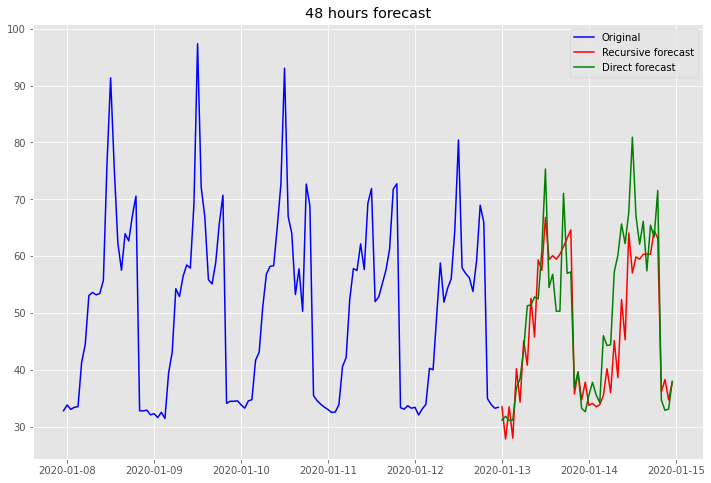

In [96]:
y = fcast_trf.inverse(index=y.index, values=y.values)
rec_fcast = fcast_trf.inverse(index=rec_fcast.index, values=rec_fcast.values)
dir_fcast = fcast_trf.inverse(index=dir_fcast.index, values=dir_fcast.values)

# plot resulting forecast
start_date = y.index[-1] - pd.Timedelta(days=5)
in_sample = y[y.index >= start_date]

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(in_sample, color="blue", label="Original")
ax.plot(rec_fcast, color="red", label="Recursive forecast")
ax.plot(dir_fcast, color="green", label="Direct forecast")
ax.set_title(f"{FCAST_STEPS} hours forecast")
ax.legend()
plt.show()

In [98]:
# forecasting errors
# print(pd.concat([f_target, dir_fcast, rec_fcast], axis=1))
rec_fcast_score = mape(f_target.values, rec_fcast.values)
print(f"Recursive forecast error: {rec_fcast_score}")
dir_fcast_score = mape(f_target.values, dir_fcast.values)
print(f"Direct forecast error: {dir_fcast_score}")

Recursive forecast error: 16.47129569455524
Direct forecast error: 13.124276043323258


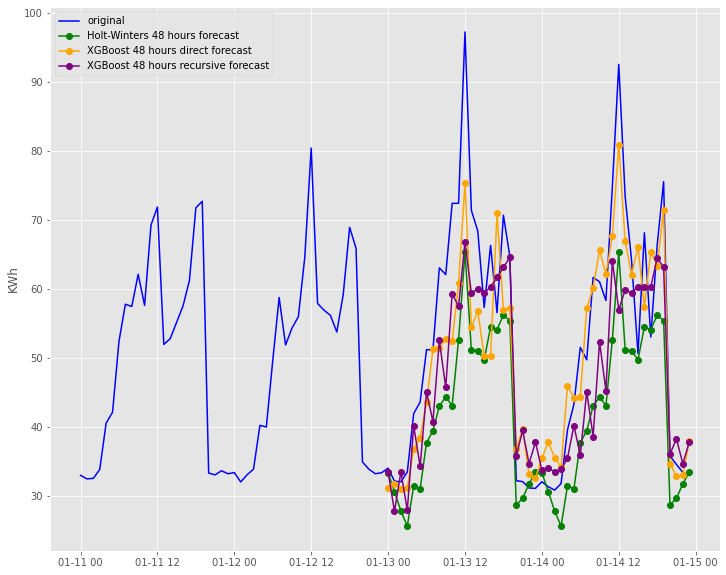

In [109]:
prophet = forecasting_results["prophet"]["fcast"]
holt = forecasting_results["holt"]["fcast"]

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

start_date = t_target.index[-1] - pd.Timedelta(days=2)

ax.plot(c_target[c_target.index > start_date], color="blue", label="original")
ax.set(ylabel="KWh")

# ax.plot(prophet[prophet.index >= t_target.index[-1]], 
#         color="red", 
#         label=f"Prophet {FCAST_STEPS} hours forecast",
#         marker="o")

ax.plot(holt[holt.index >= t_target.index[-1]], 
        color="green", 
        label=f"Holt-Winters {FCAST_STEPS} hours forecast",
        marker="o")

ax.plot(dir_fcast, 
        color="orange", 
        label=f"XGBoost {FCAST_STEPS} hours direct forecast",
        marker="o")

ax.plot(rec_fcast, 
        color="purple", 
        label=f"XGBoost {FCAST_STEPS} hours recursive forecast",
        marker="o")

ax.legend()
# plt.savefig("./notebook_files/forecast_final.png")
plt.show()